## Contents 
- - -


* [1. Exploration of datasets](#0)
   * [Initial importation, examination and formatting of data](#1)
   * [Definition of mention contexts](#2)
   * [Definition of feature representations](#3)
   * [Check for data quality issues: missing or imbalanced data, irregular cardinality](#4)
   * [Examine feature-space](#5)
* [2. Feature selection and extraction](#6)
    * [Data partitioning](#7)
* [3. Model one: Random forest classifier](#8)
    * [Hyperparameter optimisation and supervised learning on training data](#8)
    * [Model evaluation](#9)
    * [Further optimisation: PCA-transformation of features to reduce dimensionality](#10)
* [4. Model two: Fine-tuning pre-trained BERT model](#11)
    * [Hyperparameter optimisation](#11)
    * [Supervised learning on training data and model evaluation](#12)    
* [5. Model evaluation and comparison](#13)
    * [Performance of best-performing BERT model on hold-out test dataset](#13)
    * [Performance of best-performing random forest model on hold-out test dataset](#14)
    * [Analysis of BERT predictions by document type, and numbers of predictions made incorrectly by both models](#15)
    * [OOV analysis](#16)


# 1. EXPLORATION OF DATASETS <a id="0"></a>
- - - 


In [2]:
# Imports

import pandas as pd
import numpy as np
import os
import warnings
import string
import spacy
import torch
from transformers import AutoTokenizer, BertModel
import random
from tqdm import tqdm
from transformers import logging
import pickle
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

- - -

## Initial importation, examination and formatting of data <a id="1"></a>

In [3]:
# Read in and examine annotations file generated by SemEHR

path = './amlh_nlp_dataset_2023/'

df = pd.read_csv(path+'amlh_coursework_2023_annotated.csv')
df.head()

file  start   end               text       class
0  3241_General Medicine.txt   1820  1828           cyanosis  Phenotypes
1  3241_General Medicine.txt   1327  1344  umbilical hernias  Phenotypes
2  3241_General Medicine.txt   1356  1363            ascites  Phenotypes
3  3241_General Medicine.txt   1842  1847              edema  Phenotypes
4  3241_General Medicine.txt   1526  1534           prostate  Body_parts

In [4]:
# Drop data from files which were not manually corrected, and for which ground-truth information is therefore  
# not available
# Names of the files that were corrected will be used (vs. performing an inner merge on the dataframe 
# containing true mentions), as it cannot be assumed that files will have any annotations following 
# manual correction

annotated_files = []

for i in range(1,3):
    annotated_files.extend(os.listdir(path+f"mtsamples_batch{i}/corpus"))
    
df_annot = df[df.file.isin(annotated_files)]
df_annot.head()

file  start   end               text       class
0  3241_General Medicine.txt   1820  1828           cyanosis  Phenotypes
1  3241_General Medicine.txt   1327  1344  umbilical hernias  Phenotypes
2  3241_General Medicine.txt   1356  1363            ascites  Phenotypes
3  3241_General Medicine.txt   1842  1847              edema  Phenotypes
4  3241_General Medicine.txt   1526  1534           prostate  Body_parts

In [5]:
# Examine numbers of mentions (total, Phenotypes, Body parts)

print("Mentions:")
print('-'*20)
print(f"Phenotypes: {len(df_annot[df_annot['class'] == 'Phenotypes'])}")
print(f"Body parts: {len(df_annot[df_annot['class'] == 'Body_parts'])}\n")
print(f"Total: {len(df_annot)}")

Mentions:
--------------------
Phenotypes: 3549
Body parts: 2898

Total: 6447


In [6]:
# Examine numbers of unique mentions:

print("Unique mentions:")
print('-'*20)
print(f"Phenotypes: {df_annot[df_annot['class'] == 'Phenotypes'].text.nunique()}")
print(f"Body parts: {df_annot[df_annot['class'] == 'Body_parts'].text.nunique()}\n")
print(f"Total: {df_annot.text.nunique()}")

Unique mentions:
--------------------
Phenotypes: 1107
Body parts: 747

Total: 1854


In [7]:
# Create function to read in and examine text files

def get_text_file(doc, path='./amlh_nlp_dataset_2023/docs/'):
 
    """
    Opens individual text documents from specified filepath, removing line-breaks
    Returns textfile as string
    
    """
    
    path = path
    textfile = open(path+doc)
    doc = textfile.read().replace("\n", " ").replace('*', '')
    
    return doc

In [8]:
# Check function

sample = get_text_file('19_General Medicine.txt')
print(sample)

HISTORY OF PRESENT ILLNESS:    The patient is a 17-year-old female, who presents to the emergency room with foreign body and airway compromise and was taken to the operating room.  She was intubated and fishbone.  PAST MEDICAL HISTORY:    Significant for diabetes, hypertension, asthma, cholecystectomy, and total hysterectomy and cataract.  ALLERGIES:    No known drug allergies.  CURRENT MEDICATIONS:    Prevacid, Humulin, Diprivan, Proventil, Unasyn, and Solu-Medrol.  FAMILY HISTORY:    Noncontributory.  SOCIAL HISTORY:    Negative for illicit drugs, alcohol, and tobacco.  PHYSICAL EXAMINATION:    Please see the hospital chart.  LABORATORY DATA:    Please see the hospital chart.  HOSPITAL COURSE:    The patient was taken to the operating room by Dr. X who is covering for ENT and noted that she had airway compromise and a rather large fishbone noted and that was removed.  The patient was intubated and it was felt that she should be observed to see if the airway would improve upon which s

In [9]:
# Read in and examine manually corrected annotations, exported from eHOST as Excel .xlsx files

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    batch_1 = pd.read_excel('./amlh_nlp_dataset_2023/Annotations_batch_1.xlsx', engine="openpyxl")
    batch_2 = pd.read_excel('./amlh_nlp_dataset_2023/Annotations_batch_2.xlsx', engine="openpyxl")

batch_1.head()

File Name with extension         File Name  \
0             12_Neurology  12_Neurology.txt   
1             12_Neurology  12_Neurology.txt   
2             12_Neurology  12_Neurology.txt   
3             12_Neurology  12_Neurology.txt   
4             12_Neurology  12_Neurology.txt   

                                 Term          Span       Class  
0                               edema  ( 1918,1923)  Phenotypes  
1  squamous cell cancer of the cervix  ( 3477,3511)  Phenotypes  
2                left caudate nucleus  ( 1947,1967)  Body_parts  
3                            arterial  ( 2008,2016)  Body_parts  
4                        vasculopathy  ( 2103,2115)  Phenotypes

In [10]:
# During manual correction of SemEHR annotations, it was noticed that some clinical texts were repeated.
# Therefore duplicated annotations were identified and removed (assuming annotation corrections were performed
# identically each time)

# Concatenate batches and reset index
all_batches = pd.concat([batch_1, batch_2])
all_batches.index = range(len(all_batches))

# Locate any entries with identical terms, spans and classes, regardless of differences in file names
duplicates = all_batches[all_batches.groupby(['Term', 'Span', 'Class'] \
                                )['File Name'].transform('nunique') > 1].sort_values(by=['Term', 'Span'])

print(f"Total number of rows: {len(all_batches)}")
print(f"Number of duplicates: {duplicates.iloc[:, -3:].duplicated().sum()}")
duplicates.head(10)

Total number of rows: 4677
Number of duplicates: 132


File Name with extension                   File Name   Term  \
3334    3255_General Medicine   3255_General Medicine.txt   EARS   
3399    3257_General Medicine   3257_General Medicine.txt   EARS   
1436    3486_Gastroenterology   3486_Gastroenterology.txt   GERD   
3460    3265_General Medicine   3265_General Medicine.txt   GERD   
4306   3904_Discharge Summary  3904_Discharge Summary.txt   GERD   
3308    3254_General Medicine   3254_General Medicine.txt  HEENT   
3453    3263_General Medicine   3263_General Medicine.txt  HEENT   
893     3206_General Medicine   3206_General Medicine.txt  HEENT   
1363    3483_Gastroenterology   3483_Gastroenterology.txt  HEENT   
3335    3255_General Medicine   3255_General Medicine.txt   NOSE   

              Span       Class  
3334    ( 301,305)  Body_parts  
3399    ( 301,305)  Body_parts  
1436    ( 590,594)  Phenotypes  
3460    ( 590,594)  Phenotypes  
4306    ( 590,594)  Phenotypes  
3308    ( 175,180)  Body_parts  
3453    ( 175,180)  Body_parts  
893   ( 2383,2388)  Body_parts  
1363  ( 2383,2388)  Body_parts  
3335    ( 308,312)  Body_parts

In [11]:
# Drop duplicated rows from main dataframe 'all_batches'

df_duplicates_to_drop = duplicates[duplicates.iloc[:, -3:].duplicated()]
all_batches.drop(df_duplicates_to_drop.index, inplace=True)

# Check dataframe is the expected length and examine dataframe

print(f"Expected length: {4677-132}")
print(f"Actual length: {len(all_batches)}")
all_batches.head()

Expected length: 4545
Actual length: 4545


File Name with extension         File Name  \
0             12_Neurology  12_Neurology.txt   
1             12_Neurology  12_Neurology.txt   
2             12_Neurology  12_Neurology.txt   
3             12_Neurology  12_Neurology.txt   
4             12_Neurology  12_Neurology.txt   

                                 Term          Span       Class  
0                               edema  ( 1918,1923)  Phenotypes  
1  squamous cell cancer of the cervix  ( 3477,3511)  Phenotypes  
2                left caudate nucleus  ( 1947,1967)  Body_parts  
3                            arterial  ( 2008,2016)  Body_parts  
4                        vasculopathy  ( 2103,2115)  Phenotypes

In [12]:
# Ensure all files with manually corrected annotations appear in original SemEHR dataset

coursework_files = set(df_annot['file'].to_list())
batches_files = set(all_batches['File Name'].to_list())

print("Files that don't appear in SemEHR dataset:")
batches_files.difference(coursework_files)

Files that don't appear in SemEHR dataset:


{'2799_Neurology.txt'}

In [13]:
# Remove files with manually corrected annotations which do not appear in SemEHR dataset

all_batches = all_batches[all_batches['File Name'] != '2799_Neurology.txt']
print(f"Length of final dataframe: {len(all_batches)}")

Length of final dataframe: 4501


In [14]:
# Split values in 'Span' column into 'start' and 'end' columns

all_batches[['start', 'end']] = all_batches['Span'].str.strip("()").str.split(',', expand=True)
all_batches['start'] = all_batches['start'].astype('int64')
all_batches['end'] = all_batches['end'].astype('int64')

In [15]:
# Perform final formatting prior to merging:
# Drop unnecessary 'File Name with extension' column

all_batches.drop(['File Name with extension', 'Span'], axis=1, inplace=True)

# Rename columns to match dataframe 'df' 

cols = ['file', 'text', 'class', 'start', 'end']
all_batches.columns = cols

In [16]:
# Create label column in ground truth manually corrected data 'all_batches'
all_batches['label'] = 1

# Add label column to SemEHR dataset for true Phenotypes/Body parts mentions using left merge
df_groundtruth = pd.merge(df_annot, all_batches, how='left', on=['file', 'text', 'class', 'start', 'end'])

# Check length
len(df_groundtruth)

6447

In [17]:
# Label incorrect Phenotypes mentions as 0

df_groundtruth.fillna(0, inplace=True)

In [18]:
# Select only Phenotypes mentions for further analysis

df_phen = df_groundtruth[df_groundtruth['class'] == 'Phenotypes']

# Order rows by filename and mention start offset
df_phen = df_phen.sort_values(by=['file', 'start'])

print(f"Number of Phenotypes mentions: {len(df_phen)}")
df_phen.head()

Number of Phenotypes mentions: 3549


file  start  end              text       class  label
2885  12_Neurology.txt      6   15         confusion  Phenotypes    1.0
2886  12_Neurology.txt    111  127  flu-like illness  Phenotypes    1.0
2887  12_Neurology.txt    209  219        passed out  Phenotypes    1.0
2888  12_Neurology.txt    254  262          confused  Phenotypes    1.0
2889  12_Neurology.txt    268  277         lethargic  Phenotypes    1.0

- - -

## Definition of mention contexts <a id="2"></a>

In [19]:
# Create a function to extract (i) enclosing sentences for each mention, and (ii) extended excerpts, with one
# sentence either side of mention for additional context

# Load Spacy model and Sentencizer tools

with warnings.catch_warnings(record=True):
    nlp = spacy.load("en_core_web_sm")
sents = nlp.add_pipe('sentencizer')

def get_sentences(file, df=df_phen):
    
    """
    Takes as input name of text document (e.g. 12_Neurology.txt) and dataframe containing mentions and mention
    start and end offsets (default df_phen. Extracts enclosing, previous and next sentences for all mentions 
    within document by mapping these to sentences and sentence start/end offsets generated by Spacy Sentencizer. 
    Returns dataframe containing enclosing sentences, previous and next sentences for each mention

    """
    
    # Display filename
    print(file)
    
    # Create document object for text file
    textfile = get_text_file(file)
    doc_obj = nlp(textfile)
    
    # Create list of mentions in the document 
    df_doc = df[df['file'] == file]
    mentions = df_doc['text'].to_list()
    
    # Create dictionary containing mentions and start offsets
    ent_loc = {}
    for i in range(len(mentions)):
        start = df_doc['start'].iloc[i]
        ent_loc[f"{mentions[i]}-{i}"] = int(start)
    
    # Create look-up dictionary containing sentence identifiers and sentence spans
    sent_loc = {}
    sents = [str(sent) for sent in doc_obj.sents]
    sent_idx = [[sent.start_char, sent.end_char] for sent in doc_obj.sents]
    for i in range(len(sents)):
        sent_loc[i] = sent_idx[i]
    
    # Create dictionary containing sentence identifiers and contents
    sent_dict = {}
    sent_dict['-'] = '-'
    for i in range(len(sents)):
        sent_dict[i] = sents[i]
    
    enclosing_sentences = []
    lower_bound_sentences = []
    upper_bound_sentences = []
    
    # Iterate through mentions, identify which sentence is found in using start offset and sentence spans,
    # and extract flanking sentences (unless mention is found in either first or last sentence)
    for ent, idx in ent_loc.items():
        main_sent = ''
        prev_sent = ''
        next_sent = ''
        for k, v in sent_loc.items():
            if idx in range(v[0], v[1]):
                main_sent = k
                if k > 0:
                    prev_sent = k-1
                else:
                    prev_sent = '-'
                if k < len(sent_loc)-1:
                    next_sent = k+1
                else:
                    next_sent = '-'            
        enclosing_sentences.append(sent_dict[main_sent])
        lower_bound_sentences.append(sent_dict[prev_sent])
        upper_bound_sentences.append(sent_dict[next_sent])
    
    # Build 3-sentence long extended excerpts containing mentions
    excerpt = []
    for i in range(len(df_doc)):
        excerpt.append([lower_bound_sentences[i] + " " + enclosing_sentences[i] + " " + upper_bound_sentences[i]])
    
    # Append sentences/excerpts to dataframe 
    with warnings.catch_warnings(record=True): 
        # Append enclosing sentence for each mention
        df_doc['enclosing_sentence'] = enclosing_sentences
        df_doc['prev_sent'] = lower_bound_sentences
        df_doc['next_sent'] = upper_bound_sentences
        df_doc
        
    return df_doc


In [20]:
# Test function

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

get_sentences('3241_General Medicine.txt')

3241_General Medicine.txt


file  start   end                 text       class  \
16  3241_General Medicine.txt    164   170               rashes  Phenotypes   
17  3241_General Medicine.txt    172   183          ulcerations  Phenotypes   
18  3241_General Medicine.txt    187   196            petechiae  Phenotypes   
23  3241_General Medicine.txt    440   445                scars  Phenotypes   
26  3241_General Medicine.txt    485   489                 gums  Phenotypes   
30  3241_General Medicine.txt    640   659  thyroid enlargement  Phenotypes   
31  3241_General Medicine.txt    668   678           tenderness  Phenotypes   
1   3241_General Medicine.txt   1327  1344    umbilical hernias  Phenotypes   
2   3241_General Medicine.txt   1356  1363              ascites  Phenotypes   
13  3241_General Medicine.txt   1730  1740           tenderness  Phenotypes   
35  3241_General Medicine.txt   1744  1753            effusions  Phenotypes   
0   3241_General Medicine.txt   1820  1828             cyanosis  Phenotypes   
3   3241_General Medicine.txt   1842  1847                edema  Phenotypes   

    label  \
16    0.0   
17    0.0   
18    0.0   
23    0.0   
26    0.0   
30    0.0   
31    0.0   
1     0.0   
2     0.0   
13    0.0   
35    0.0   
0     0.0   
3     0.0   

                                                                                  enclosing_sentence  \
16  VITAL SIGNS:      SKIN:    Inspection of the skin reveals no rashes, ulcerations or petechiae.     
17  VITAL SIGNS:      SKIN:    Inspection of the skin reveals no rashes, ulcerations or petechiae.     
18  VITAL SIGNS:      SKIN:    Inspection of the skin reveals no rashes, ulcerations or petechiae.     
23                   External inspection of the ears and nose showed no scars, lesions, or masses.     
26                                                     Lips, teeth, and gums showed normal mucosa.     
30                       There was no thyroid enlargement, and no tenderness, or masses were felt.     
31                       There was no thyroid enlargement, and no tenderness, or masses were felt.     
1                                               There were no inguinal or umbilical hernias noted.     
2                                                                            No ascites was noted.     
13                                                     There was no tenderness or effusions noted.     
35                                                     There was no tenderness or effusions noted.     
0                                                  EXTREMITIES:    No cyanosis, clubbing or edema.     
3                                                  EXTREMITIES:    No cyanosis, clubbing or edema.     

                                                                                                             prev_sent  \
16                PHYSICAL EXAMINATION  GENERAL APPEARANCE:    Well developed, well nourished, in no acute distress.     
17                PHYSICAL EXAMINATION  GENERAL APPEARANCE:    Well developed, well nourished, in no acute distress.     
18                PHYSICAL EXAMINATION  GENERAL APPEARANCE:    Well developed, well nourished, in no acute distress.     
23  Extraocular movements were intact and pupils were equal, round, and reactive to light with normal accommodation.     
26                                     External inspection of the ears and nose showed no scars, lesions, or masses.     
30                                                                                    NECK:    Supple and symmetric.     
31                                                                                    NECK:    Supple and symmetric.     
1                                                                                       The spleen was not palpable.     
2                                                                 There were no inguinal or umbilical hernias noted.     
13                                                        

In [21]:
# For each mention, extract sentences/excerpts into dataframe

df_sent = pd.DataFrame()

for doc in df_phen.file.unique():
    temp_df = get_sentences(doc)
    df_sent = pd.concat([df_sent, temp_df], axis=0)

12_Neurology.txt
1485_Radiology.txt
1488_Radiology.txt
1489_Radiology.txt
1490_Radiology.txt
1492_Radiology.txt
1494_Radiology.txt
1495_Radiology.txt
1498_Radiology.txt
1502_Radiology.txt
1503_Radiology.txt
1510_Radiology.txt
1511_Radiology.txt
1516_Radiology.txt
1519_Radiology.txt
1526_Radiology.txt
1527_Radiology.txt
1528_Radiology.txt
1529_Radiology.txt
1530_Radiology.txt
1533_Radiology.txt
1534_Radiology.txt
1535_Radiology.txt
1536_Radiology.txt
1540_Radiology.txt
1541_Radiology.txt
1542_Radiology.txt
1543_Radiology.txt
1544_Radiology.txt
1557_Radiology.txt
1560_Radiology.txt
1567_Radiology.txt
1568_Radiology.txt
1574_Radiology.txt
1577_Radiology.txt
1580_Radiology.txt
1581_Radiology.txt
1583_Radiology.txt
1589_Radiology.txt
19_General Medicine.txt
2756_Neurology.txt
2757_Neurology.txt
2758_Neurology.txt
2760_Neurology.txt
2763_Neurology.txt
2766_Neurology.txt
2771_Neurology.txt
2772_Neurology.txt
2778_Neurology.txt
2779_Neurology.txt
2781_Neurology.txt
2784_Neurology.txt
2785_Neur

In [22]:
# Examine output

df_sent.head()

file  start  end              text       class  label  \
2885  12_Neurology.txt      6   15         confusion  Phenotypes    1.0   
2886  12_Neurology.txt    111  127  flu-like illness  Phenotypes    1.0   
2887  12_Neurology.txt    209  219        passed out  Phenotypes    1.0   
2888  12_Neurology.txt    254  262          confused  Phenotypes    1.0   
2889  12_Neurology.txt    268  277         lethargic  Phenotypes    1.0   

                                                                                                         enclosing_sentence  \
2885                                                                                  CC:   Confusion and slurred speech.     
2886                                                   RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   
2887  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   
2888  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   
2889  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   

                                                                 prev_sent  \
2885                                                                     -   
2886                HX    (primarily obtained from boyfriend): This 31 y/o   
2887  RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   
2888  RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   
2889  RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   

                                                                                                                  next_sent  
2885                                                                 HX    (primarily obtained from boyfriend): This 31 y/o  
2886  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.  
2887                                                                              She apparently recovered within 24 hours.  
2888                                                                              She apparently recovered within 24 hours.  
2889                                                                              She apparently recovered within 24 hours.

In [23]:
# Append mention to start of enclosing sentence

df_sent['mention_sent'] = df_sent.text + ": " + df_sent.enclosing_sentence

df_sent.head()

file  start  end              text       class  label  \
2885  12_Neurology.txt      6   15         confusion  Phenotypes    1.0   
2886  12_Neurology.txt    111  127  flu-like illness  Phenotypes    1.0   
2887  12_Neurology.txt    209  219        passed out  Phenotypes    1.0   
2888  12_Neurology.txt    254  262          confused  Phenotypes    1.0   
2889  12_Neurology.txt    268  277         lethargic  Phenotypes    1.0   

                                                                                                         enclosing_sentence  \
2885                                                                                  CC:   Confusion and slurred speech.     
2886                                                   RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   
2887  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   
2888  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   
2889  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   

                                                                 prev_sent  \
2885                                                                     -   
2886                HX    (primarily obtained from boyfriend): This 31 y/o   
2887  RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   
2888  RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   
2889  RHF experienced a "flu-like illness 6-8 weeks prior to presentation.   

                                                                                                                  next_sent  \
2885                                                                 HX    (primarily obtained from boyfriend): This 31 y/o   
2886  3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.   
2887                                                                              She apparently recovered within 24 hours.   
2888                                                                              She apparently recovered within 24 hours.   
2889                                                                              She apparently recovered within 24 hours.   

                                                                                                                           mention_sent  
2885                                                                                   confusion: CC:   Confusion and slurred speech.    
2886                                             flu-like illness: RHF experienced a "flu-like illness 6-8 weeks prior to presentation.  
2887  passed out: 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.  
2888    confused: 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.  
2889   lethargic: 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic.

- - -

## Definition of feature representations <a id="3"></a>


In [24]:
# Load pre-trained tokenizer: Bert base model
base_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

# Load pre-trained tokenizer: Bert further-trained on contents of MIMIC-III db (ClinicalBERT)
clin_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", do_lower_case = True)

In [25]:
# Create function to tokenize a random sentence using base Bert model and Pubmed Bert and display results

def tokenize_sample_sentence(df, col, seed):
    
    """
    Displays tokens and IDs for a random text sample following tokenization using base Bert model and 
    Bert model further trained on MIMIC-III corpus (ClinicalBert)
    Returns dataframe
    
    """
    # 
    random.seed(seed)
    index = random.randint(0, len(df)+1)
    sentence = df[col].iloc[index]
    print(sentence)
    
    #
    
    results = {'Tokens - Bert': base_tokenizer.tokenize(sentence),
               'Token ID - Bert': base_tokenizer.convert_tokens_to_ids(base_tokenizer.tokenize(sentence)),
               'Tokens - ClinicalBert': clin_tokenizer.tokenize(sentence),
               'Token ID - ClinicalBert': clin_tokenizer.convert_tokens_to_ids(clin_tokenizer.tokenize(sentence))
              }
    
    bert_no_tokens = len(results['Tokens - Bert'])
    clin_no_tokens = len(results['Tokens - ClinicalBert'])
    diff = abs(bert_no_tokens - clin_no_tokens)
    shorter = np.argmin([bert_no_tokens, clin_no_tokens])
    
    if shorter == 1:
        results['Tokens - ClinicalBert'].extend(('- ' * diff).split())
        results['Token ID - ClinicalBert'].extend(('- ' * diff).split())
    else:
        results['Tokens - Bert'].extend(('- ' * diff).split())
        results['Token ID - Bert'].extend(('- ' * diff).split())
    
    return pd.DataFrame(results).T


In [26]:
# Test function

tokenize_sample_sentence(df_sent, 'mention_sent', 101)

cancer: Regarding the cancer itself, it was found that 1 out of 53 nodes were positive for cancer.  


0     1          2     3       4       5     6   \
Tokens - Bert            cancer     :  regarding   the  cancer  itself     ,   
Token ID - Bert            4456  1024       4953  1996    4456    2993  1010   
Tokens - ClinicalBert    cancer     :  regarding   the  cancer  itself     ,   
Token ID - ClinicalBert    4182   131       4423  1103    4182    2111   117   

                           7     8      9     10    11    12    13    14  \
Tokens - Bert              it   was  found  that     1   out    of    53   
Token ID - Bert          2009  2001   2179  2008  1015  2041  1997  5187   
Tokens - ClinicalBert      it   was  found  that     1   out    of    53   
Token ID - ClinicalBert  1122  1108   1276  1115   122  1149  1104  4389   

                            15    16        17    18      19    20  
Tokens - Bert            nodes  were  positive   for  cancer     .  
Token ID - Bert          14164  2020      3893  2005    4456  1012  
Tokens - ClinicalBert    nodes  were  positive   for  cancer     .  
Token ID - ClinicalBert  15029  1127      3112  1111    4182   119

In [27]:
# Create function to perform sentence pre-processing

def process_sentence(text, tokenizer, padding_type):
    
    """
    Performs sentence preprocessing (tokenization, addition of special [CLS] and [SEP] tokens, mapping of 
    tokens to token IDs, right-padding of all sentences to the same length, creation of attention masks to 
    differentiate real tokens from [PAD] tokens. Right-padding can be performed to maximal input size for 
    model (512) using padding='max_length' or to longest sequence in bacth using padding='longest'
    
    Returns Pytorch tensors
    
    """
    # Set maximum padding length for ClinicalBert model, which has no default maximum
    if (tokenizer == clin_tokenizer) & (padding_type == 'max_length'):
        results = tokenizer.encode_plus(text, add_special_tokens = True, max_length = 512,
                                        padding='max_length', return_attention_mask = True, return_tensors = 'pt')
        
    else:
        results = tokenizer.encode_plus(text, add_special_tokens = True, padding=padding_type, 
                                        return_attention_mask = True, return_tensors = 'pt')
    
    return results
    

In [28]:
# Test function

sent = df_sent['mention_sent'].iloc[0]

print(f"Bert tokenizer:\n{process_sentence(sent, base_tokenizer, 'longest')}")
print('-'*20)
print(f"ClinicalBert tokenizer:\n{process_sentence(sent, clin_tokenizer, 'longest')}")


Bert tokenizer:
{'input_ids': tensor([[  101,  6724,  1024, 10507,  1024,  6724,  1998, 22889,  3126,  5596,
          4613,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
--------------------
ClinicalBert tokenizer:
{'input_ids': tensor([[  101,  6406,   131, 14402,   131,  6406,  1105,   188,  7535, 16145,
          4055,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [29]:
# Create lists to store sentence tokens, token IDs and attention masks 

base_token_ids = []
base_attention_masks = []

clin_token_ids = []
clin_attention_masks = []

In [30]:
# Create function to flexibly feed specified sentence type (e.g. main, previous, next) to specified tokenizer
# and update lists where relevant tensors stored

def input_sent_processing(tokenizer, padding, df=df_sent, col='mention_sent'):
       
    """
    Function to feed sentences for processing using directed model (e.g. base Bert, ClinicalBert) and 
    output lists of input_ids and attention_mask tensors
    
    """
    global base_token_ids
    global clin_token_ids
    global base_attention_masks
    global clin_attention_masks
    
    # Apply function 'process_sentence' to each row in relevant dataframe/column
    for sent in df[col]:
        encoding_dict = process_sentence(sent, tokenizer, padding)
        
        # Append to correct list for base BERT model and ClinicalBERT
        if tokenizer == base_tokenizer:
            base_token_ids.append(encoding_dict['input_ids'])
            base_attention_masks.append(encoding_dict['attention_mask'])
                
        elif tokenizer == clin_tokenizer:
            clin_token_ids.append(encoding_dict['input_ids'])
            clin_attention_masks.append(encoding_dict['attention_mask'])
            

In [31]:
# Check initial list lengths

print(len(base_token_ids))
print(len(base_attention_masks))
print('-'*20)

# Feed in sentences for processing using base Bert model
input_sent_processing(base_tokenizer, 'max_length')

# Check results: numbers of processed sentences
print('Number of processed sentences (Bert):')
print(len(base_token_ids))
print(len(base_attention_masks))

0
0
--------------------
Number of processed sentences (Bert):
3549
3549


In [32]:
# Check initial list lengths

print(len(clin_token_ids))
print(len(clin_attention_masks))
print('-'*20)

# Feed in sentences for processing using Pubmed Bert model
input_sent_processing(clin_tokenizer, 'max_length')

# Check results
print('Number of processed sentences (ClinicalBert):')
print(len(clin_token_ids))
print(len(clin_attention_masks))

0
0
--------------------
Number of processed sentences (ClinicalBert):
3549
3549


In [33]:
# Create a function to examine outputs of sentence pre-processing

def print_sample_sentence_encoding(tokenizer, seed):
    
    """
    Displays tokens, token IDs and attention mask for a random text sample following processing using base 
    Bert model and Bert model further trained on MIMIC-III corpus (ClinicalBert)
    Returns dataframe containing first 100 tokens, token ids and attention masks
    
    """
    # Initialise seed for reproducible results
    random.seed(seed)
    # Get random index value
    index = random.randint(0, len(df_sent))
    
    # For base BERT model, extract token ids and attention masks from base model lists
    if tokenizer == base_tokenizer:
        token_id = torch.cat(base_token_ids, dim = 0)
        attention_masks = torch.cat(base_attention_masks, dim = 0)
        
        # Convert token IDs back to token, extract token IDs and attention masks
        tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
        token_ids = [np.array(i) for i in token_id[index]]
        attention = [np.array(i) for i in attention_masks[index]]
    
    # For ClinicalBERT model, extract token ids and attention masks from clin model lists
    else:
        token_id = torch.cat(clin_token_ids, dim = 0)
        attention_masks = torch.cat(clin_attention_masks, dim = 0)
        
        tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
        token_ids = [np.array(i) for i in token_id[index]]
        attention = [np.array(i) for i in attention_masks[index]]
      
    # Display results horizontally
    results = {'tokens': tokens[:101], 'token_ids': token_ids[:101], 'attention': attention[:101]}
    return pd.DataFrame(results).T


In [34]:
# Check results

print_sample_sentence_encoding(base_tokenizer, 42)

0         1     2     3     4     5         6      7     8    \
tokens     [CLS]  bleeding     :   one    or   two  bleeding  areas  were   
token_ids    101      9524  1024  2028  2030  2048      9524   2752  2020   
attention      1         1     1     1     1     1         1      1     1   

             9     10     11      12    13    14        15    16    17   \
tokens        fu   ##l  ##gur  ##ated     ,   and  bleeding   was  well   
token_ids  11865  2140  27390    4383  1010  1998      9524  2001  2092   
attention      1     1      1       1     1     1         1     1     1   

                  18    19     20     21     22     23     24     25     26   \
tokens     controlled     .  [SEP]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids        4758  1012    102      0      0      0      0      0      0   
attention           1     1      1      0      0      0      0      0      0   

             27     28     29     30     31     32     33     34     35   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             36     37     38     39     40     41     42     43     44   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             45     46     47     48     49     50     51     52     53   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             54     55     56     57     58     59     60     61     62   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             63     64     65     66     67     68     69     70     71   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             72     73     74     75     76     77     78     79     80   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             81     82     83     84     85     86     87     88     89   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             90     91     92     93     94     95     96     97     98   \
tokens     [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]  [PAD]   
token_ids      0      0      0      0      0      0      0      0      0   
attention      0      0      0      0      0      0      0      0      0   

             99     100  
tokens     [PAD]  [PAD]  
token_ids      0      0  
attention      0      0

In [35]:
# Create a function to derive embeddings from pre-trained Bert/Pubmed Bert models for use as features
# in downstream classification tasks

def get_embeddings(model_id, tokens, attention):
    
    """
    Function to extract sentence embeddings from pretrained Bert model. Sentences are represented as the 
    mean of token vectors from the second-to-last hidden state. Takes as input the name of the Bert model 
    (e.g. bert_base_uncased), and tensors containing sentence token IDs and attention masks. Returns 
    sentence representation as a 768-dimensional array  
    
    """
    
    # Load pre-trained model (weights) with all hidden-states
    model = BertModel.from_pretrained(model_id, output_hidden_states = True)
    
    # Put the model in evaluation mode (feed-forward operation)
    model.eval()
    
    # Run the text through BERT, and collect hidden states from each of the 12 layers. Extract hidden states from 
    # all layers (index 2) as 'hidden_states'
    with torch.no_grad():
        logging.set_verbosity_error()
        outputs = model(tokens, attention)
        hidden_states = outputs[2]
    
    # Extract sentence vector by taking the mean of token vectors from second-to-last hidden state
    sec_to_last_hs = hidden_states[-2]
    token_vecs = sec_to_last_hs[0]
    sentence_emb = torch.mean(token_vecs, dim=0)
    
    return sentence_emb

In [301]:
# Apply function to extract all sentence embeddings using pre-trained base Bert model, storing
# and saving results 

# Create dictionaries to store sentence embeddings
dict_sentence2emb_bert_base = {}

# Extract sentence embeddings using base Bert model
for i in tqdm(range(len(base_token_ids_main))):
    logging.set_verbosity_error()
    embedding = get_embeddings('bert-base-uncased', base_token_ids_main[i], base_attention_masks_main[i])
    dict_sentence2emb_bert_base[f"Sentence-{i}"] = embedding
    
# Given time-consuming process of embedding generation, use pickle to store serialised dictionary of sentence 
# embeddings to disk for potential later use
with open('sentence2emb_bert_base.pkl', 'wb') as handle:
    pickle.dump(dict_sentence2emb_bert_base, handle, protocol=pickle.HIGHEST_PROTOCOL)   
    
print('Saved: sentence2emb_bert_base')

100%|█████████████████████████████████████| 3549/3549 [2:34:42<00:00,  2.62s/it]


Saved: sentence2emb_bert_base


In [313]:
# Apply function to extract all sentence embeddings using pre-trained ClinicalBert model, storing and saving 
# results 

# Create dictionaries to store sentence embeddings
dict_sentence2emb_clin = {}

# Extract sentence embeddings 
for i in tqdm(range(len(clin_token_ids))):
    logging.set_verbosity_error()
    embedding = get_embeddings('emilyalsentzer/Bio_ClinicalBERT', clin_token_ids[i], clin_attention_masks[i])
    dict_sentence2emb_clin[f"Sentence-{i}"] = embedding

# Save serialised dectionary of sentence embeddings 
with open('sentence2emb_clin.pkl', 'wb') as handle:
    pickle.dump(dict_sentence2emb_clin, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved: sentence2emb_clin')

  0%|                                                  | 0/3549 [00:00<?, ?it/s]

100%|█████████████████████████████████████| 3549/3549 [2:30:20<00:00,  2.54s/it]


Saved: sentence2emb_clin


In [315]:
# Examine output

print('Number of sentences (Bert/ClinicalBert):')
print(len(dict_sentence2emb_bert_base))
print(len(dict_sentence2emb_clin))
print('\nNumber of vectors per sentence:')
print(len(dict_sentence2emb_bert_base['Sentence-0']))

Number of sentences (Bert/ClinicalBert):
3549
3549

Number of vectors per sentence:
768


In [36]:
# Load stored sentence embedding dictionaries

with open('sentence2emb_bert_base.pkl','rb') as f:
    sentence2emb_bert_base = pickle.load(f)
    
with open('sentence2emb_clin.pkl','rb') as f:
    sentence2emb_clin = pickle.load(f)

In [37]:
# Append embeddings to dataframe

bert_embeddings = [v.tolist() for v in sentence2emb_bert_base.values()]
clin_embeddings = [v.tolist() for v in sentence2emb_clin.values()]

df_sent['bert'] = bert_embeddings
df_sent['clin'] = clin_embeddings

In [38]:
# Examine output

pd.reset_option('display.max_colwidth')
df_sent.head()

file  start  end              text       class  label  \
2885  12_Neurology.txt      6   15         confusion  Phenotypes    1.0   
2886  12_Neurology.txt    111  127  flu-like illness  Phenotypes    1.0   
2887  12_Neurology.txt    209  219        passed out  Phenotypes    1.0   
2888  12_Neurology.txt    254  262          confused  Phenotypes    1.0   
2889  12_Neurology.txt    268  277         lethargic  Phenotypes    1.0   

                                     enclosing_sentence  \
2885              CC:   Confusion and slurred speech.     
2886  RHF experienced a "flu-like illness 6-8 weeks ...   
2887  3-4 weeks prior to presentation, she was found...   
2888  3-4 weeks prior to presentation, she was found...   
2889  3-4 weeks prior to presentation, she was found...   

                                              prev_sent  \
2885                                                  -   
2886  HX    (primarily obtained from boyfriend): Thi...   
2887  RHF experienced a "flu-like illness 6-8 weeks ...   
2888  RHF experienced a "flu-like illness 6-8 weeks ...   
2889  RHF experienced a "flu-like illness 6-8 weeks ...   

                                              next_sent  \
2885  HX    (primarily obtained from boyfriend): Thi...   
2886  3-4 weeks prior to presentation, she was found...   
2887          She apparently recovered within 24 hours.   
2888          She apparently recovered within 24 hours.   
2889          She apparently recovered within 24 hours.   

                                           mention_sent  \
2885   confusion: CC:   Confusion and slurred speech.     
2886  flu-like illness: RHF experienced a "flu-like ...   
2887  passed out: 3-4 weeks prior to presentation, s...   
2888  confused: 3-4 weeks prior to presentation, she...   
2889  lethargic: 3-4 weeks prior to presentation, sh...   

                                                   bert  \
2885  [-0.09398503601551056, -0.1411825716495514, 0....   
2886  [-0.15563428401947021, -0.5237497687339783, 0....   
2887  [-0.057000331580638885, -0.5309115648269653, 0...   
2888  [-0.1500060111284256, -0.4495825171470642, 0.1...   
2889  [0.028469249606132507, -0.5804861187934875, 0....   

                                                   clin  
2885  [-0.6653831601142883, 0.06389425694942474, -0....  
2886  [-0.1412733793258667, 0.7056699991226196, -0.1...  
2887  [-0.5277758836746216, 0.46295902132987976, -0....  
2888  [-0.6014828681945801, 0.5576923489570618, -0.5...  
2889  [-0.6104449033737183, 0.5197675228118896, -0.5...

- - -

## Check for data quality issues: missing or imbalanced data <a id="4"></a>


In [39]:
# Check for missing values

print(f'Missing values:\n\n{df_sent.isnull().sum()}')

Missing values:

file                  0
start                 0
end                   0
text                  0
class                 0
label                 0
enclosing_sentence    0
prev_sent             0
next_sent             0
mention_sent          0
bert                  0
clin                  0
dtype: int64


In [40]:
# Examine numbers of true and false Phenotypes mentions

print("Phenotypes mentions:")
print('-'*20)
print(f"True mentions: {len(df_sent[df_sent['label'] == 1])}")
print(f"False mentions: {len(df_sent[df_sent['label'] == 0])}\n")
print(f"Total: {len(df_sent)}")

Phenotypes mentions:
--------------------
True mentions: 1681
False mentions: 1868

Total: 3549


In [41]:
# Examine numbers of unique true and false Phenotypes mentions:

print("Unique Phenotypes mentions:")
print('-'*20)
print(f"True mentions: {df_sent[df_sent['label'] == 1].text.nunique()}")
print(f"False mentions: {df_sent[df_sent['label'] == 0].text.nunique()}\n")
print(f"Total: {df_sent.text.nunique()}")

Unique Phenotypes mentions:
--------------------
True mentions: 726
False mentions: 594

Total: 1107


- - -

## Examine feature-space <a id="5"></a>


In [42]:
# Collapse 768-dimensional sentence embeddings generated by Bert model to 3 using tSNE 

# Create array of sentence embeddings
embeddings = np.array([v for v in df_sent.bert])

# Instantiate tSNE
dim_reducer = TSNE(n_components=3)

# Fit to data
reduced_embeds = dim_reducer.fit_transform(embeddings)

# Output to dataframe, together with sentence labels and categories ('general medicine' etc)
df = pd.DataFrame.from_dict({'x':reduced_embeds[:,0],'y': reduced_embeds[:,1],
                             'z': reduced_embeds[:,2], 'label': df_sent['label'],
                             'file': df_sent['file']})


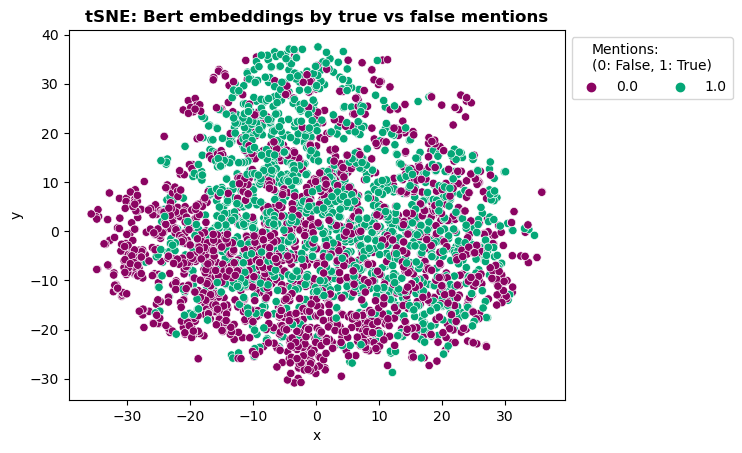

In [44]:
# Generate tSNE plot - Bert embeddings coloured by label (true and false mentions)
 
palette = ['#8B0462', '#04A777']

# Generate scatterplot, add title and legend
fig = plt.figure() 
plt.title("tSNE: Bert embeddings by true vs false mentions", 
          fontsize=12, fontweight='bold')
scatterplot = sns.scatterplot(data=df,x='x',y='y',hue='label', palette = palette)
plt.legend(title="Mentions:\n(0: False, 1: True)", ncol = 2, bbox_to_anchor = [1, 1])

# Uncomment to save to wd
fig.savefig(f"tSNE_BERT.png", bbox_inches='tight');

In [45]:
# Format filenames to view mentions by category

with warnings.catch_warnings(record=True):
    df['file'] = df['file'].str.replace('\d+', '').str.replace('_', '').str.replace('.txt', '')

df.file.value_counts()

General Medicine     1002
Neurology             872
Discharge Summary     703
Gastroenterology      687
Radiology             285
Name: file, dtype: int64

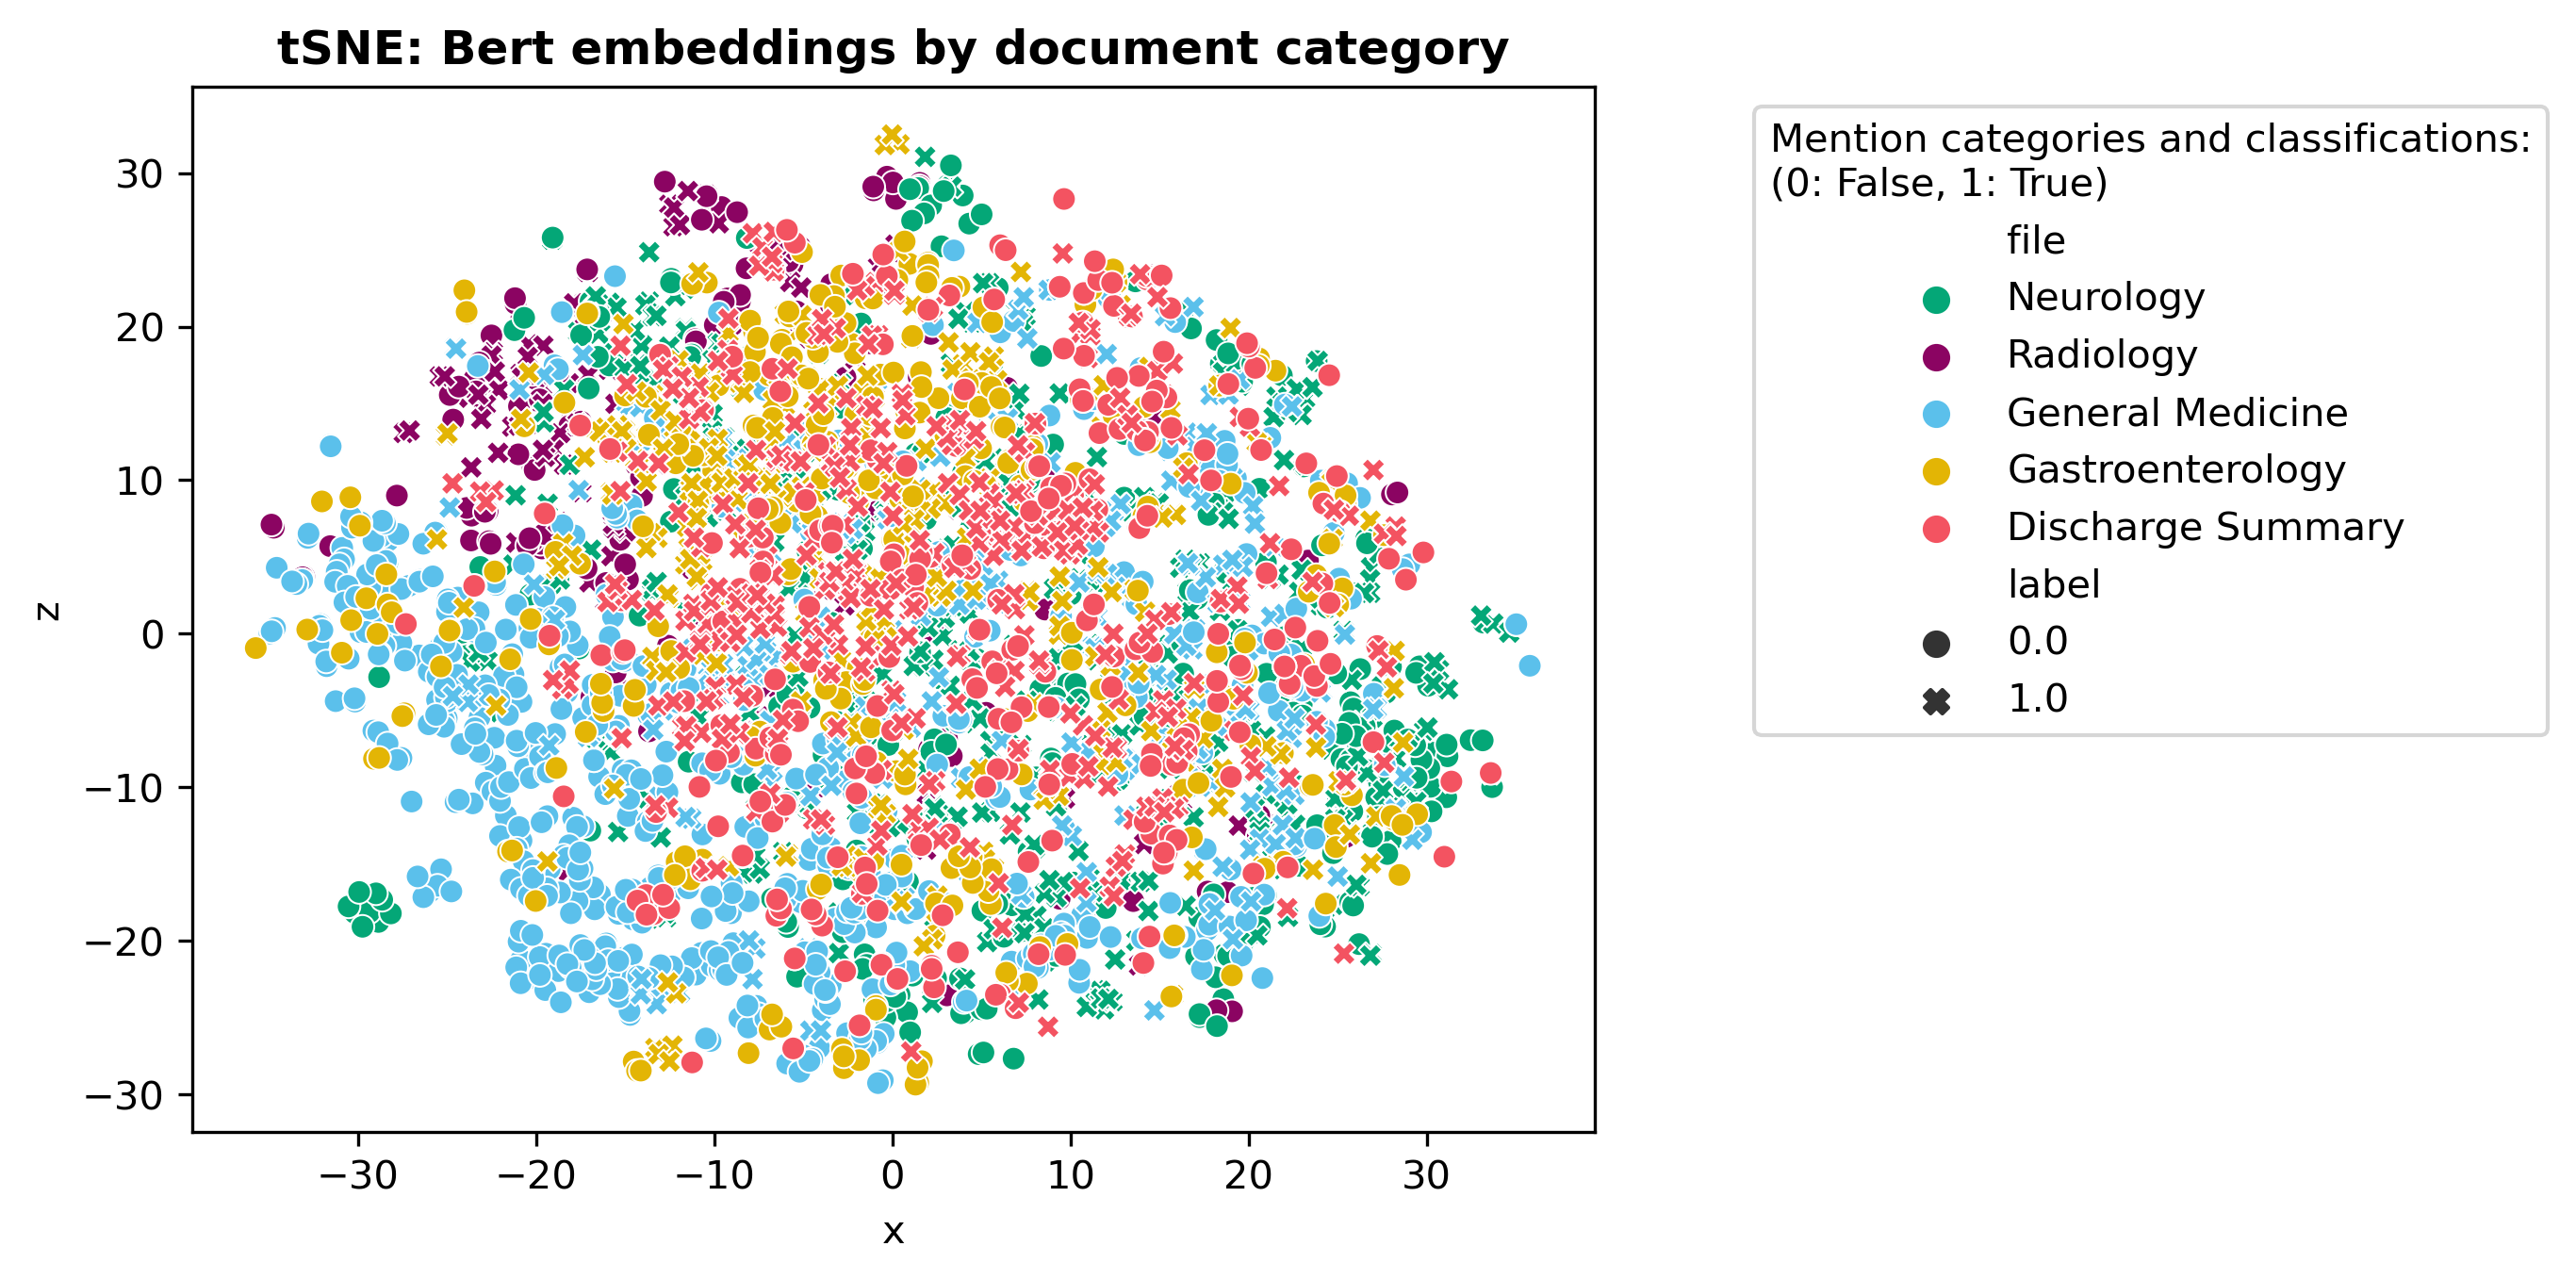

In [46]:
# Generate tSNE plot - Bert embeddings coloured by sentence categories ('general medicine' etc)

colours = ['#04A777', '#8B0462', '#5BC0EB', '#E3B505', '#F35361']

# Generate scatterplot, add title and legend
fig = plt.figure(dpi=300) 
plt.title("tSNE: Bert embeddings by document category", 
          fontsize=12, fontweight='bold')
scatterplot = sns.scatterplot(data=df, x='x', y='z', hue='file', palette = colours, style=df['label'])
plt.legend(title="Mention categories and classifications:\n(0: False, 1: True)", bbox_to_anchor = [1.1, 1]);

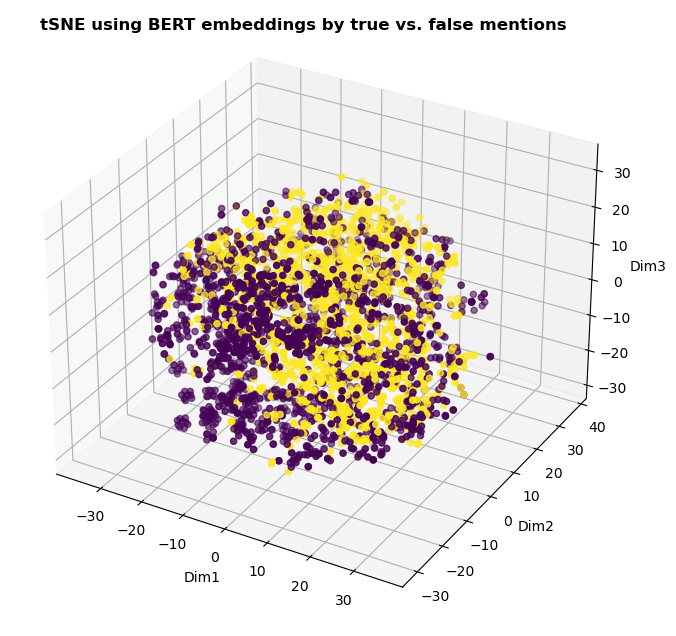

In [47]:
# Generate 3D plot tSNE plot - Bert embeddings coloured by label (true and false mentions)

with warnings.catch_warnings(record=True):
    f1 = df['x'].values
    f2 = df['y'].values 
    f3 = df['z'].values

    col = df['label']
    col[col=='0'] = '#ff2768'
    col[col=='1'] = '#05e0e9'

fig = plt.figure(figsize=(12,8))
plt.suptitle("tSNE using BERT embeddings by true vs. false mentions", 
             fontsize=12, fontweight='bold', y=0.87)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f1, f2, f3, c=col)
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
ax.legend([],[], frameon=False);

In [48]:
# Collapse 768-dimensional sentence embeddings generated by ClinicalBert model to 3 using tSNE

embeddings = np.array([v for v in df_sent.clin])

dim_reducer = TSNE(n_components=3)

reduced_embeds = dim_reducer.fit_transform(embeddings)

df_pubmed = pd.DataFrame.from_dict({'x':reduced_embeds[:,0],'y': reduced_embeds[:,1],
                             'z': reduced_embeds[:,2], 'label': df_sent['label'],
                             'file': df['file']})

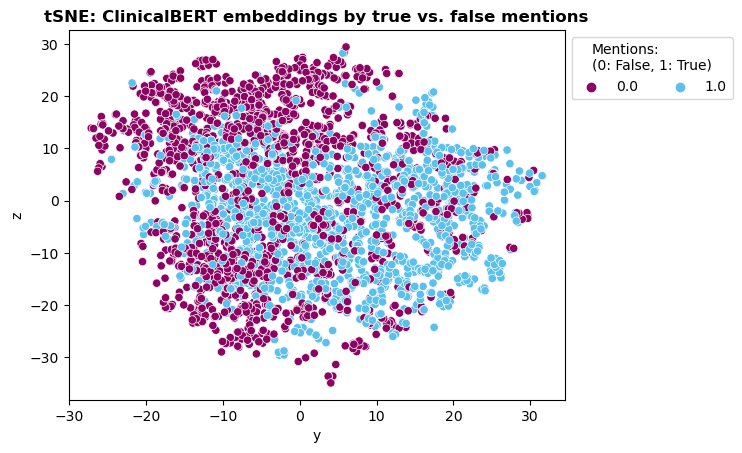

In [49]:
# Generate tSNE plot - ClinicalBert embeddings coloured by label (true and false mentions)

palette = ['#8B0462', '#5BC0EB']

fig = plt.figure() 
plt.title("tSNE: ClinicalBERT embeddings by true vs. false mentions", 
          fontsize=12, fontweight='bold')
scatterplot = sns.scatterplot(data=df_pubmed,x='y',y='z',hue='label', palette = palette)
plt.legend(title="Mentions:\n(0: False, 1: True)", ncol = 2, bbox_to_anchor = [1, 1])

fig.savefig(f"tSNE_clinical_BERT.png", bbox_inches='tight');

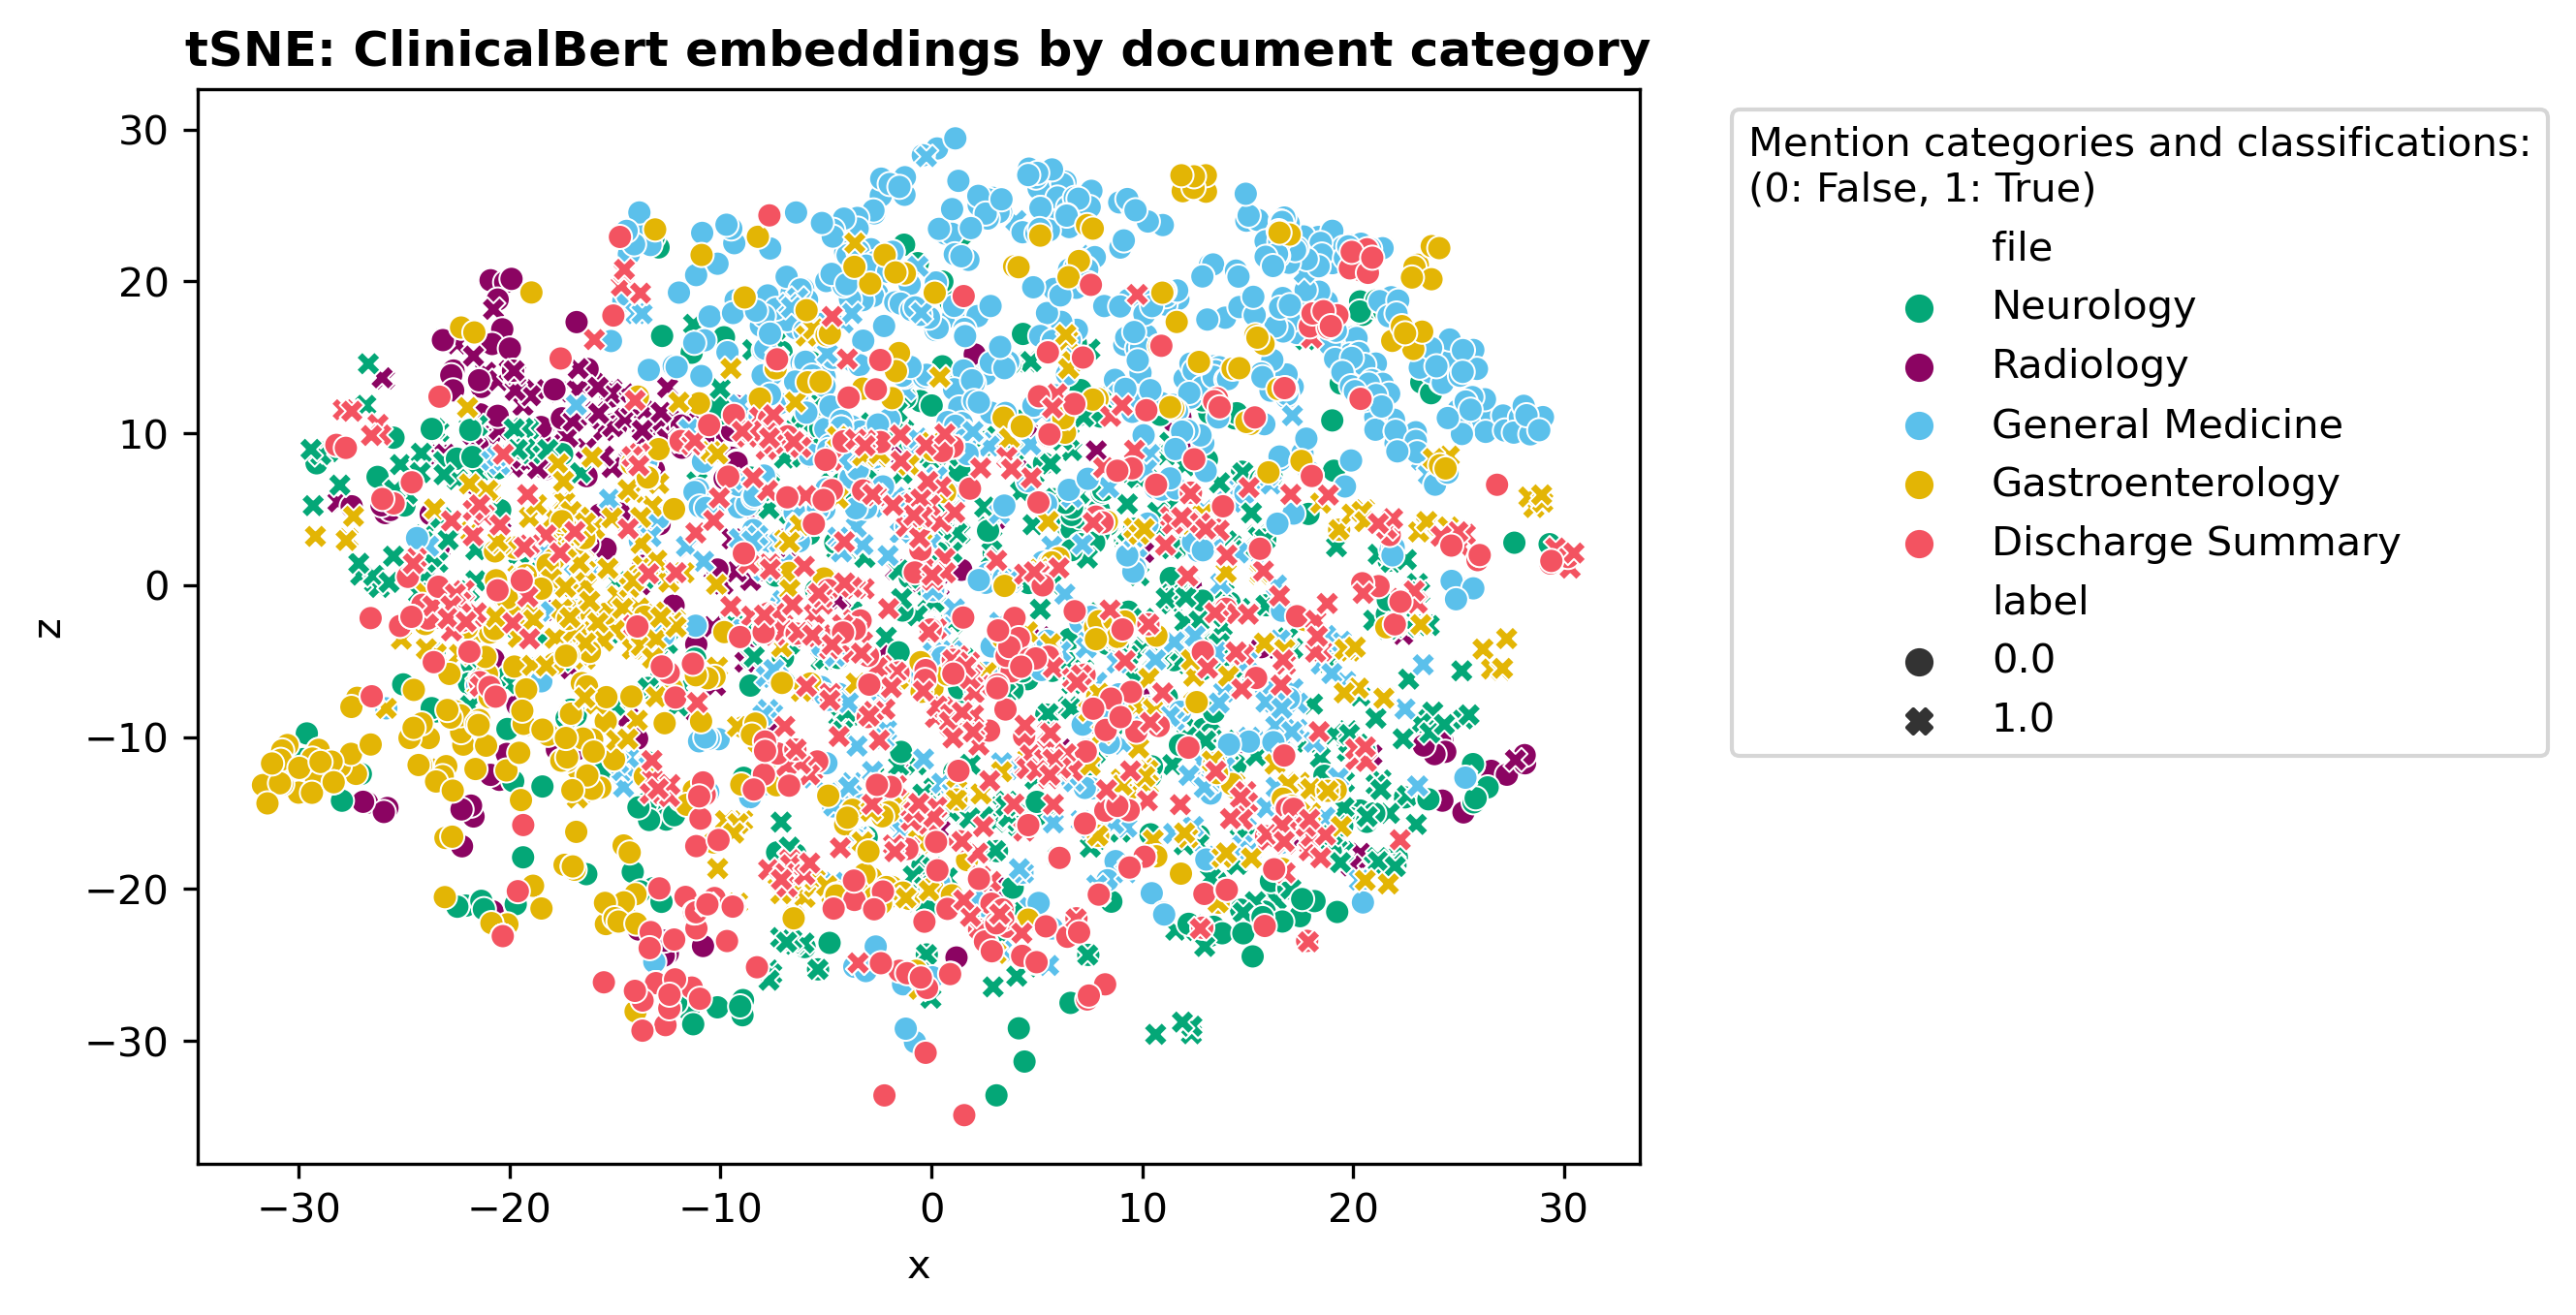

In [50]:
# Generate tSNE plot - ClinicalBert embeddings coloured by sentence categories ('general medicine' etc)

colours = ['#04A777', '#8B0462', '#5BC0EB', '#E3B505', '#F35361']

fig = plt.figure(dpi=300) 
plt.title("tSNE: ClinicalBert embeddings by document category", 
          fontsize=12, fontweight='bold')
scatterplot = sns.scatterplot(data=df_pubmed,x='x',y='z',hue='file', palette = colours, style=df['label'])
plt.legend(title="Mention categories and classifications:\n(0: False, 1: True)", bbox_to_anchor = [1.05, 1]);

In [51]:
# Examine false phenotypes mentions by category

df[df['label']==0].file.value_counts()

General Medicine     710
Neurology            351
Gastroenterology     348
Discharge Summary    300
Radiology            159
Name: file, dtype: int64

In [52]:
# Examine true phenotypes mentions by category

df[df['label']==1].file.value_counts()

Neurology            521
Discharge Summary    403
Gastroenterology     339
General Medicine     292
Radiology            126
Name: file, dtype: int64

In [53]:
# Examine statistics for sentence lengths

df_sent['sent_len'] = df_sent["enclosing_sentence"].apply(lambda x: len(x.split()))

df_sent.sent_len.describe()

count    3549.000000
mean       16.602705
std        12.253014
min         1.000000
25%         8.000000
50%        14.000000
75%        22.000000
max        81.000000
Name: sent_len, dtype: float64

In [54]:
# Examine statistics for sentence lengths for sentences containing false mentions

df_sent[df_sent.label == 0].sent_len.describe()

count    1868.000000
mean       15.684690
std        11.749467
min         1.000000
25%         7.000000
50%        13.000000
75%        21.000000
max        81.000000
Name: sent_len, dtype: float64

In [55]:
# Examine statistics for sentence lengths for sentences containing true mentions

df_sent[df_sent.label == 1].sent_len.describe()

count    1681.000000
mean       17.622844
std        12.715310
min         1.000000
25%         9.000000
50%        15.000000
75%        23.000000
max        80.000000
Name: sent_len, dtype: float64

# 2. DATA PRE-PROCESSING <a id="6"></a>
- - - 


In [56]:
# Imports

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from math import log2

- - -

## Data partitioning <a id="7"></a>


In [57]:
# Select label and features as dataframes y and X, respectively

X = df_sent.drop('label', axis=1)
y = df_sent['label']

In [353]:
# Perform train-test splits to generate training set (60%), validation set (20%) and hold-out testing set (20%) 
# to allow comparison of models (10-fold cross validation will be used for training and optimisation of random 
# forest model) 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [60]:
# Separate into datasets containing Bert and ClinicalBERT embeddings:

X_train_B = X_train['bert']
X_train_C = X_train['clin']

X_val_B = X_val['bert']
X_val_C = X_val['clin']

X_test_B = X_test['bert']
X_test_C = X_test['clin']

In [61]:
# Check degree of imbalance in training data

print(f"Percentage true Phenotypes mentions in training data:\n{sum(y_train)*100/len(y_train):.2f}%\n")

print(f"Number of instances of true mentions:\n{int(len(y_train)-sum(y_train))}\n")
print(f"Number of instances of false mentions:\n{int(sum(y_train))}")

Percentage true Phenotypes mentions in training data:
47.06%

Number of instances of true mentions:
1127

Number of instances of false mentions:
1002


In [62]:
# Examine numbers of true and false Phenotypes mentions in validation dataset

print(f"Percentage true Phenotypes mentions in validation data:\n{sum(y_val)*100/len(y_val):.2f}%\n")

print(f"Number of instances of true mentions:\n{int(len(y_val)-sum(y_val))}\n")
print(f"Number of instances of false mentions:\n{int(sum(y_val))}")

Percentage true Phenotypes mentions in validation data:
49.44%

Number of instances of true mentions:
359

Number of instances of false mentions:
351


In [63]:
# Examine numbers of true and false Phenotypes mentions in hold-out testing dataset

print(f"Percentage true Phenotypes mentions in testing data:\n{sum(y_test)*100/len(y_test):.2f}%\n")

print(f"Number of instances of true mentions:\n{int(len(y_test)-sum(y_test))}\n")
print(f"Number of instances of false mentions:\n{int(sum(y_test))}")

Percentage true Phenotypes mentions in testing data:
46.20%

Number of instances of true mentions:
382

Number of instances of false mentions:
328


In [64]:
# Examine numbers of unique true and false Phenotypes mentions in training dataset

train_idx = X_train.index.to_list()
temp_df = df_sent[df_sent.index.isin(train_idx)]

print("Unique Phenotypes mentions in training data:")
print('-'*20)
print(f"True mentions: {temp_df[temp_df['label'] == 1].text.nunique()}")
print(f"False mentions: {temp_df[temp_df['label'] == 0].text.nunique()}\n")
print(f"Total: {temp_df.text.nunique()}")

Unique Phenotypes mentions in training data:
--------------------
True mentions: 535
False mentions: 442

Total: 838


In [65]:
# Examine numbers of unique true and false Phenotypes mentions in validation dataset

val_idx = X_val.index.to_list()
temp_df = df_sent[df_sent.index.isin(val_idx)]

print("Unique Phenotypes mentions in validation data:")
print('-'*20)
print(f"True mentions: {temp_df[temp_df['label'] == 1].text.nunique()}")
print(f"False mentions: {temp_df[temp_df['label'] == 0].text.nunique()}\n")
print(f"Total: {temp_df.text.nunique()}")

Unique Phenotypes mentions in validation data:
--------------------
True mentions: 246
False mentions: 208

Total: 405


In [66]:
# Examine numbers of unique true and false Phenotypes mentions in testing dataset

test_idx = X_test.index.to_list()
temp_df = df_sent[df_sent.index.isin(test_idx)]

print("Unique Phenotypes mentions in testing data:")
print('-'*20)
print(f"True mentions: {temp_df[temp_df['label'] == 1].text.nunique()}")
print(f"False mentions: {temp_df[temp_df['label'] == 0].text.nunique()}\n")
print(f"Total: {temp_df.text.nunique()}")

Unique Phenotypes mentions in testing data:
--------------------
True mentions: 243
False mentions: 208

Total: 402


In [67]:
# Calculate entropy for training data as a measure of imbalance (the closer to 1, the more balanced the dataset)

pos_men_prop = sum(y_train)/len(y_train)
neg_men_prop = 1 - pos_men_prop

print(f"Entropy:\n{-((neg_men_prop * log2(neg_men_prop)) + (pos_men_prop * log2(pos_men_prop))):.4f}") 

Entropy:
0.9975


# 3. MODEL ONE: RANDOM FOREST CLASSIFIER USING BERT EMBEDDINGS  <a id="8"></a>
- - - 

## Hyperparameter optimisation and supervised learning on training data

In [68]:
# Imports

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, \
        roc_auc_score
import time
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA

In [69]:
# Create function to generate trained and optimised RF model via grid search with 10-fold cross validation
# Create inputs for desired training datasets, random state to ensure reproducability and desired scoring 
# function (macro F1 and ROC AUC will be used in this analysis)

def run_randomforest(X_train, y_train, random_state, scoring_function):
    
    """
    Function for training of random forest model, with grid search and 10-fold cross-validation. Takes as
    inputs training data (X, y), random-state and scoring function. Returns optimised model
    """
    
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    
    # Extract training data as arrays
    X_train = X_train.values
    y_train = y_train.values

    # Initialise model
    rf = RandomForestClassifier(random_state=random_state)
    
    # Generate grid of tunable hyperparameters to allow selection of optimal combination
    param_grid = {'max_depth': [10, 25, 50], 
                  'n_estimators': [150, 200, 250],    
                  'criterion': ('gini', 'entropy'),
                 'max_features': ['sqrt', 'log2']}
    
    start = time.time()
    
    # Perform grid-search with 10-fold cross-validation and select best model. Use all available cores
    search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          scoring=scoring_function, n_jobs=-1, cv=10)
    search.fit(list(X_train), y_train)
    model = search.best_estimator_
    end = time.time()
    
    # Print time taken to train model
    print(f"Time elapsed:\n{((end-start)/60):.0f} mins\n")
    print("-" * 55,"\n")

    # Print results for best model: best parameters, best score +/- SD, scores for each cross-validation fold 
    # Classification report for best model using full training dataset
    print(f"Best parameters:\n{search.best_params_}\n")
    print("-" * 55,"\n")
    
    best_iter_idx = (search.cv_results_['rank_test_score'][0]) - 1
    print(f"Best score ({scoring_function}):\n{search.best_score_:.4f} +/- {search.cv_results_['std_test_score'][best_iter_idx]:.4f}\n")
    print("-" * 55,"\n")

    iter_scores = []
    for i in range(1,10):
        iter_scores.append(np.round(search.cv_results_[f"split{i}_test_score"][best_iter_idx],4))
    print(f"Scores by cross-validation fold:\n{iter_scores}")
    print("-" * 55,"\n")
    
    print("Classification report for best estimator (full training dataset):")
    print(classification_report(list(y_train), search.best_estimator_.predict(list(X_train))))
    
    # Output best model
    return model


In [70]:
# Perform grid search to identify optimal hyperparameters for random forest model trained on base BERT embeddings,
# using F1 macro average as evaluation metric. Select best trained model

model_rf_B = run_randomforest(X_train_B, y_train, 42, 'f1_macro')

Time elapsed:
13 mins

------------------------------------------------------- 

Best parameters:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 250}

------------------------------------------------------- 

Best score (f1_macro):
0.8087 +/- 0.0165

------------------------------------------------------- 

Scores by cross-validation fold:
[0.78, 0.7975, 0.8119, 0.7872, 0.81, 0.7955, 0.8396, 0.7951, 0.7964]
------------------------------------------------------- 

Classification report for best estimator (full training dataset):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1127
         1.0       0.99      0.98      0.99      1002

    accuracy                           0.99      2129
   macro avg       0.99      0.99      0.99      2129
weighted avg       0.99      0.99      0.99      2129



In [71]:
# Examine feature importances

sorted(list(model_rf_B.feature_importances_))

[0.0004834806219715316,
 0.000528913154033264,
 0.0005364944215321615,
 0.0005428269613549566,
 0.0005476845915694368,
 0.0005687931768346792,
 0.0005751346347228895,
 0.0005834259509159546,
 0.0005870869771496698,
 0.0005919548140266897,
 0.0006011396593928093,
 0.0006048952255810894,
 0.0006065892644491086,
 0.0006131491044605675,
 0.0006132419018511945,
 0.0006186279503131932,
 0.0006186424207283752,
 0.0006255535628670883,
 0.0006257456464950741,
 0.0006269323159561809,
 0.0006303560079540157,
 0.0006352456970423551,
 0.0006386455315941802,
 0.0006386671143343356,
 0.0006481362423632142,
 0.0006510141619693583,
 0.000657849134607313,
 0.0006593290994443704,
 0.0006598914271074135,
 0.0006599543199660087,
 0.0006630413114625121,
 0.0006651116824245231,
 0.0006744164937490258,
 0.0006749703368425058,
 0.0006782279932088021,
 0.0006783407776972612,
 0.0006810533340428479,
 0.0006836640001454614,
 0.0006847393948906553,
 0.0006847914598940613,
 0.0006867418941548895,
 0.000687429795791

In [72]:
# Perform grid search to identify optimal hyperparameters for random forest model trained on base BERT embeddings,
# using ROC AUC as evaluation metric. Select best trained model

model_rf_B_roc = run_randomforest(X_train_B, y_train, 42, 'roc_auc')

Time elapsed:
14 mins

------------------------------------------------------- 

Best parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 250}

------------------------------------------------------- 

Best score (roc_auc):
0.8854 +/- 0.0198

------------------------------------------------------- 

Scores by cross-validation fold:
[0.8869, 0.8485, 0.8775, 0.8673, 0.8989, 0.8933, 0.9088, 0.89, 0.8594]
------------------------------------------------------- 

Classification report for best estimator (full training dataset):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1127
         1.0       0.99      0.98      0.98      1002

    accuracy                           0.99      2129
   macro avg       0.99      0.99      0.99      2129
weighted avg       0.99      0.99      0.99      2129



In [73]:
# Create function to plot out-of-bag error

def plot_oob_error(criterion, max_features, random_state, X, y, export_figures=False):
    
    """
    Function to evaluate and plot error rate (in terms of out-of-bag error) versus number of estimators (50-200)
    at different max_depth values (5, 10, 25, 50). Inputs: training dataset, desired splitting criterion, 
    maximum number of features and random state to ensure reproducability. Outputs graphed results
    
    """
   
    X = X.values
    y = y.values

    # Create lists for each max_depth tested
    errors_depth5 = []
    errors_depth10 = []
    errors_depth25 = []
    errors_depth50 = []
    errors_depth100 = []
    errors = [errors_depth5, errors_depth10, errors_depth25, errors_depth50, errors_depth100]
    
    # Set model hyperparameters to specified splitting criterion and maximum number of features
    hparams = {'criterion':criterion, 'max_features':max_features}
    # Create lists of maximum depths and numbers of estimators to be evaluated
    depth = [5, 10, 25, 50, 100]

    # For each combination of maximum depth and number of estimators, run model and calculate OOB error rates, 
    # appending values to the relevant list
    for d in range(len(depth)): 
        for i in range(50,351,5):
            rf = RandomForestClassifier(n_estimators = i, **hparams, max_depth = depth[d], 
                                        random_state=random_state, oob_score=True)
            rf.fit(X=list(X), y=y)
            errors[d].append(1-rf.oob_score_)
            
    return errors


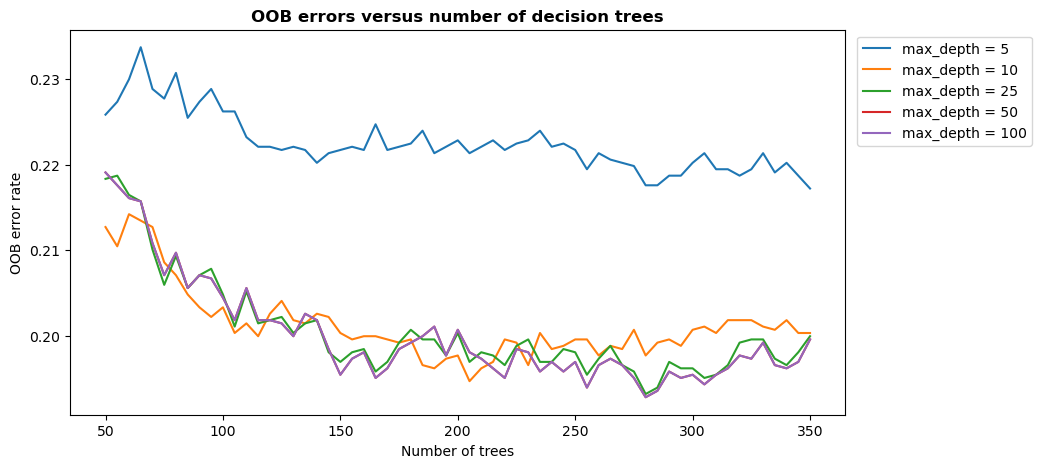

In [81]:
# Plot and examine out-of-bag error versus number of decision trees at max_depth of 5, 10, 25, 50 and 100 for 
# RF model trained on base BERT embeddings

plot_oob_error('entropy', 'sqrt', 42, X_train_B, y_train)

# Plot results
fig, axes = plt.subplots(figsize=(10,5))
plt.title("OOB errors versus number of decision trees", fontsize=12, fontweight='bold')
plt.plot(range(50,351,5), errors[0], label='max_depth = 5')
plt.plot(range(50,351,5), errors[1], label='max_depth = 10')
plt.plot(range(50,351,5), errors[2], label='max_depth = 25')
plt.plot(range(50,351,5), errors[3], label='max_depth = 50')
plt.plot(range(50,351,5), errors[4], label='max_depth = 100')
plt.ylabel('OOB error rate', fontsize=10)
plt.xlabel('Number of trees', fontsize=10)

# Add/position legend
plt.legend(bbox_to_anchor = [1.25, 1])

In [74]:
# Perform grid search to identify optimal hyperparameters for random forest model trained on ClinicalBERT 
# embeddings, using F1 macro average as evaluation metric and select best trained model

model_rf_C = run_randomforest(X_train_C, y_train, 42, 'f1_macro')

Time elapsed:
14 mins

------------------------------------------------------- 

Best parameters:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'n_estimators': 150}

------------------------------------------------------- 

Best score (f1_macro):
0.8292 +/- 0.0145

------------------------------------------------------- 

Scores by cross-validation fold:
[0.7929, 0.8357, 0.8213, 0.8168, 0.8166, 0.8253, 0.8168, 0.8345, 0.7922]
------------------------------------------------------- 

Classification report for best estimator (full training dataset):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1127
         1.0       0.99      0.98      0.99      1002

    accuracy                           0.99      2129
   macro avg       0.99      0.99      0.99      2129
weighted avg       0.99      0.99      0.99      2129



In [75]:
# Perform grid search to identify optimal hyperparameters for random forest model trained on ClinicalBERT 
# embeddings,using ROC AUC as evaluation metric and select best trained model

model_rf_C_roc = run_randomforest(X_train_C, y_train, 42, 'roc_auc')

Time elapsed:
15 mins

------------------------------------------------------- 

Best parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150}

------------------------------------------------------- 

Best score (roc_auc):
0.9064 +/- 0.0169

------------------------------------------------------- 

Scores by cross-validation fold:
[0.8839, 0.8894, 0.885, 0.8769, 0.9, 0.9103, 0.9129, 0.9081, 0.8733]
------------------------------------------------------- 

Classification report for best estimator (full training dataset):
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1127
         1.0       0.98      0.99      0.98      1002

    accuracy                           0.98      2129
   macro avg       0.98      0.98      0.98      2129
weighted avg       0.98      0.98      0.98      2129



In [88]:
# Plot and examine out-of-bag error versus number of decision trees at max_depth of 5, 10, 25, 50 and 100

errors = plot_oob_error('entropy', 'sqrt', 42, X_train_C, y_train)

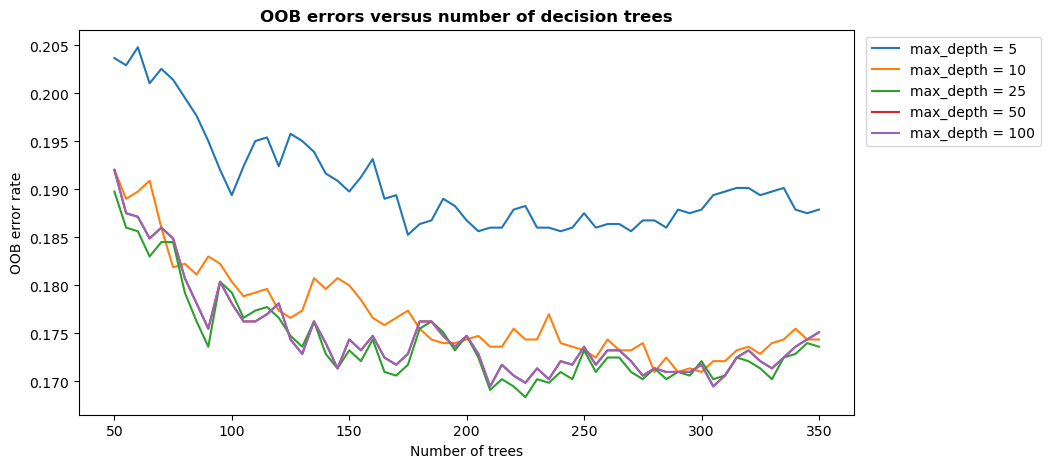

In [92]:
# Plot results
fig, axes = plt.subplots(figsize=(10,5))
plt.title("OOB errors versus number of decision trees", fontsize=12, fontweight='bold')
plt.plot(range(50,351,5), errors[0], label='max_depth = 5')
plt.plot(range(50,351,5), errors[1], label='max_depth = 10')
plt.plot(range(50,351,5), errors[2], label='max_depth = 25')
plt.plot(range(50,351,5), errors[3], label='max_depth = 50')
plt.plot(range(50,351,5), errors[4], label='max_depth = 100')
plt.ylabel('OOB error rate', fontsize=10)
plt.xlabel('Number of trees', fontsize=10)

# Add/position legend
plt.legend(bbox_to_anchor = [1.25, 1])
    
# Allow export of figures, if desired/necessary
fig.savefig("oob_plt.png", bbox_inches='tight');

- - -

## Model evaluation <a id="9"></a>

In [76]:
# Create function to evaluate trained models using validation data, with inputs for desired validation datasets 
# Create option to export figures for display elsewhere (default no export)

def evaluate(model, X_val, y_val, export_figures=False):
    
    # Make predictions using trained model and validation data
    X_val = X_val.values
    y_val = y_val.values
    y_pred = model.predict(list(X_val))
    
    # Print classification report and ROC AUC values
    print(f"Classification report:\n\n{classification_report(y_val, y_pred, digits=4)}\n")
    print("-" * 55,"\n")
    print(f"ROC AUC:\n{roc_auc_score(y_val, y_pred):.4f}\n\n")
    print("-" * 55,"\n")

    # Generate confusion matrix and ROC curve
    fig, axes = plt.subplots(2,1, figsize=(5,10))
    axes[0].set_title(f"Confusion matrix",fontsize=12, fontweight='bold')
    axes[1].set_title(f"ROC curve",fontsize=12, fontweight='bold')
    fig.subplots_adjust(hspace=0.3, wspace=0.5)
    axes[0].grid(False)

    # Generate and plot confusion matrix
    matrix = confusion_matrix(y_val, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
    disp.plot(ax=axes[0]);
    
    # Plot ROC curve, with line indicating results for results of random guessing (TPR=FPR)
    x = np.linspace(0,1,10)
    axes[1].plot(x, x, c='r', ls = ':', label='Random')
    RocCurveDisplay.from_predictions(y_val, y_pred, ax=axes[1]);

    # Allow export of figures, if desired/necessary
    if export_figures:
        now = datetime.datetime.now()
        fig.savefig(f"Confusion matrix and ROC plots_{now.strftime('%Y-%m-%d_%H-%M')}.png", bbox_inches='tight')

Classification report:

              precision    recall  f1-score   support

         0.0     0.8118    0.8412    0.8263       359
         1.0     0.8314    0.8006    0.8157       351

    accuracy                         0.8211       710
   macro avg     0.8216    0.8209    0.8210       710
weighted avg     0.8215    0.8211    0.8210       710


------------------------------------------------------- 

ROC AUC:
0.8209


------------------------------------------------------- 



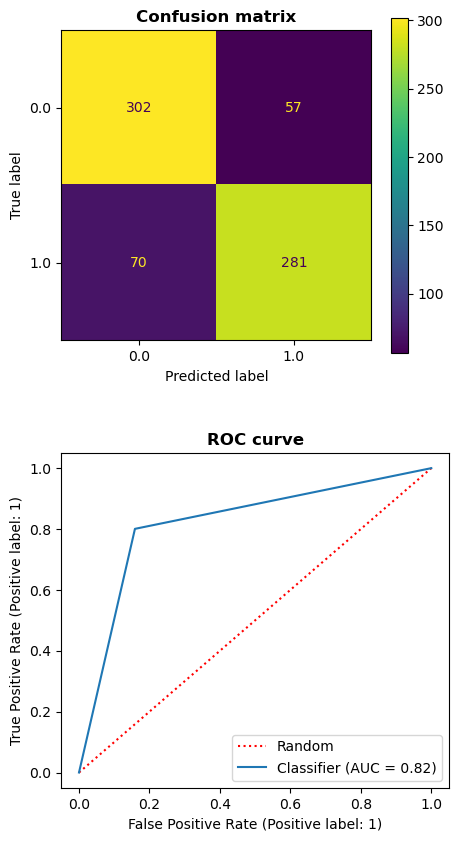

In [77]:
# View classification report, ROC AUC, confusion matrix and ROC curve for random forest model trained on base BERT
# embeddings, with hyperparameters selected using F1 macro average as evaluation metric

evaluate(model_rf_B, X_val_B, y_val)

Classification report:

              precision    recall  f1-score   support

         0.0     0.8214    0.8329    0.8271       359
         1.0     0.8266    0.8148    0.8207       351

    accuracy                         0.8239       710
   macro avg     0.8240    0.8238    0.8239       710
weighted avg     0.8240    0.8239    0.8239       710


------------------------------------------------------- 

ROC AUC:
0.8238


------------------------------------------------------- 



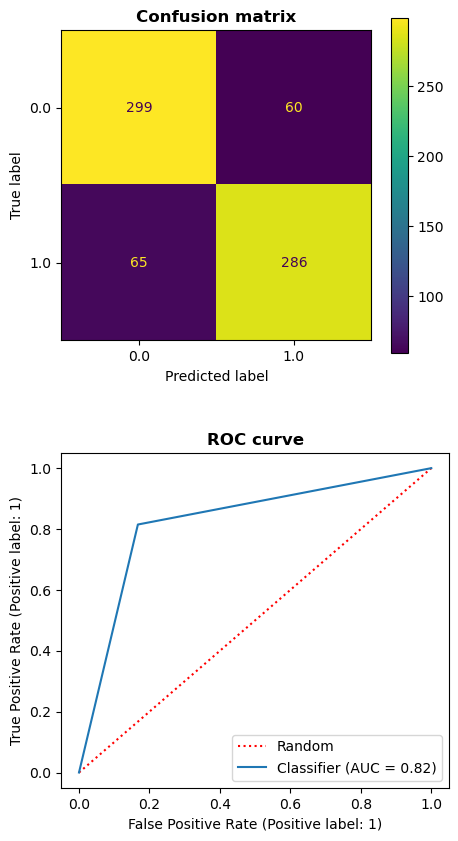

In [78]:
# View classification report, ROC AUC, confusion matrix and ROC curve for random forest model trained on base BERT 
# embeddings,with hyperparameters selected using ROC-AUC as evaluation metric

evaluate(model_rf_B_roc, X_val_B, y_val)

Classification report:

              precision    recall  f1-score   support

         0.0     0.8365    0.8552    0.8457       359
         1.0     0.8484    0.8291    0.8386       351

    accuracy                         0.8423       710
   macro avg     0.8425    0.8421    0.8422       710
weighted avg     0.8424    0.8423    0.8422       710


------------------------------------------------------- 

ROC AUC:
0.8421


------------------------------------------------------- 



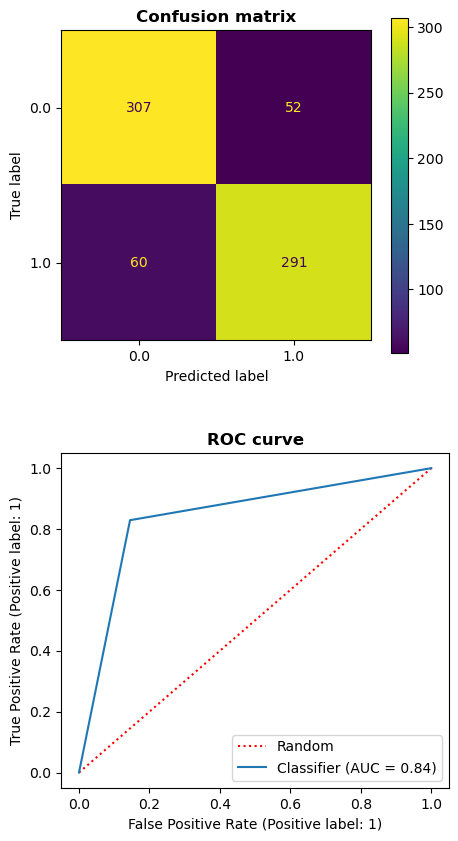

In [79]:
# View classification report, ROC AUC, confusion matrix and ROC curve for random forest model trained on 
# ClinicalBERT embeddings, with hyperparameters selected using F1 macro average as evaluation metric

evaluate(model_rf_C, X_val_C, y_val)

Classification report:

              precision    recall  f1-score   support

         0.0     0.8446    0.8329    0.8387       359
         1.0     0.8315    0.8433    0.8373       351

    accuracy                         0.8380       710
   macro avg     0.8380    0.8381    0.8380       710
weighted avg     0.8381    0.8380    0.8380       710


------------------------------------------------------- 

ROC AUC:
0.8381


------------------------------------------------------- 



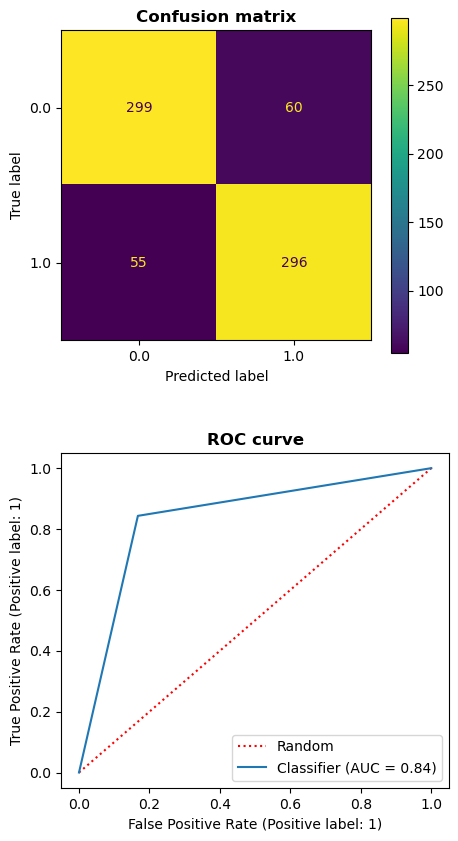

In [80]:
# View classification report, ROC AUC, confusion matrix and ROC curve for random forest model trained on 
# ClinicalBERT embeddings with hyperparameters selected using ROC-AUC as evaluation metric

evaluate(model_rf_C_roc, X_val_C, y_val)

In [81]:
# Calculate scoring for optimised models over a further 4 runs:
# Base Bert model

seed = [1, 3, 9, 27]

for i in range(len(seed)): 
    rf = RandomForestClassifier(max_depth=50, n_estimators=250, criterion='entropy',
                                max_features='sqrt', random_state=seed[i])
    model = rf.fit(list(X_train_B), y_train)
    preds = model.predict(list(X_val_B))

    print(f"Run {i}:")
    print('-'*20)
    print(f"Classification report:\n\n{classification_report(y_val, preds, digits=4)}\n")
    print("-" * 55,"\n")
    print(f"ROC AUC:\n{roc_auc_score(y_val, preds):.4f}\n\n")
    print("-" * 55,"\n")


Run 0:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8177    0.8496    0.8333       359
         1.0     0.8398    0.8063    0.8227       351

    accuracy                         0.8282       710
   macro avg     0.8287    0.8279    0.8280       710
weighted avg     0.8286    0.8282    0.8281       710


------------------------------------------------------- 

ROC AUC:
0.8279


------------------------------------------------------- 

Run 1:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8065    0.8357    0.8208       359
         1.0     0.8254    0.7949    0.8099       351

    accuracy                         0.8155       710
   macro avg     0.8159    0.8153    0.8153       710
weighted avg     0.8158    0.8155    0.8154       710


------------------------------------------------------- 

ROC AUC:
0.8153


------------------------------

In [130]:
# Calculate scoring for optimised models over a further 4 runs:
# ClinicalBert model

seed = [1, 3, 9, 27]

for i in range(len(seed)): 
    rf = RandomForestClassifier(max_depth=50, n_estimators=150, criterion='entropy',
                                max_features='log2', random_state=seed[i])
    model = rf.fit(list(X_train_C), y_train)
    preds = model.predict(list(X_val_C))

    print(f"Run {i}:")
    print('-'*20)
    print(f"Classification report:\n\n{classification_report(y_val, preds, digits=4)}\n")
    print("-" * 55,"\n")
    print(f"ROC AUC:\n{roc_auc_score(y_val, preds):.4f}\n\n")
    print("-" * 55,"\n")


Run 0:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8264    0.8357    0.8310       359
         1.0     0.8300    0.8205    0.8252       351

    accuracy                         0.8282       710
   macro avg     0.8282    0.8281    0.8281       710
weighted avg     0.8282    0.8282    0.8282       710


------------------------------------------------------- 

ROC AUC:
0.8281


------------------------------------------------------- 

Run 1:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8402    0.8496    0.8449       359
         1.0     0.8444    0.8348    0.8395       351

    accuracy                         0.8423       710
   macro avg     0.8423    0.8422    0.8422       710
weighted avg     0.8423    0.8423    0.8422       710


------------------------------------------------------- 

ROC AUC:
0.8422


------------------------------

In [406]:
# Examine model perfomances by document category:
# Create a dataframe containing predicted probabilities, labels and document types for best-performing 
# random forest classifiers, together with the ground-truth label

df_rf_preds = pd.DataFrame()

# Append base Bert and ClinicalBERT predictions and probibilities for validation dataset
df_rf_preds['Bert_pred'] = model_rf_B_roc.predict(list(X_val_B))
df_rf_preds['Bert_prob'] = [item[0] for item in model_rf_B_roc.predict_proba(list(X_val_B))]
df_rf_preds['clin_pred'] = model_rf_C.predict(list(X_val_C))
df_rf_preds['clin_prob'] = [item[0] for item in model_rf_C.predict_proba(list(X_val_C))]

# Append label and document categories
df_rf_preds['Label'] = list(y_val)
df_rf_preds['File'] = X_val['file'].to_list()
with warnings.catch_warnings(record=True):
    df_rf_preds['Type'] = df_rf_preds['File'].str.replace('\d+', '').str.replace('_', '').str.replace('.txt', '')  

# Add columns to indicate correct predictions made by each model
df_rf_preds['Bert_correct'] = np.where(df_rf_preds['Bert_pred'] == df_rf_preds['Label'], 1, 0)
df_rf_preds['clin_correct'] = np.where(df_rf_preds['clin_pred'] == df_rf_preds['Label'], 1, 0)

df_rf_preds.head()

Bert_pred  Bert_prob  clin_pred  clin_prob  Label  \
0        0.0   0.847840        0.0   0.870667    0.0   
1        0.0   0.940974        0.0   0.953333    0.0   
2        0.0   0.689265        0.0   0.693333    0.0   
3        0.0   0.799025        0.0   0.853333    0.0   
4        1.0   0.275468        1.0   0.246667    1.0   

                         File               Type  Bert_correct  clin_correct  
0  3904_Discharge Summary.txt  Discharge Summary             1             1  
1   3239_General Medicine.txt   General Medicine             1             1  
2   3245_General Medicine.txt   General Medicine             1             1  
3   3239_General Medicine.txt   General Medicine             1             1  
4   3493_Gastroenterology.txt   Gastroenterology             1             1

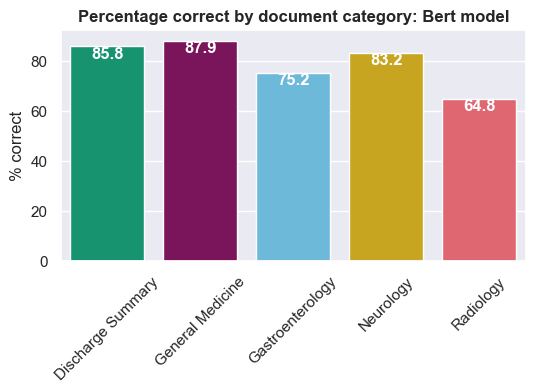

In [407]:
# Plot percentage correct by document type: Bert model

perc_dict = {}

# Append to dictionary document types (keys) and percentages correct (values)
doc_types = df_rf_preds.Type.unique()
for doc_type in doc_types:
    perc_correct = (df_rf_preds[df_rf_preds.Type==doc_type].Bert_correct.sum() / len(
    df_rf_preds[df_rf_preds.Type==doc_type]))*100
    perc_dict[doc_type] = perc_correct
  
    # Generate barplot
fig, axes = plt.subplots(figsize=(6,3))
colours = ['#04A777', '#8B0462', '#5BC0EB', '#E3B505', '#F35361']
plt.title("Percentage correct by document category: Bert model", fontsize=12, fontweight='bold')
plt.xticks(rotation = 45)
plt.ylabel('% correct')
sns.barplot(x=list(perc_dict.keys()), y=list(perc_dict.values()), palette=colours);

# Label barplot with percentage values
for p, perc in zip(axes.patches, list(perc_dict.values())):
    axes.annotate(np.round(perc,1), xy=(p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='top', 
                  color='w', weight='bold')

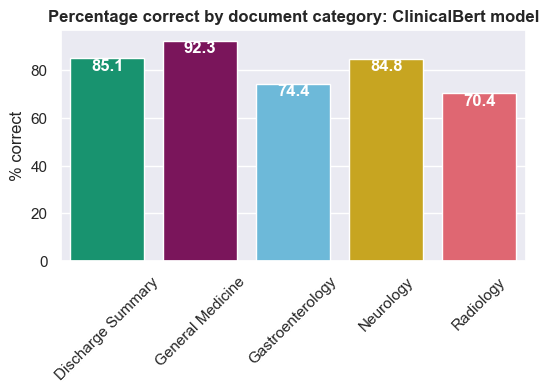

In [408]:
# Plot percentage correct by document type: ClinicalBert-RF model

perc_dict = {}
doc_types = df_rf_preds.Type.unique()

# Append to dictionary document types (keys) and percentages correct (values)
for doc_type in doc_types:
    perc_correct = (df_rf_preds[df_rf_preds.Type==doc_type].clin_correct.sum() / len(
    df_rf_preds[df_rf_preds.Type==doc_type]))*100
    perc_dict[doc_type] = perc_correct
  
    # Generate barplot
fig, axes = plt.subplots(figsize=(6,3))
colours = ['#04A777', '#8B0462', '#5BC0EB', '#E3B505', '#F35361']
plt.title("Percentage correct by document category: ClinicalBert model", fontsize=12, fontweight='bold')
plt.xticks(rotation = 45)
plt.ylabel('% correct')
sns.barplot(x=list(perc_dict.keys()), y=list(perc_dict.values()), palette=colours)

# Label barplot with percentage values
for p, perc in zip(axes.patches, list(perc_dict.values())):
    axes.annotate(np.round(perc,1), xy=(p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='top', 
                  color='w', weight='bold');

In [162]:
# Check unique mentions by document type

with warnings.catch_warnings(record=True):
    df_sent['Type'] = df_sent['file'].str.replace('\d+', '').str.replace('_', '').str.replace('.txt', '') 

print('Unique mentions:')
print(f"Discharge summary: {df_sent[df_sent.Type == 'Discharge Summary'].text.nunique()}")
print(f"General medicine: {df_sent[df_sent.Type == 'General Medicine'].text.nunique()}")
print(f"Gastroenterology: {df_sent[df_sent.Type == 'Gastroenterology'].text.nunique()}")
print(f"Neurology: {df_sent[df_sent.Type == 'Neurology'].text.nunique()}")
print(f"Radiology: {df_sent[df_sent.Type == 'Radiology'].text.nunique()}")

Unique mentions:
Discharge summary: 308
General medicine: 451
Gastroenterology: 288
Neurology: 391
Radiology: 154


- - -

## Further optimisation: PCA-transformation of features to reduce dimensionality  <a id="10"></a>

In [131]:
# As examination of feature importances suggested a large number of embedding vectors did not contribute much
# to decision tree classification, examine RF performance following dimensionality reduction via PCA
# Although not strictly necessary, in order to prevent small fluctuations in results obtained, and ensure 
# identical outputs, random state was specified

pca = PCA(random_state=101)
X_train_pca = pca.fit_transform(list(X_train_B))

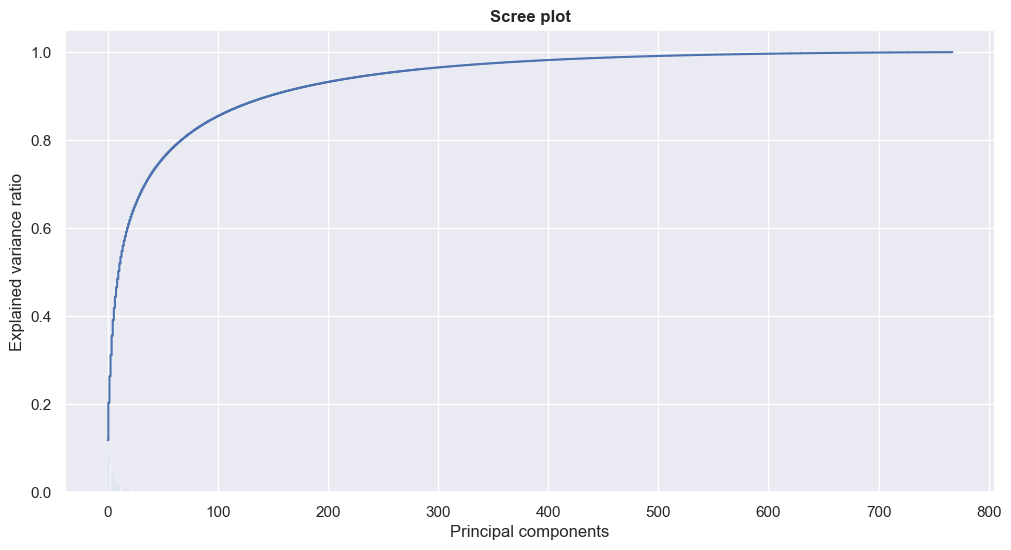

In [132]:
# Generate and display PCA scree plot

plt.title("Scree plot", fontweight='bold')
plt.bar(np.arange(768), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(np.arange(768), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components');

In [133]:
# Since the first 200 principal components appear to account for ~90% variance, perform PCA with 200 components
# and extract to new dataframes for train and validation data

pca = PCA(n_components=200, random_state=42)
 
# Fit and transform data
pca_arr_train = pca.fit_transform(list(X_train_B))
pca_arr_val = pca.transform(list(X_val_B))
 
# Create dataframes
components = ['PC'+str(i) for i in range(1,201)]
pca_train = pd.DataFrame(data=pca_arr_train, columns=components)
pca_val = pd.DataFrame(data=pca_arr_val, columns=components)
 
pca_train.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.380284  7.471974  2.039388 -0.792622  5.236039  1.117186  2.957113   
1 -3.068908  2.030924  0.216683 -1.749661  0.866778 -1.946320 -0.108444   
2  0.541487 -1.368128 -2.137146 -0.162636  0.378618 -0.711425 -0.757842   
3  2.259056 -1.807718 -1.855510 -0.898585  0.668161 -1.044762 -0.988481   
4  0.401728 -2.933037  0.539778 -2.746674  1.492492  0.185685  3.564772   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  4.231227  5.864897 -2.208920  1.211967  0.107100 -1.770650  1.235321   
1 -0.344105 -1.409850  1.363134  0.786760 -0.510136  0.076229 -0.188603   
2 -0.164879 -0.101451  0.200594 -0.365369 -1.601681  2.316337 -0.172368   
3 -0.969677  1.713954 -0.200773 -1.292415  0.745017 -0.099350  0.645480   
4  0.334006 -0.233132  0.127599  0.183767  0.876830 -1.461251  1.411672   

       PC15      PC16      PC17      PC18      PC19      PC20      PC21  \
0 -1.221632 -0.277873  1.703815  1.082447  1.912525  0.808171 -1.267942   
1  1.308236 -1.270998  1.326740  0.676575  0.077101 -0.005049 -0.489622   
2 -0.426978  0.979215  0.683563 -0.230031 -0.070193  0.164762  0.303125   
3 -1.340955  0.482560 -0.370206  1.241987  0.334559 -0.017823  0.091561   
4 -0.451648  0.106994 -1.755085 -0.266874  0.013554  1.438953 -0.391341   

       PC22      PC23      PC24      PC25      PC26      PC27      PC28  \
0  0.188833  0.575777 -0.720687  0.645512  0.111079  0.522287 -1.416300   
1  0.239449  0.142382  0.108157  0.768775 -0.620982 -0.508415 -0.702440   
2  1.179753 -0.345584 -0.383426 -0.551981  0.135109  0.001856  0.069865   
3 -0.316472  0.686635 -0.461411 -0.160480 -0.453872 -0.070433 -0.296465   
4 -0.398021  0.143195 -1.177477 -1.493025 -0.160910 -0.143205 -1.108333   

       PC29      PC30      PC31      PC32      PC33      PC34      PC35  \
0 -0.403699  0.113224  0.367713 -0.036825 -0.913790 -1.175804 -0.329769   
1  0.005012  0.651214  0.139751  0.237451  0.139777  0.151396 -0.161925   
2  0.743773  0.053758  0.326451  0.233188  0.648971 -1.299589 -0.104970   
3  0.074391 -0.249642 -0.240557  0.479061 -0.143199 -0.338943 -0.435827   
4  1.291356  0.153533  0.331261 -0.271853 -0.378992  0.456844 -0.213641   

       PC36      PC37      PC38      PC39      PC40      PC41      PC42  \
0 -0.535437  0.661697 -0.567834 -0.679679 -0.651144  0.182385  0.016971   
1  0.300797 -0.462924 -0.000405  0.271141 -0.387922  0.215362 -0.361444   
2 -0.730992 -0.224929 -0.491539  0.256786 -0.026186 -0.263108  0.181771   
3  0.204343 -0.344384  0.071587 -0.535608 -0.144603  0.509880 -0.435681   
4 -0.761682 -0.287650  1.200977  0.726079  0.451126  0.823144 -0.652309   

       PC43      PC44      PC45      PC46      PC47      PC48      PC49  \
0  1.168194 -0.324817  0.180522  0.407146  1.149264  0.822298  0.071240   
1  0.270913 -0.343574  0.417949  0.117783 -0.105008  0.424444 -0.001505   
2  0.177776 -0.483430  0.521995 -0.123156  0.103147 -0.002472 -0.279796   
3 -0.138658 -0.107770 -0.197672 -0.207170 -0.958232  0.646894 -0.342844   
4 -0.116800  0.303219 -0.231797 -0.305363  0.626451  0.365522  0.151900   

       PC50      PC51      PC52      PC53      PC54      PC55      PC56  \
0 -0.379866 -0.116775 -0.428044 -0.158030  0.615397  0.008846 -1.075912   
1 -0.241492 -0.188613 -0.258895 -0.008682 -0.476534 -0.008871 -0.240297   
2  0.288116  0.389017  0.183625 -0.091586 -0.838038  0.138911  0.014206   
3  0.130169 -0.146514  0.145088  0.690838 -0.276263  0.020438 -0.003129   
4  0.150225  0.553790 -0.315446  0.163443 -0.260238 -0.328542  0.060334   

       PC57      PC58      PC59      PC60      PC61      PC62      PC63  \
0 -0.372985  0.160985  0.189592  0.454851  0.191366 -0.486922  0.448972   
1  0.295437  0.117442  0.594699 -0.282115 -0.135631  0.161870  0.135826   
2  0.246874 -0.109178  0.473104  0.207621 -0.054362 -0.091820 -0.431045   
3 -0.329331 -0.097001  0.116704  0.161884 -0.222787  0.350088  0.242873   
4  0.826644 -0.247337  0.

In [134]:
# Train random forest model on features extracted via PCA, with the first 200 principal components selected 
# and macro F1 as the scoring metric

model_rf_pca = run_randomforest(pca_train, y_train, 42, 'f1_macro')

Time elapsed:
7 mins

------------------------------------------------------- 

Best parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}

------------------------------------------------------- 

Best score (f1_macro):
0.8033 +/- 0.0204

------------------------------------------------------- 

Scores by cross-validation fold:
[0.776, 0.8198, 0.7837, 0.7774, 0.7794, 0.7715, 0.8253, 0.7614, 0.7761]
------------------------------------------------------- 

Classification report for best estimator (full training dataset):
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1127
         1.0       0.98      0.98      0.98      1002

    accuracy                           0.98      2129
   macro avg       0.98      0.98      0.98      2129
weighted avg       0.98      0.98      0.98      2129



Classification report:

              precision    recall  f1-score   support

         0.0     0.7916    0.8357    0.8130       359
         1.0     0.8218    0.7749    0.7977       351

    accuracy                         0.8056       710
   macro avg     0.8067    0.8053    0.8053       710
weighted avg     0.8065    0.8056    0.8054       710


------------------------------------------------------- 

ROC AUC:
0.8053


------------------------------------------------------- 



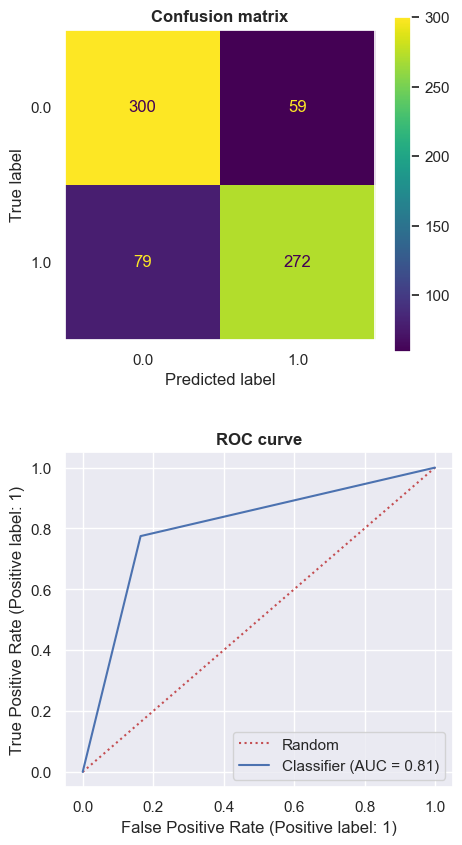

In [135]:
# Evaluate model performance: view classification report, ROC AUC, confusion matrix and ROC curve 

evaluate(model_rf_pca, pca_val, y_val)

In [136]:
# Calculate scoring for optimised models over a further 4 runs:

seed = [1, 3, 9, 27]

for i in range(len(seed)): 
    rf = RandomForestClassifier(max_depth=10, n_estimators=200, criterion='gini',
                                max_features='log2', random_state=seed[i])
    model = rf.fit(pca_train, y_train)
    preds = model.predict(pca_val)

    print(f"Run {i}:")
    print('-'*20)
    print(f"Classification report:\n\n{classification_report(y_val, preds, digits=4)}\n")
    print("-" * 55,"\n")
    print(f"ROC AUC:\n{roc_auc_score(y_val, preds):.4f}\n\n")
    print("-" * 55,"\n")


Run 0:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.7995    0.8440    0.8211       359
         1.0     0.8308    0.7835    0.8065       351

    accuracy                         0.8141       710
   macro avg     0.8151    0.8137    0.8138       710
weighted avg     0.8150    0.8141    0.8139       710


------------------------------------------------------- 

ROC AUC:
0.8137


------------------------------------------------------- 

Run 1:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8048    0.8384    0.8213       359
         1.0     0.8274    0.7920    0.8093       351

    accuracy                         0.8155       710
   macro avg     0.8161    0.8152    0.8153       710
weighted avg     0.8160    0.8155    0.8154       710


------------------------------------------------------- 

ROC AUC:
0.8152


------------------------------

# 3. MODEL TWO: FINE-TUNING PRE-TRAINED BERT MODEL <a id="11"></a>
- - - 

## Hyperparameter optimisation 

In [92]:
# Imports

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, FfF
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, utils
from tqdm import trange 
from bertviz import head_view
from statistics import mean 

In [94]:
# Define convenience functions to: (i) calculate scoring metrics accuracy, precision recall, specificity; 
# (ii) calculate numbers of correctly classified instances

# Convenience functions to calculate scoring metrics accuracy, precision recall, specificity
def b_tp(preds, labels):
    """
    Returns True Positives (TP): count of correct predictions of actual class 1
    """
    return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
    """ 
    Returns False Positives (FP): count of wrong predictions of actual class 1
    """
    return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
    """
    Returns True Negatives (TN): count of correct predictions of actual class 0
    """
    return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    """
    Returns False Negatives (FN): count of wrong predictions of actual class 0
    """
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    """
    Returns False Negatives (FN): count of wrong predictions of actual class 0
    """
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
    """
    Returns (i) accuracy: (TP + TN) / N; (ii) precision: TP / (TP + FP); (iii) recall: TP / (TP + FN);
    (iv) specificity: TN / (TN + FP)
    """
    tp = b_tp(preds, labels)
    tn = b_tn(preds, labels)
    fp = b_fp(preds, labels)
    fn = b_fn(preds, labels)
    b_accuracy = (tp + tn) / len(labels)
    b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
    b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
    b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
    return b_accuracy, b_precision, b_recall, b_specificity

# Convenience function to calculate numbers of correctly classified instances
def calculate_accuracy(preds, labels):
    n_correct = (preds==labels).sum().item()
    return n_correct


In [95]:
# Set seed

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [96]:
# Create Dataset class

class MentionsData(Dataset):
    
    """
    Class to take in sentences stored in dataframe 'df_sent', and contert to format required by Bert model: 
    tokenize, add special tokens [CLS] and [SEP], pad to maximum length, returning as tensors: token ids, token 
    type ids, attention masks, labels, and retrieve when necessary
    Required input: tokenizer
    Optional inputs: dataframe, maximum sentence length
    """
    
    def __init__(self, tokenizer, feature_dataframe, label_dataframe, max_len=512):
        self.tokenizer = tokenizer
        self.text = feature_dataframe['mention_sent']
        self.targets = label_dataframe['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(text, None, add_special_tokens=True, max_length=self.max_len,
                                            pad_to_max_length=True, return_token_type_ids=True)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)}


In [97]:
# Extract subset of training data/labels for use in hyperparameter optimisation:

sample_train_df = pd.DataFrame(X_train['mention_sent']).sample(250, random_state=101)
sample_train_idx = sample_train_df.index.to_list()
sample_train_labels = pd.DataFrame(y_train[y_train.index.isin(sample_train_idx)])

sample_train_df.sort_index(inplace=True)
sample_train_df.reset_index(inplace=True, drop=True)
sample_train_labels.sort_index(inplace=True)
sample_train_labels.reset_index(inplace=True, drop=True)

In [98]:
# Extract subset of validation data/labels for use in hyperparameter optimisation:

sample_val_df = pd.DataFrame(X_val['mention_sent']).sample(250, random_state=101)
sample_val_idx = sample_val_df.index.to_list()
sample_val_labels = pd.DataFrame(y_val[y_val.index.isin(sample_val_idx)])

sample_val_df.sort_index(inplace=True)
sample_val_df.reset_index(inplace=True, drop=True)
sample_val_labels.sort_index(inplace=True)
sample_val_labels.reset_index(inplace=True, drop=True)

In [99]:
# Create Dataset objects for sampled Bert training and validation data

# Initialise base BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create Dataset objects
bert_training_set = MentionsData(bert_tokenizer, sample_train_df, sample_train_labels)
bert_val_set = MentionsData(bert_tokenizer, sample_val_df, sample_val_labels)

In [100]:
# Create Dataset objects for sampled ClinicalBert training and validation data

# Initialise ClinicalBERT tokenizer
clin_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)

# Create Dataset objects
clin_training_set = MentionsData(clin_tokenizer, sample_train_df, sample_train_labels)
clin_val_set = MentionsData(clin_tokenizer, sample_val_df, sample_val_labels)

In [101]:
# Define Bert model class for fine-tuning for binary classification. Model incorporates two linear layers 
# on top of base Bert model with RELU as activation function

class BertClass(torch.nn.Module):
    def __init__(self, model, dropout):
        super(BertClass, self).__init__()
        self.model = model
        self.l1 = BertModel.from_pretrained(self.model, num_labels=2, output_attentions=True)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(768, 2)
        self.relu = torch.nn.ReLU()

    # Define forward
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.relu(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [102]:
# Instantiate base Bert model, with drop-out rate of 0.1 in linear classifier layer

logging.set_verbosity_error()
model = BertClass(model='bert-base-uncased', dropout=0.1)

In [103]:
# Check trainable parameters and names

for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name) 

l1.embeddings.word_embeddings.weight
l1.embeddings.position_embeddings.weight
l1.embeddings.token_type_embeddings.weight
l1.embeddings.LayerNorm.weight
l1.embeddings.LayerNorm.bias
l1.encoder.layer.0.attention.self.query.weight
l1.encoder.layer.0.attention.self.query.bias
l1.encoder.layer.0.attention.self.key.weight
l1.encoder.layer.0.attention.self.key.bias
l1.encoder.layer.0.attention.self.value.weight
l1.encoder.layer.0.attention.self.value.bias
l1.encoder.layer.0.attention.output.dense.weight
l1.encoder.layer.0.attention.output.dense.bias
l1.encoder.layer.0.attention.output.LayerNorm.weight
l1.encoder.layer.0.attention.output.LayerNorm.bias
l1.encoder.layer.0.intermediate.dense.weight
l1.encoder.layer.0.intermediate.dense.bias
l1.encoder.layer.0.output.dense.weight
l1.encoder.layer.0.output.dense.bias
l1.encoder.layer.0.output.LayerNorm.weight
l1.encoder.layer.0.output.LayerNorm.bias
l1.encoder.layer.1.attention.self.query.weight
l1.encoder.layer.1.attention.self.query.bias
l1.enco

In [104]:
# Freeze the first 8 layers

for name, param in list(model.named_parameters())[0:133]: 
    print('Frozen layers: {}'.format(name)) 
    param.requires_grad = False

Frozen layers: l1.embeddings.word_embeddings.weight
Frozen layers: l1.embeddings.position_embeddings.weight
Frozen layers: l1.embeddings.token_type_embeddings.weight
Frozen layers: l1.embeddings.LayerNorm.weight
Frozen layers: l1.embeddings.LayerNorm.bias
Frozen layers: l1.encoder.layer.0.attention.self.query.weight
Frozen layers: l1.encoder.layer.0.attention.self.query.bias
Frozen layers: l1.encoder.layer.0.attention.self.key.weight
Frozen layers: l1.encoder.layer.0.attention.self.key.bias
Frozen layers: l1.encoder.layer.0.attention.self.value.weight
Frozen layers: l1.encoder.layer.0.attention.self.value.bias
Frozen layers: l1.encoder.layer.0.attention.output.dense.weight
Frozen layers: l1.encoder.layer.0.attention.output.dense.bias
Frozen layers: l1.encoder.layer.0.attention.output.LayerNorm.weight
Frozen layers: l1.encoder.layer.0.attention.output.LayerNorm.bias
Frozen layers: l1.encoder.layer.0.intermediate.dense.weight
Frozen layers: l1.encoder.layer.0.intermediate.dense.bias
Froz

In [105]:
# Re-check which layers are trainable

for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name) 

l1.encoder.layer.8.attention.self.query.weight
l1.encoder.layer.8.attention.self.query.bias
l1.encoder.layer.8.attention.self.key.weight
l1.encoder.layer.8.attention.self.key.bias
l1.encoder.layer.8.attention.self.value.weight
l1.encoder.layer.8.attention.self.value.bias
l1.encoder.layer.8.attention.output.dense.weight
l1.encoder.layer.8.attention.output.dense.bias
l1.encoder.layer.8.attention.output.LayerNorm.weight
l1.encoder.layer.8.attention.output.LayerNorm.bias
l1.encoder.layer.8.intermediate.dense.weight
l1.encoder.layer.8.intermediate.dense.bias
l1.encoder.layer.8.output.dense.weight
l1.encoder.layer.8.output.dense.bias
l1.encoder.layer.8.output.LayerNorm.weight
l1.encoder.layer.8.output.LayerNorm.bias
l1.encoder.layer.9.attention.self.query.weight
l1.encoder.layer.9.attention.self.query.bias
l1.encoder.layer.9.attention.self.key.weight
l1.encoder.layer.9.attention.self.key.bias
l1.encoder.layer.9.attention.self.value.weight
l1.encoder.layer.9.attention.self.value.bias
l1.encod

In [106]:
# Specify use of GPU if available, send final base BERT model to device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [107]:
# Create function to run fine-tuning training and validation and print metrics 

def run_finetuning(model_id, epochs, training_loader, testing_loader, loss_function, optimizer, warmup=True):
    
    """
    Function to perform training and validatation of BERT model for task-specific fine-tuning. Input include 
    model name, number of epochs, DataLoader objects for training and validation data, loss function, optimizer,
    and whether or not to use learning rate warm-up using a linear schedule.
    Outputs for each epoch: training loss and accuracy, validation loss, accuracy, precision, recall, specificity
    Displays graphed training and validation losses and accuracies per epoch
    """
    logging.set_verbosity_error()
    if warmup:
        total_steps = len(training_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in trange(epochs, desc = 'Epoch'):
        logging.set_verbosity_error()
        
        start = time.time()
        
        total_train_loss = 0
        num_tr_correct = 0
        num_tr_steps = 0
        num_tr_examples = 0
    
        model_id.train()
        
        print('-'*20)
        print("Training...")
    
        for step, batch in enumerate(training_loader):

            train_ids = batch['ids'].to(device, dtype = torch.long)
            train_masks = batch['mask'].to(device, dtype = torch.long)
            train_token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            train_targets = batch['targets'].to(device, dtype = torch.long)
        
            model_id.zero_grad() 
        
            train_outputs = model_id(train_ids, train_masks, train_token_type_ids)
            loss = loss_function(train_outputs, train_targets)
            big_val, big_idx = torch.max(train_outputs.data, dim=1)
            num_tr_correct += calculate_accuracy(big_idx, train_targets)
        
            total_train_loss += loss.item()
            num_tr_steps += 1
            num_tr_examples += train_targets.size(0)
            
            #print('-'*20)
            #print('Tracking')
            #print(f"Loss: {total_train_loss / num_tr_steps}")
            #print(f"Accuracy: {num_tr_correct/num_tr_examples}")
            #print('-'*20)
        
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_id.parameters(), 1.0)
            optimizer.step()
            if warmup:
                scheduler.step()
        
        average_train_loss = total_train_loss / num_tr_steps
        train_losses.append(average_train_loss)
        train_accuracy = num_tr_correct/num_tr_examples
        train_accuracies.append(train_accuracy)
        
        print('-'*20)
        print(f"Epoch {epoch}:")
        print(f"Average training loss: {average_train_loss}")
        print(f"Training accuracy: {train_accuracy}")
              
        model_id.eval()
        print("\n\nEvaluation...")
        
        # Tracking variables 
        total_val_loss = 0
        num_val_correct = 0
        num_val_steps = 0
        num_val_examples = 0
        
        val_accuracy = []
        val_precision = []
        val_recall = []
        val_specificity = []
        
        for step, batch in enumerate(testing_loader, 0):

            val_ids = batch['ids'].to(device, dtype = torch.long)
            val_masks = batch['mask'].to(device, dtype = torch.long)
            val_token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            val_targets = batch['targets'].to(device, dtype = torch.long)
            
            with torch.no_grad():
                outputs = model_id(val_ids, val_masks, val_token_type_ids)
                loss = loss_function(outputs, val_targets)
                big_val, big_idx = torch.max(outputs.data, dim=1)
                num_val_correct += calculate_accuracy(big_idx, val_targets)
                
                total_val_loss += loss.item()
                num_val_steps += 1
                num_val_examples += train_targets.size(0)
            
            # Calculate validation metrics
            b_accuracy, b_precision, b_recall, b_specificity = b_metrics(big_idx, val_targets)
            val_accuracy.append(b_accuracy)
            # Update precision only when (tp + fp) !=0; ignore nan
            if b_precision != 'nan': val_precision.append(b_precision)
            # Update recall only when (tp + fn) !=0; ignore nan
            if b_recall != 'nan': val_recall.append(b_recall)
            # Update specificity only when (tn + fp) !=0; ignore nan
            if b_specificity != 'nan': val_specificity.append(b_specificity)
                
        end = time.time() 
        
        average_val_loss = total_val_loss / num_val_steps
        val_losses.append(average_val_loss)
        batch_val_acc = sum(val_accuracy)/len(val_accuracy)
        val_accuracies.append(batch_val_acc)
        
        print('-'*20)
        print(f"Average validation loss: {average_val_loss}")
        print(f"Validation Accuracy: {batch_val_acc:.4f}")
        print('Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if 
              len(val_precision)>0 else 'Validation Precision: NaN')
        print('Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if 
              len(val_recall)>0 else 'Validation Recall: NaN')
        print('Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if 
              len(val_specificity)>0 else 'Validation Specificity: NaN')
        print(f"Time elapsed: {(start-end)/60:.0f}mins\n")
     
    # Plot the learning curve.
    df_stats = pd.DataFrame({'Epochs': range(0, epochs), 'Train Loss': train_losses, 
                      'Train accuracy': train_accuracies, 'Validation Loss': val_losses, 
                      'Validation accuracy': val_accuracies})
    sns.set(style='darkgrid')
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(df_stats['Train Loss'], 'b-o', label="Training loss")
    plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation loss")
    plt.plot(df_stats['Train accuracy'], 'r-o', label="Training accuracy")
    plt.plot(df_stats['Validation accuracy'], 'y-o', label="Validation accuracy")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])
    

In [108]:
# Create DataLoader objects to pass training and validation data to model using RandomSampler for reproducibility

bert_tr_sampler = RandomSampler(data_source=bert_training_set)
bert_val_sampler = RandomSampler(data_source=bert_val_set)

training_loader = DataLoader(bert_training_set, batch_size=16, sampler=bert_tr_sampler, num_workers=0)
val_loader = DataLoader(bert_val_set, batch_size=16, sampler=bert_val_sampler, num_workers=0)

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.6184547170996666
Training accuracy: 0.648


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [15:35<46:46, 935.49s/it]

--------------------
Average validation loss: 0.6219610497355461
Validation Accuracy: 0.6117
Validation Precision: 0.7289
Validation Recall: 0.2900
Validation Specificity: 0.9126

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.547599770128727
Training accuracy: 0.768


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [31:01<31:00, 930.04s/it]

--------------------
Average validation loss: 0.570042097941041
Validation Accuracy: 0.6773
Validation Precision: 0.6854
Validation Recall: 0.5876
Validation Specificity: 0.7746

Time elapsed: -15mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.49884975887835026
Training accuracy: 0.808


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [46:35<15:31, 931.88s/it]

--------------------
Average validation loss: 0.5460660792887211
Validation Accuracy: 0.7141
Validation Precision: 0.7099
Validation Recall: 0.6890
Validation Specificity: 0.7236

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.4673314895480871
Training accuracy: 0.816


Evaluation...


Epoch: 100%|███████████████████████████████████| 4/4 [1:02:07<00:00, 931.78s/it]

--------------------
Average validation loss: 0.5501850824803114
Validation Accuracy: 0.6922
Validation Precision: 0.6812
Validation Recall: 0.5940
Validation Specificity: 0.7625

Time elapsed: -16mins



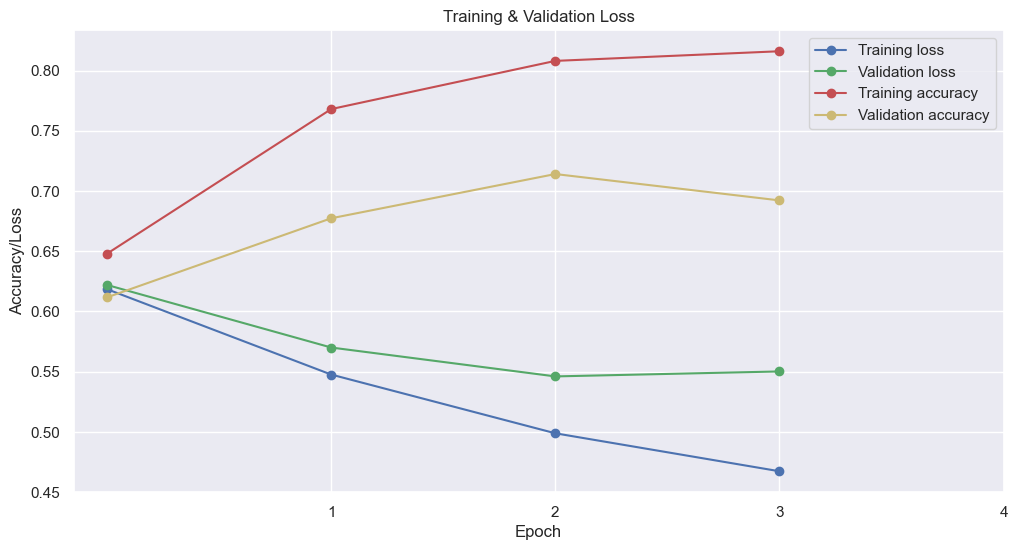

In [227]:
# Run finetuning: Base BERT model, learning rate 2x10-5

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5, eps=1e-8)

run_finetuning(model, epochs, training_loader, val_loader, loss_function, optimizer, 42)

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.5873348955065012
Training accuracy: 0.668


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [16:33<49:40, 993.47s/it]

--------------------
Average validation loss: 0.5370497778058052
Validation Accuracy: 0.7469
Validation Precision: 0.7019
Validation Recall: 0.8078
Validation Specificity: 0.6797

Time elapsed: -17mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.4356120191514492
Training accuracy: 0.828


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [32:15<32:06, 963.04s/it]

--------------------
Average validation loss: 0.5176967605948448
Validation Accuracy: 0.7258
Validation Precision: 0.7442
Validation Recall: 0.6615
Validation Specificity: 0.7966

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.351666696369648
Training accuracy: 0.868


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [47:38<15:44, 944.97s/it]

--------------------
Average validation loss: 0.4915013927966356
Validation Accuracy: 0.7602
Validation Precision: 0.7121
Validation Recall: 0.7955
Validation Specificity: 0.7199

Time elapsed: -15mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.32308346778154373
Training accuracy: 0.884


Evaluation...


Epoch: 100%|███████████████████████████████████| 4/4 [1:02:56<00:00, 944.20s/it]

--------------------
Average validation loss: 0.5019398983567953
Validation Accuracy: 0.7570
Validation Precision: 0.7360
Validation Recall: 0.7443
Validation Specificity: 0.7709

Time elapsed: -15mins



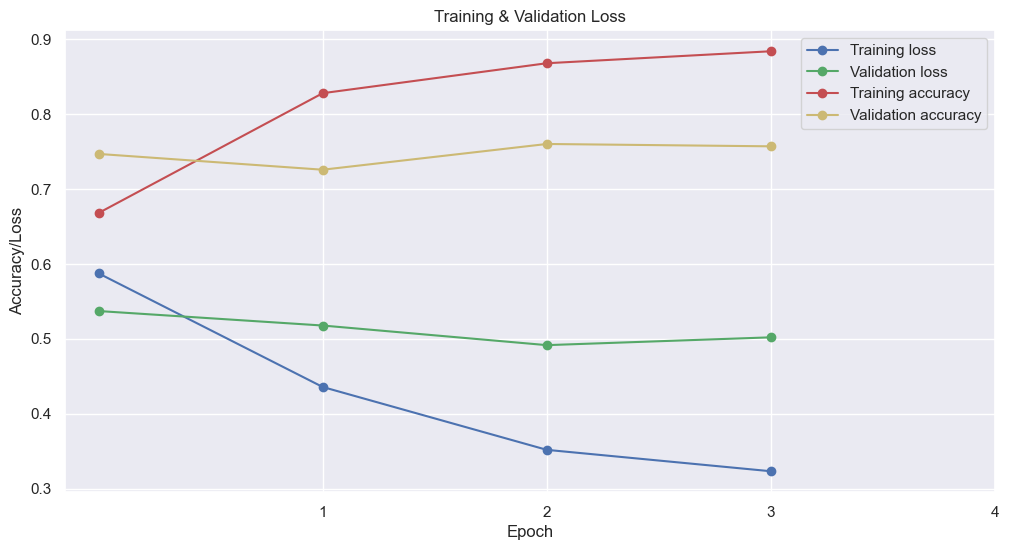

In [228]:
# Run finetuning: Base BERT model, learning rate 3x10-5

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(model,  epochs, training_loader, val_loader, loss_function, optimizer)

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.47969451546669006
Training accuracy: 0.804


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [15:47<47:22, 947.56s/it]

--------------------
Average validation loss: 0.520973039790988
Validation Accuracy: 0.7414
Validation Precision: 0.7462
Validation Recall: 0.6864
Validation Specificity: 0.7680

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.29929492343217134
Training accuracy: 0.884


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [31:21<31:19, 939.64s/it]

--------------------
Average validation loss: 0.5244297664612532
Validation Accuracy: 0.7828
Validation Precision: 0.7582
Validation Recall: 0.7919
Validation Specificity: 0.7791

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.1884072618559003
Training accuracy: 0.94


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [46:47<15:33, 933.15s/it]

--------------------
Average validation loss: 0.6786596430465579
Validation Accuracy: 0.7531
Validation Precision: 0.7737
Validation Recall: 0.6674
Validation Specificity: 0.8333

Time elapsed: -15mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.13190464326180518
Training accuracy: 0.956


Evaluation...


Epoch: 100%|███████████████████████████████████| 4/4 [1:02:16<00:00, 934.01s/it]

--------------------
Average validation loss: 0.7856727819889784
Validation Accuracy: 0.7469
Validation Precision: 0.7991
Validation Recall: 0.6551
Validation Specificity: 0.8239

Time elapsed: -15mins



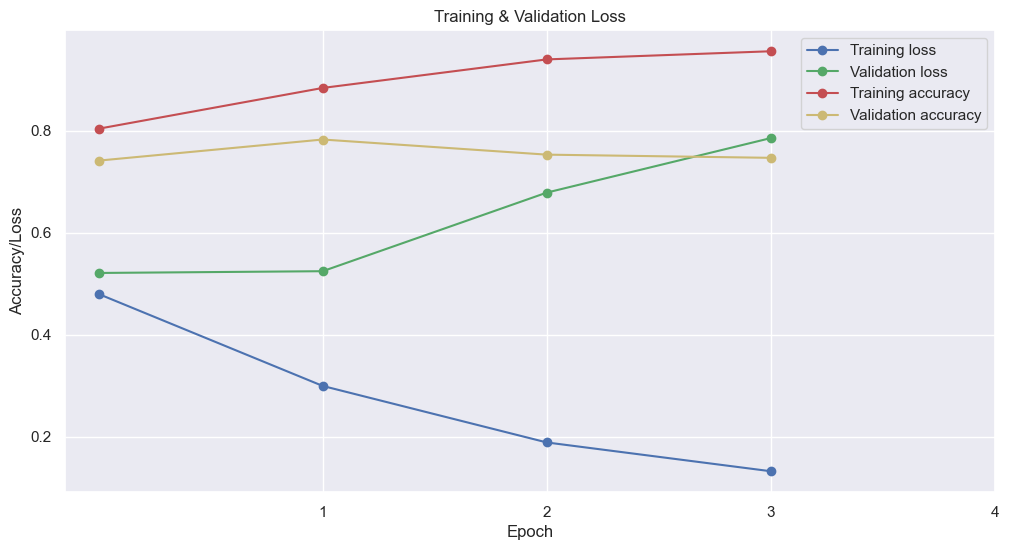

In [229]:
# Run finetuning: Base BERT model, no learning rate warm-up

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(model, epochs, training_loader, val_loader, loss_function, optimizer, warmup=False)

In [230]:
# Set drop-out rate to 0.2

model = BertClass(model='bert-base-uncased', dropout=0.2)

for name, param in list(model.named_parameters())[0:133]: 
    param.requires_grad = False

model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.665337722748518
Training accuracy: 0.596


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [15:37<46:53, 937.85s/it]

--------------------
Average validation loss: 0.6323153302073479
Validation Accuracy: 0.6305
Validation Precision: 0.8444
Validation Recall: 0.2633
Validation Specificity: 0.9557

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.5731725431978703
Training accuracy: 0.744


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [31:12<31:11, 935.96s/it]

--------------------
Average validation loss: 0.5595691427588463
Validation Accuracy: 0.7172
Validation Precision: 0.7356
Validation Recall: 0.6423
Validation Specificity: 0.7793

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.5113059356808662
Training accuracy: 0.8


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [47:16<15:48, 948.82s/it]

--------------------
Average validation loss: 0.5132515486329794
Validation Accuracy: 0.7633
Validation Precision: 0.7364
Validation Recall: 0.7622
Validation Specificity: 0.7607

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.46518131345510483
Training accuracy: 0.828


Evaluation...


Epoch: 100%|███████████████████████████████████| 4/4 [1:05:14<00:00, 978.59s/it]

--------------------
Average validation loss: 0.5038269609212875
Validation Accuracy: 0.7547
Validation Precision: 0.7284
Validation Recall: 0.7601
Validation Specificity: 0.7621

Time elapsed: -18mins



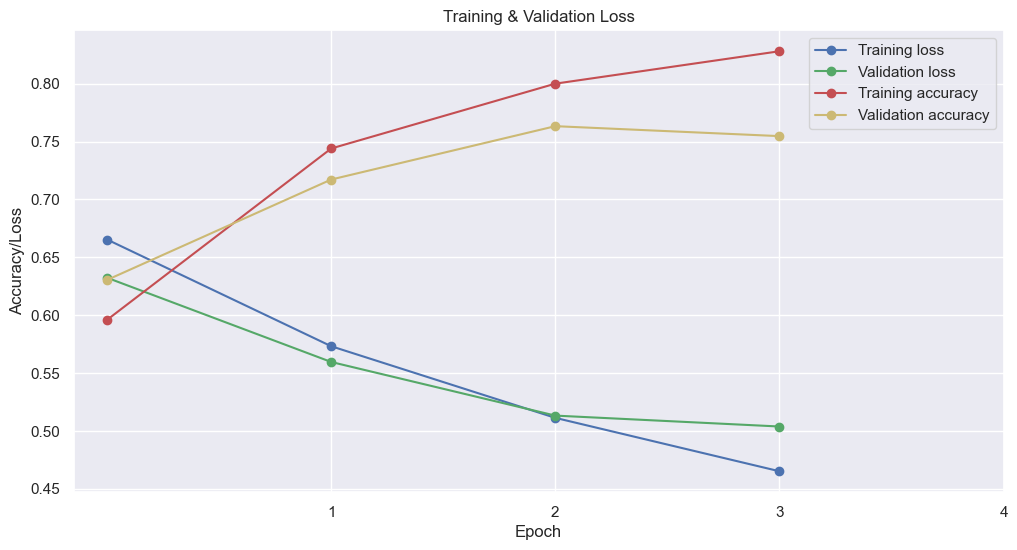

In [231]:
# Run finetuning: Base BERT model, drop-out rate 0.2

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(model, epochs, training_loader, val_loader, loss_function, optimizer)

In [232]:
# Create DataLoader objects to pass training and validation data to model using RandomSampler for reproducibility
clin_tr_sampler = RandomSampler(data_source=clin_training_set)
clin_val_sampler = RandomSampler(data_source=clin_val_set)

clin_training_loader = DataLoader(clin_training_set, batch_size=16, sampler=clin_tr_sampler, num_workers=0)
clin_val_loader = DataLoader(clin_val_set, batch_size=16, sampler=clin_val_sampler, num_workers=0)

In [233]:
# Initialise ClinicalBERT model, freeze first 8 layers, send to device

model = BertClass(model='emilyalsentzer/Bio_ClinicalBERT', dropout=0.1)

for name, param in list(model.named_parameters())[0:133]: 
    param.requires_grad = False

model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.6831879056990147
Training accuracy: 0.572


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [14:27<43:23, 867.99s/it]

--------------------
Average validation loss: 0.6649787649512291
Validation Accuracy: 0.5734
Validation Precision: 0.8750
Validation Recall: 0.1006
Validation Specificity: 0.9931

Time elapsed: -14mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.6332460902631283
Training accuracy: 0.664


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [29:00<29:01, 870.50s/it]

--------------------
Average validation loss: 0.638296365737915
Validation Accuracy: 0.6023
Validation Precision: 0.9231
Validation Recall: 0.1931
Validation Specificity: 0.9841

Time elapsed: -15mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.5900463461875916
Training accuracy: 0.7


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [43:43<14:36, 876.21s/it]

--------------------
Average validation loss: 0.6102923974394798
Validation Accuracy: 0.6758
Validation Precision: 0.9250
Validation Recall: 0.3732
Validation Specificity: 0.9754

Time elapsed: -15mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.5656695440411568
Training accuracy: 0.756


Evaluation...


Epoch: 100%|█████████████████████████████████████| 4/4 [58:11<00:00, 872.79s/it]

--------------------
Average validation loss: 0.6000715140253305
Validation Accuracy: 0.6844
Validation Precision: 0.8956
Validation Recall: 0.3646
Validation Specificity: 0.9741

Time elapsed: -14mins



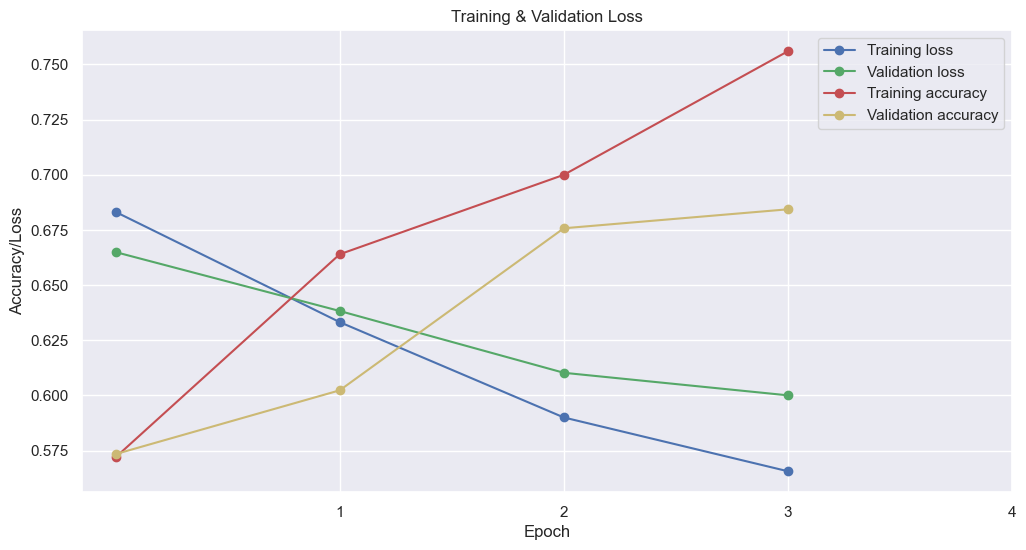

In [234]:
# Run finetuning: ClinicalBERT model, learning rate 2x10-5

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5, eps=1e-8)

run_finetuning(model, epochs, clin_training_loader, clin_val_loader, loss_function, optimizer)

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.5998926497995853
Training accuracy: 0.664


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [15:55<47:45, 955.25s/it]

--------------------
Average validation loss: 0.5730613023042679
Validation Accuracy: 0.6805
Validation Precision: 0.8405
Validation Recall: 0.4098
Validation Specificity: 0.9155

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.4560635071247816
Training accuracy: 0.808


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [32:18<32:23, 971.76s/it]

--------------------
Average validation loss: 0.4709524121135473
Validation Accuracy: 0.7945
Validation Precision: 0.7751
Validation Recall: 0.8199
Validation Specificity: 0.7889

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.37890378292649984
Training accuracy: 0.836


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [49:07<16:28, 988.54s/it]

--------------------
Average validation loss: 0.4781311769038439
Validation Accuracy: 0.7828
Validation Precision: 0.8247
Validation Recall: 0.7185
Validation Specificity: 0.8401

Time elapsed: -17mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.33376111276447773
Training accuracy: 0.868


Evaluation...


Epoch: 100%|███████████████████████████████████| 4/4 [1:05:08<00:00, 977.01s/it]

--------------------
Average validation loss: 0.46881886199116707
Validation Accuracy: 0.7797
Validation Precision: 0.7982
Validation Recall: 0.7054
Validation Specificity: 0.8407

Time elapsed: -16mins



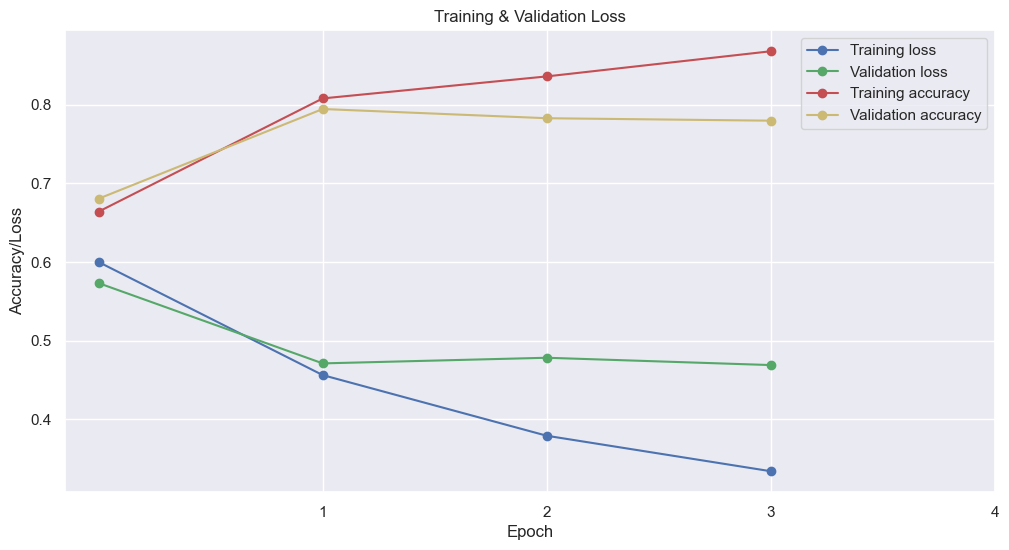

In [236]:
# Run finetuning: ClinicalBERT model, learning rate 3x10-5

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(model, epochs, clin_training_loader, clin_val_loader, loss_function, optimizer)

In [237]:
# Set drop-out rate to 0.2

model = BertClass(model='emilyalsentzer/Bio_ClinicalBERT', dropout=0.2)

for name, param in list(model.named_parameters())[0:133]: 
    param.requires_grad = False

model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Epoch 0:
Average training loss: 0.6696910746395588
Training accuracy: 0.604


Evaluation...


Epoch:  25%|█████████▎                           | 1/4 [15:43<47:09, 943.04s/it]

--------------------
Average validation loss: 0.6389307752251625
Validation Accuracy: 0.6062
Validation Precision: 0.8974
Validation Recall: 0.1929
Validation Specificity: 0.9875

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 1:
Average training loss: 0.589828435331583
Training accuracy: 0.704


Evaluation...


Epoch:  50%|██████████████████▌                  | 2/4 [31:49<31:53, 956.81s/it]

--------------------
Average validation loss: 0.5785851404070854
Validation Accuracy: 0.7047
Validation Precision: 0.8296
Validation Recall: 0.4710
Validation Specificity: 0.9270

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 2:
Average training loss: 0.5145016554743052
Training accuracy: 0.776


Evaluation...


Epoch:  75%|███████████████████████████▊         | 3/4 [48:12<16:08, 968.62s/it]

--------------------
Average validation loss: 0.5279163643717766
Validation Accuracy: 0.7492
Validation Precision: 0.7946
Validation Recall: 0.6420
Validation Specificity: 0.8831

Time elapsed: -16mins

--------------------
Training...
--------------------
Epoch 3:
Average training loss: 0.4647883027791977
Training accuracy: 0.84


Evaluation...


Epoch: 100%|███████████████████████████████████| 4/4 [1:04:12<00:00, 963.02s/it]

--------------------
Average validation loss: 0.49908539466559887
Validation Accuracy: 0.7812
Validation Precision: 0.7969
Validation Recall: 0.7392
Validation Specificity: 0.8307

Time elapsed: -16mins



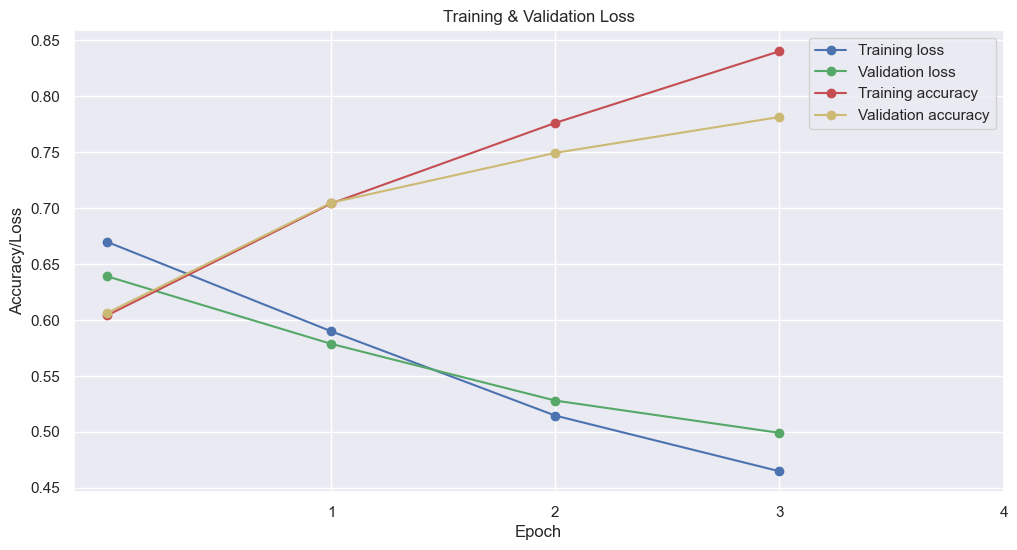

In [239]:
# Run finetuning: ClinicalBERT model, drop-out rate 0.2

epochs = 4
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(model, epochs, clin_training_loader, clin_val_loader, loss_function, optimizer)

- - -

## Supervised learning on training data and model evaluation <a id="12"></a>

In [121]:
# Prepare training data and labels - reset indices to avoid errors:

train_df = pd.DataFrame(X_train['mention_sent']).sample(frac=1, random_state=101)
train_idx = train_df.index.to_list()
train_labels = pd.DataFrame(y_train[y_train.index.isin(train_idx)])

train_df.sort_index(inplace=True)
train_df.reset_index(inplace=True, drop=True)
train_labels.sort_index(inplace=True)
train_labels.reset_index(inplace=True, drop=True)

In [122]:
# Prepare training data and labels - reset indices to avoid errors:

val_df = pd.DataFrame(X_val['mention_sent']).sample(frac=1, random_state=101)
val_idx = val_df.index.to_list()
val_labels = pd.DataFrame(y_val[y_val.index.isin(val_idx)])

val_df.sort_index(inplace=True)
val_df.reset_index(inplace=True, drop=True)
val_labels.sort_index(inplace=True)
val_labels.reset_index(inplace=True, drop=True)

In [123]:
# Create Dataset objects for Bert training and validation data

# Initialise base BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create Dataset objects
bert_training_set = MentionsData(bert_tokenizer, train_df, train_labels)
bert_val_set = MentionsData(bert_tokenizer, val_df, val_labels)

In [141]:
# Create Dataset objects for ClinicalBert training and validation data

# Initialise ClinicalBERT tokenizer
clin_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)

# Create Dataset objects
clin_training_set = MentionsData(clin_tokenizer, train_df, train_labels)
clin_val_set = MentionsData(clin_tokenizer, val_df, val_labels)

In [125]:
# Create DataLoader objects to pass training and validation data to BERT model using RandomSampler for 
# reproducibility

bert_tr_sampler = RandomSampler(data_source=bert_training_set)
bert_val_sampler = RandomSampler(data_source=bert_val_set)

training_loader = DataLoader(bert_training_set, batch_size=16, sampler=bert_tr_sampler, num_workers=0)
val_loader = DataLoader(bert_val_set, batch_size=16, sampler=bert_val_sampler, num_workers=0)

In [128]:
# Initialise base BERT model, freeze first 8 layers, set drop-out rate to 0.1, send to device

model = BertClass(model='bert-base-uncased', dropout=0.1)

for name, param in list(model.named_parameters())[0:133]: 
    param.requires_grad = False

model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Epoch:   0%|                                              | 0/3 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Tracking
Loss: 0.7427175045013428
Accuracy: 0.375
--------------------
--------------------
Tracking
Loss: 0.7511184215545654
Accuracy: 0.3125
--------------------
--------------------
Tracking
Loss: 0.7322261532147726
Accuracy: 0.375
--------------------
--------------------
Tracking
Loss: 0.7092014998197556
Accuracy: 0.453125
--------------------
--------------------
Tracking
Loss: 0.7131272315979004
Accuracy: 0.45
--------------------
--------------------
Tracking
Loss: 0.7033898135026296
Accuracy: 0.4791666666666667
--------------------
--------------------
Tracking
Loss: 0.720295889036996
Accuracy: 0.4732142857142857
--------------------
--------------------
Tracking
Loss: 0.7291827499866486
Accuracy: 0.46875
--------------------
--------------------
Tracking
Loss: 0.7189890477392409
Accuracy: 0.4861111111111111
--------------------
--------------------
Tracking
Loss: 0.7092348098754883
Accuracy: 0.50625
--------------------
--

--------------------
Tracking
Loss: 0.5614291585800124
Accuracy: 0.6859756097560976
--------------------
--------------------
Tracking
Loss: 0.5590948904135141
Accuracy: 0.6875
--------------------
--------------------
Tracking
Loss: 0.5565003053773017
Accuracy: 0.6889880952380952
--------------------
--------------------
Tracking
Loss: 0.5588232135071474
Accuracy: 0.6882352941176471
--------------------
--------------------
Tracking
Loss: 0.5600742077411607
Accuracy: 0.6875
--------------------
--------------------
Tracking
Loss: 0.5596047787145636
Accuracy: 0.6875
--------------------
--------------------
Tracking
Loss: 0.5568466423587366
Accuracy: 0.6896306818181818
--------------------
--------------------
Tracking
Loss: 0.5546146862292558
Accuracy: 0.6917134831460674
--------------------
--------------------
Tracking
Loss: 0.5531408677498499
Accuracy: 0.6930555555555555
--------------------
--------------------
Tracking
Loss: 0.5503711939513029
Accuracy: 0.6957417582417582
-------

Epoch:  33%|██████████▋                     | 1/3 [2:09:38<4:19:17, 7778.86s/it]

--------------------
Average validation loss: 0.37270715783039726
Validation Accuracy: 0.8296
Validation Precision: 0.7998
Validation Recall: 0.8794
Validation Specificity: 0.7760

Time elapsed: -130mins

--------------------
Training...
--------------------
Tracking
Loss: 0.2541418969631195
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.1798884980380535
Accuracy: 0.9375
--------------------
--------------------
Tracking
Loss: 0.23092221965392432
Accuracy: 0.8958333333333334
--------------------
--------------------
Tracking
Loss: 0.2528961207717657
Accuracy: 0.890625
--------------------
--------------------
Tracking
Loss: 0.30245447605848313
Accuracy: 0.8625
--------------------
--------------------
Tracking
Loss: 0.312215406447649
Accuracy: 0.8645833333333334
--------------------
--------------------
Tracking
Loss: 0.3677874452301434
Accuracy: 0.8482142857142857
--------------------
--------------------
Tracking
Loss: 0.3698797067627311
Accuracy: 0.84375


--------------------
Tracking
Loss: 0.3403370611935477
Accuracy: 0.8560126582278481
--------------------
--------------------
Tracking
Loss: 0.33701912886463103
Accuracy: 0.8578125
--------------------
--------------------
Tracking
Loss: 0.33586710079768556
Accuracy: 0.8587962962962963
--------------------
--------------------
Tracking
Loss: 0.33344508175988025
Accuracy: 0.8605182926829268
--------------------
--------------------
Tracking
Loss: 0.33415982643344316
Accuracy: 0.8606927710843374
--------------------
--------------------
Tracking
Loss: 0.3342469346576503
Accuracy: 0.8608630952380952
--------------------
--------------------
Tracking
Loss: 0.3320721624090391
Accuracy: 0.8625
--------------------
--------------------
Tracking
Loss: 0.33059763852073704
Accuracy: 0.8640988372093024
--------------------
--------------------
Tracking
Loss: 0.3299494030746235
Accuracy: 0.8642241379310345
--------------------
--------------------
Tracking
Loss: 0.32871043305336073
Accuracy: 0.865

Epoch:  67%|█████████████████████▎          | 2/3 [4:27:29<2:14:27, 8067.93s/it]

--------------------
Average validation loss: 0.2999599319365289
Validation Accuracy: 0.8704
Validation Precision: 0.8347
Validation Recall: 0.9208
Validation Specificity: 0.8183

Time elapsed: -138mins

--------------------
Training...
--------------------
Tracking
Loss: 0.1550566405057907
Accuracy: 1.0
--------------------
--------------------
Tracking
Loss: 0.2764017805457115
Accuracy: 0.90625
--------------------
--------------------
Tracking
Loss: 0.31961844861507416
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.263881903141737
Accuracy: 0.90625
--------------------
--------------------
Tracking
Loss: 0.27937908470630646
Accuracy: 0.8875
--------------------
--------------------
Tracking
Loss: 0.288861778875192
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.30455286375113894
Accuracy: 0.8660714285714286
--------------------
--------------------
Tracking
Loss: 0.30662413872778416
Accuracy: 0.8671875
--------------------
-----

--------------------
Tracking
Loss: 0.2539085847667501
Accuracy: 0.8971518987341772
--------------------
--------------------
Tracking
Loss: 0.2538787707686424
Accuracy: 0.896875
--------------------
--------------------
Tracking
Loss: 0.25380661292576495
Accuracy: 0.8966049382716049
--------------------
--------------------
Tracking
Loss: 0.2528794127993467
Accuracy: 0.8971036585365854
--------------------
--------------------
Tracking
Loss: 0.2508729931460806
Accuracy: 0.8983433734939759
--------------------
--------------------
Tracking
Loss: 0.24928275424809682
Accuracy: 0.8995535714285714
--------------------
--------------------
Tracking
Loss: 0.2498554156107061
Accuracy: 0.899264705882353
--------------------
--------------------
Tracking
Loss: 0.2507771333289701
Accuracy: 0.8975290697674418
--------------------
--------------------
Tracking
Loss: 0.2516391907615223
Accuracy: 0.8972701149425287
--------------------
--------------------
Tracking
Loss: 0.25400237095626915
Accuracy

Epoch: 100%|██████████████████████████████████| 3/3 [6:18:16<00:00, 7565.54s/it]

--------------------
Average validation loss: 0.2909267093572352
Validation Accuracy: 0.8685
Validation Precision: 0.8498
Validation Recall: 0.8917
Validation Specificity: 0.8534

Time elapsed: -111mins



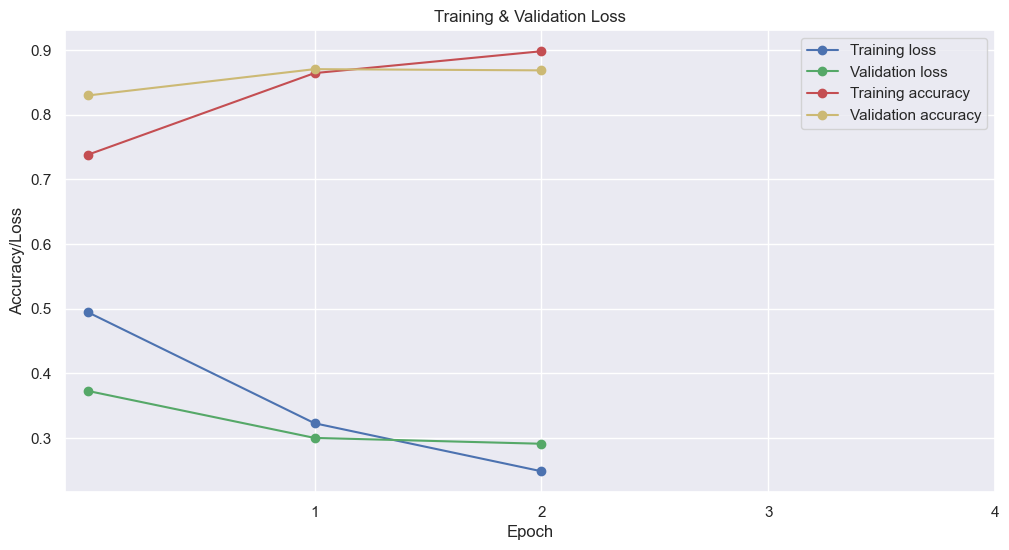

In [129]:
# Run finetuning: Base BERT model using optimised hyperparameters (learning rate 3x10-5, 3 epochs, use of learning-
# rate warm-up)

epochs = 3
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(model, epochs, training_loader, val_loader, loss_function, optimizer)

In [146]:
# Create DataLoader objects to pass training and validation data to ClinicalBERT model using RandomSampler 
# for reproducibility

clin_tr_sampler = RandomSampler(data_source=clin_training_set)
clin_val_sampler = RandomSampler(data_source=clin_val_set)

clin_training_loader = DataLoader(clin_training_set, batch_size=16, sampler=clin_tr_sampler, num_workers=0)
clin_val_loader = DataLoader(clin_val_set, batch_size=16, sampler=clin_val_sampler, num_workers=0)

In [147]:
# Initialise ClinicalBERT model, freeze first 8 layers, set drop-out rate to 0.1, send to device

clin_model = BertClass(model='emilyalsentzer/Bio_ClinicalBERT', dropout=0.1)

for name, param in list(clin_model.named_parameters())[0:133]: 
    param.requires_grad = False

clin_model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Epoch:   0%|                                              | 0/3 [00:00<?, ?it/s]

--------------------
Training...
--------------------
Tracking
Loss: 0.747704267501831
Accuracy: 0.4375
--------------------
--------------------
Tracking
Loss: 0.7174772918224335
Accuracy: 0.5
--------------------
--------------------
Tracking
Loss: 0.7199102441469828
Accuracy: 0.4791666666666667
--------------------
--------------------
Tracking
Loss: 0.7106046229600906
Accuracy: 0.484375
--------------------
--------------------
Tracking
Loss: 0.7030980348587036
Accuracy: 0.5375
--------------------
--------------------
Tracking
Loss: 0.7018956243991852
Accuracy: 0.53125
--------------------
--------------------
Tracking
Loss: 0.6971059441566467
Accuracy: 0.5446428571428571
--------------------
--------------------
Tracking
Loss: 0.6955176591873169
Accuracy: 0.546875
--------------------
--------------------
Tracking
Loss: 0.6941299239794413
Accuracy: 0.5416666666666666
--------------------
--------------------
Tracking
Loss: 0.6900073528289795
Accuracy: 0.55
--------------------
--

--------------------
Tracking
Loss: 0.5086234195566759
Accuracy: 0.7637195121951219
--------------------
--------------------
Tracking
Loss: 0.5066177512866905
Accuracy: 0.7650602409638554
--------------------
--------------------
Tracking
Loss: 0.5076265489416463
Accuracy: 0.7641369047619048
--------------------
--------------------
Tracking
Loss: 0.5042436608496834
Accuracy: 0.7661764705882353
--------------------
--------------------
Tracking
Loss: 0.5023237354187078
Accuracy: 0.7681686046511628
--------------------
--------------------
Tracking
Loss: 0.5011548144721437
Accuracy: 0.7693965517241379
--------------------
--------------------
Tracking
Loss: 0.5022111093117432
Accuracy: 0.7684659090909091
--------------------
--------------------
Tracking
Loss: 0.5051136108931531
Accuracy: 0.7668539325842697
--------------------
--------------------
Tracking
Loss: 0.5026850649052196
Accuracy: 0.7680555555555556
--------------------
--------------------
Tracking
Loss: 0.4980575314589909


Epoch:  33%|██████████▋                     | 1/3 [1:45:27<3:30:55, 6327.76s/it]

--------------------
Average validation loss: 0.331629786392053
Validation Accuracy: 0.8523
Validation Precision: 0.8283
Validation Recall: 0.8833
Validation Specificity: 0.8223

Time elapsed: -105mins

--------------------
Training...
--------------------
Tracking
Loss: 0.42367470264434814
Accuracy: 0.8125
--------------------
--------------------
Tracking
Loss: 0.30563826113939285
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.27081890404224396
Accuracy: 0.9166666666666666
--------------------
--------------------
Tracking
Loss: 0.3031132034957409
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.2987646073102951
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.31995436797539395
Accuracy: 0.8541666666666666
--------------------
--------------------
Tracking
Loss: 0.32426909250872477
Accuracy: 0.8482142857142857
--------------------
--------------------
Tracking
Loss: 0.3054730575531721
Accuracy: 0.859375
-

--------------------
Tracking
Loss: 0.3101197022803222
Accuracy: 0.8615506329113924
--------------------
--------------------
Tracking
Loss: 0.31007329616695645
Accuracy: 0.86171875
--------------------
--------------------
Tracking
Loss: 0.31053379748338533
Accuracy: 0.8611111111111112
--------------------
--------------------
Tracking
Loss: 0.3096496046679776
Accuracy: 0.8620426829268293
--------------------
--------------------
Tracking
Loss: 0.3149790352726557
Accuracy: 0.8591867469879518
--------------------
--------------------
Tracking
Loss: 0.3132648097262496
Accuracy: 0.8601190476190477
--------------------
--------------------
Tracking
Loss: 0.3122824956389034
Accuracy: 0.861764705882353
--------------------
--------------------
Tracking
Loss: 0.31056297968986424
Accuracy: 0.8626453488372093
--------------------
--------------------
Tracking
Loss: 0.3100299958525033
Accuracy: 0.8635057471264368
--------------------
--------------------
Tracking
Loss: 0.3085231337357651
Accura

Epoch:  67%|█████████████████████▎          | 2/3 [3:32:30<1:46:23, 6383.59s/it]

--------------------
Average validation loss: 0.3223134608732329
Validation Accuracy: 0.8718
Validation Precision: 0.8373
Validation Recall: 0.9208
Validation Specificity: 0.8296

Time elapsed: -107mins

--------------------
Training...
--------------------
Tracking
Loss: 0.2801888585090637
Accuracy: 0.8125
--------------------
--------------------
Tracking
Loss: 0.28674446046352386
Accuracy: 0.875
--------------------
--------------------
Tracking
Loss: 0.2876352568467458
Accuracy: 0.8541666666666666
--------------------
--------------------
Tracking
Loss: 0.2677738182246685
Accuracy: 0.84375
--------------------
--------------------
Tracking
Loss: 0.27589693367481233
Accuracy: 0.85
--------------------
--------------------
Tracking
Loss: 0.2525932664672534
Accuracy: 0.8541666666666666
--------------------
--------------------
Tracking
Loss: 0.2710084170103073
Accuracy: 0.8482142857142857
--------------------
--------------------
Tracking
Loss: 0.2692243065685034
Accuracy: 0.859375
--

--------------------
Tracking
Loss: 0.2458263936487934
Accuracy: 0.8892405063291139
--------------------
--------------------
Tracking
Loss: 0.2452769256196916
Accuracy: 0.88984375
--------------------
--------------------
Tracking
Loss: 0.2463082640811249
Accuracy: 0.8896604938271605
--------------------
--------------------
Tracking
Loss: 0.24419022060749007
Accuracy: 0.8910060975609756
--------------------
--------------------
Tracking
Loss: 0.24350395816636372
Accuracy: 0.8908132530120482
--------------------
--------------------
Tracking
Loss: 0.24135129898786545
Accuracy: 0.8921130952380952
--------------------
--------------------
Tracking
Loss: 0.23997294657370624
Accuracy: 0.8926470588235295
--------------------
--------------------
Tracking
Loss: 0.23787428148437378
Accuracy: 0.8938953488372093
--------------------
--------------------
Tracking
Loss: 0.23948817747249002
Accuracy: 0.8929597701149425
--------------------
--------------------
Tracking
Loss: 0.2402102739380842
Ac

Epoch: 100%|██████████████████████████████████| 3/3 [5:38:42<00:00, 6774.19s/it]

--------------------
Average validation loss: 0.2889125843842824
Validation Accuracy: 0.8852
Validation Precision: 0.8777
Validation Recall: 0.9033
Validation Specificity: 0.8696

Time elapsed: -126mins



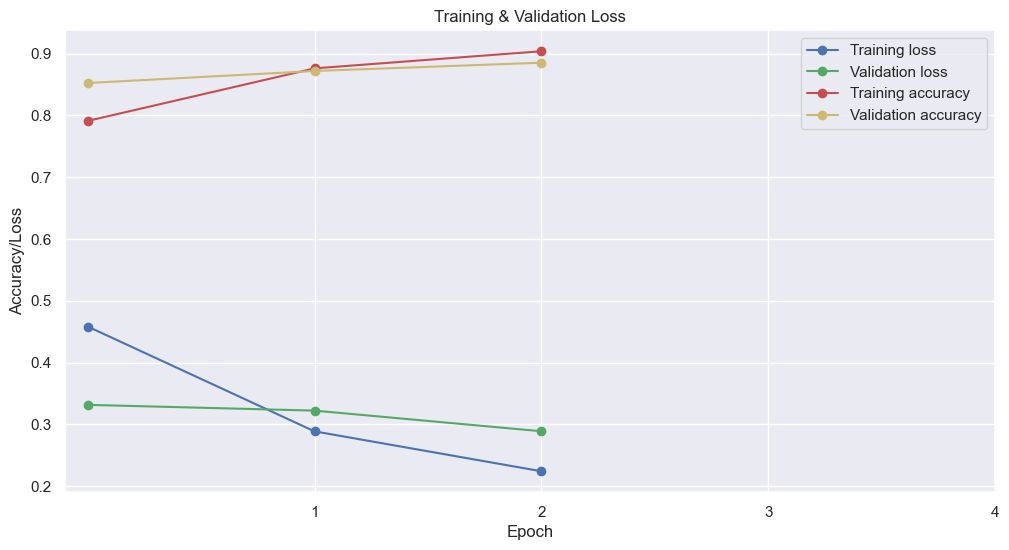

In [148]:
# Run finetuning: ClinicalBERT model using optimised hyperparameters (learning rate 3x10-5, 3 epochs, use of 
# learning-rate warm-up)

epochs = 3
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=clin_model.parameters(), lr=3e-5, eps=1e-8)

run_finetuning(clin_model, epochs, clin_training_loader, clin_val_loader, loss_function, optimizer)

# 4. MODEL EVALUATION AND COMPARISON <a id="13"></a>
- - - 

## Performance of best-performing BERT model on hold-out test dataset


In [149]:
# Evaluate performance of base BERT and ClinicalBERT models on hold-out testing dataset:
# Prepare training data and labels - reset indices to avoid errors

test_df = pd.DataFrame(X_test['mention_sent']).sample(frac=1, random_state=101)
test_idx = test_df.index.to_list()
test_labels = pd.DataFrame(y_test[y_test.index.isin(test_idx)])

test_df.sort_index(inplace=True)
test_df.reset_index(inplace=True, drop=True)
test_labels.sort_index(inplace=True)
test_labels.reset_index(inplace=True, drop=True)


In [150]:
# Create DataLoader objects for hold-out testing dataset

clin_testing_set = MentionsData(clin_tokenizer, test_df, test_labels)

In [151]:
# Create DataLoader objects to pass training and validation data to ClinicalBERT model using RandomSampler 
# for reproducibility

clin_test_sampler = RandomSampler(data_source=clin_testing_set)
clin_testing_loader = DataLoader(clin_testing_set, batch_size=16, sampler=clin_test_sampler, num_workers=0)

In [203]:
# Evaluate performance of best BERT model (ClinicalBERT) on testing dataset 

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

logging.set_verbosity_error()

clin_model.eval()

bert_ids = []
bert_labels = []
bert_preds = []
bert_probs = []
        
test_accuracy = []
test_precision = []
test_recall = []
test_specificity = []
        
for step, batch in enumerate(clin_testing_loader, 0):
    test_ids = batch['ids'].to(device, dtype = torch.long)
    test_masks = batch['mask'].to(device, dtype = torch.long)
    test_token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
    test_targets = batch['targets'].to(device, dtype = torch.long)
            
    # Extract predictions, probilities, labels, and token ids for each instance in each batch
    with torch.no_grad():
        outputs = clin_model(test_ids, test_masks, test_token_type_ids)
        loss = loss_function(outputs, test_targets)
        bert_probs.append([torch.max(i) for i in (torch.softmax(outputs, dim=1))])
        big_val, big_idx = torch.max(outputs.data, dim=1)
        bert_labels.append(test_targets)
        bert_preds.append(big_idx)
        bert_ids.append(test_ids)
            
        # Calculate metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(big_idx, test_targets)
        test_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': test_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': test_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': test_specificity.append(b_specificity)


In [204]:
# Print metrics

print(f"Average accuracy: {round(mean([i.tolist() for i in test_accuracy]),4)}")
print(f"Average precision: {round(mean([i.tolist() for i in test_precision]),4)}")
print(f"Average recall: {round(mean([i.tolist() for i in test_recall]),4)}")
print(f"Average specificity: {round(mean([i.tolist() for i in test_specificity]),4)}")

Average accuracy: 0.8921
Average precision: 0.881
Average recall: 0.9022
Average specificity: 0.8963


In [210]:
# Extract token ids, labels, predictions and probabilities to lists, removing 0 padding from token ids lists

ids_list = []
labels_list = []
preds_list = []
probs_list = []

for i in range(len(bert_ids)):
    ids_list.extend([t.tolist() for t in bert_ids[i]])
for items in ids_list:
    while items[-1] == 0:
        items.pop()
    
for i in range(len(bert_labels)):
    labels_list.extend([t.tolist() for t in bert_labels[i]])
      
for i in range(len(bert_preds)):
    preds_list.extend([t.tolist() for t in bert_preds[i]])  
    
for i in range(len(bert_probs)):
    probs_list.extend([t.tolist() for t in bert_probs[i]])

In [239]:
# Create dataframe containing ids, labels, predictions and probailities for ClinicalBERT model

results = {'ids': [i for i in ids_list], 'labels': [l for l in labels_list], 
           'predictions': [p for p in preds_list], 'probabilities': [pr for pr in probs_list]}

df_results = pd.DataFrame(results)
df_results.head()

ids  labels  predictions  \
0  [101, 3718, 131, 1224, 1107, 2704, 1736, 117, ...       0            0   
1  [101, 21810, 131, 1704, 131, 1142, 1110, 170, ...       1            1   
2  [101, 10880, 1116, 131, 1175, 1108, 1185, 2841...       0            0   
3  [101, 192, 19989, 11846, 131, 1185, 192, 19989...       0            0   
4  [101, 1603, 1757, 1104, 2184, 131, 1103, 5351,...       0            1   

   probabilities  
0       0.952444  
1       0.882668  
2       0.997408  
3       0.997886  
4       0.961686

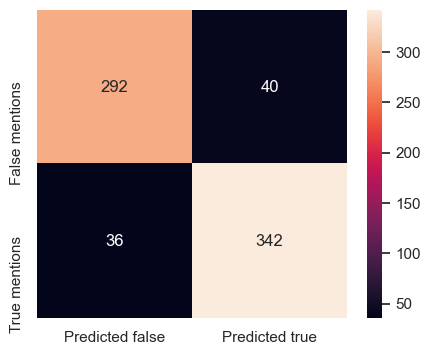

In [252]:
# Construct and visualise confusion matrix

col_predt = [len(df_results[(df_results.predictions == 1) & (df_results.labels == 1)]),
                 len(df_results[(df_results.predictions == 1) & (df_results.labels == 0)])]
col_predf = [len(df_results[(df_results.predictions == 0) & (df_results.labels == 1)]),
                 len(df_results[(df_results.predictions == 0) & (df_results.labels == 0)])]

cm = pd.DataFrame([col_predt, col_predf], columns=['Predicted false', 'Predicted true'], 
                  index=['False mentions', 'True mentions'])

fig, axes = plt.subplots(1, figsize=(5,4))
sns.heatmap(cm,annot=True,fmt="d");

In [259]:
# Print classification report and ROC AUC values

print(f"Classification report:\n\n{classification_report(labels_list, preds_list, digits=4)}\n")
print("-" * 55,"\n")
print(f"ROC AUC:\n{roc_auc_score(labels_list, preds_list):.4f}\n\n")
print("-" * 55,"\n")

Classification report:

              precision    recall  f1-score   support

           0     0.9048    0.8953    0.9000       382
           1     0.8795    0.8902    0.8848       328

    accuracy                         0.8930       710
   macro avg     0.8921    0.8928    0.8924       710
weighted avg     0.8931    0.8930    0.8930       710


------------------------------------------------------- 

ROC AUC:
0.8928


------------------------------------------------------- 



In [266]:
# Append dataframe with column indicating correct predictions

df_results['correct'] = np.where(df_results['predictions'] == df_results['labels'], 1, 0)
df_results.sort_values(by='probabilities', ascending=False)

ids  labels  predictions  \
308  [101, 7930, 13499, 5474, 131, 1185, 12177, 793...       0            0   
261  [101, 1893, 20955, 1233, 9037, 1116, 131, 1185...       0            0   
411  [101, 5048, 14494, 131, 4252, 7877, 9084, 1905...       0            0   
3    [101, 192, 19989, 11846, 131, 1185, 192, 19989...       0            0   
285  [101, 12135, 1785, 131, 1185, 1231, 8346, 117,...       0            0   
..                                                 ...     ...          ...   
248  [101, 16557, 131, 8351, 131, 24970, 1104, 1103...       0            0   
407  [101, 12176, 16312, 1116, 131, 1106, 7584, 731...       1            1   
680  [101, 2704, 118, 2888, 20673, 131, 124, 119, 2...       1            1   
257  [101, 177, 1183, 5674, 18901, 2093, 8191, 131,...       0            0   
284  [101, 170, 1830, 1665, 131, 170, 1830, 1665, 1...       0            0   

     probabilities  correct  
308       0.998018        1  
261       0.997933        1  
411       0.997896        1  
3         0.997886        1  
285       0.997877        1  
..             ...      ...  
248       0.513371        1  
407       0.510521        1  
680       0.510254        1  
257       0.509512        1  
284       0.507218        1  

[710 rows x 5 columns]

In [281]:
df_results.describe().T

count      mean       std       min       25%       50%  \
labels         710.0  0.461972  0.498903  0.000000  0.000000  0.000000   
predictions    710.0  0.467606  0.499301  0.000000  0.000000  0.000000   
probabilities  710.0  0.912186  0.118232  0.507218  0.883759  0.967956   
correct        710.0  0.892958  0.309385  0.000000  1.000000  1.000000   

                    75%       max  
labels         1.000000  1.000000  
predictions    1.000000  1.000000  
probabilities  0.987835  0.998018  
correct        1.000000  1.000000

In [284]:
# Examine correct predictions assigned with 90-99% probability 

print('Overall results:')
print('-'*20)
print(f"Percentage correct: {round(df_results.correct.sum() / len(df_results),2)}")
print(f"Number predictions: {len(df_results)}")
print(f"Number correct: {df_results.correct.sum()}\n\n")

print('Results - Predictions made with probability >0.88:')
print('-'*20)
print(f"Percentage correct: {round(df_results[df_results.probabilities > 0.88].correct.sum() / len(df_results[df_results.probabilities > 0.88]),2)}")
print(f"Number predictions: {len(df_results[df_results.probabilities > 0.88])}")
print(f"Number correct: {df_results[df_results.probabilities > 0.88].correct.sum()}\n\n")

print('Results - Predictions made with probability >0.97:')
print('-'*20)
print(f"Percentage correct: {round(df_results[df_results.probabilities > 0.97].correct.sum() / len(df_results[df_results.probabilities > 0.97]),2)}")
print(f"Number predictions: {len(df_results[df_results.probabilities > 0.97])}")
print(f"Number correct: {df_results[df_results.probabilities > 0.97].correct.sum()}\n\n")

print('Results - Predictions made with probability >0.99:')
print('-'*20)
print(f"Percentage correct: {round(df_results[df_results.probabilities > 0.99].correct.sum() / len(df_results[df_results.probabilities > 0.99]),2)}")
print(f"Number predictions: {len(df_results[df_results.probabilities > 0.99])}")
print(f"Number correct: {df_results[df_results.probabilities > 0.99].correct.sum()}")


Overall results:
--------------------
Percentage correct: 0.89
Number predictions: 710
Number correct: 634


Results - Predictions made with probability >0.88:
--------------------
Percentage correct: 0.96
Number predictions: 538
Number correct: 516


Results - Predictions made with probability >0.97:
--------------------
Percentage correct: 0.98
Number predictions: 347
Number correct: 340


Results - Predictions made with probability >0.99:
--------------------
Percentage correct: 0.98
Number predictions: 155
Number correct: 152


In [361]:
df_results

ids  labels  predictions  \
619  [101, 177, 1183, 11439, 7889, 16219, 1863, 131...       1            1   
602  [101, 1344, 1892, 2997, 131, 3621, 25575, 131,...       0            0   
326  [101, 188, 2083, 4759, 131, 1103, 5785, 1108, ...       0            0   
538  [101, 2962, 2445, 131, 12177, 14907, 2946, 840...       0            0   
262  [101, 14044, 25669, 15391, 1161, 131, 1185, 17...       0            0   
..                                                 ...     ...          ...   
669  [101, 16557, 131, 2999, 16557, 1105, 16530, 17...       0            0   
346  [101, 172, 6582, 11776, 131, 4252, 7877, 9084,...       0            0   
415  [101, 1231, 5822, 1348, 2489, 131, 126, 176, 1...       1            1   
204  [101, 1126, 8816, 6834, 1306, 131, 1103, 1126,...       1            1   
540  [101, 6021, 131, 1103, 5351, 1144, 6021, 1104,...       0            0   

     probabilities  correct                                           sentence  
619       0.941906        1  [a, ##b, ##c, :, a, ##b, ##c, is, the, patient...  
602       0.997579        1  [a, ##b, ##c, :, discharge, instructions, :, t...  
326       0.980818        1  [a, ##b, ##c, :, m, ##r, ., a, ##b, ##c, also,...  
538       0.926049        1  [a, ##b, ##c, :, the, patient, is, to, follow,...  
262       0.997241        1  [a, ##pha, ##sia, :, a, re, ##eval, ##uation, ...  
..             ...      ...                                                ...  
669       0.985477        1  [weakness, :, she, is, not, having, weakness, ...  
346       0.997262        1  [weakness, :, slowed, h, ##ks, due, to, weakne...  
415       0.877431        1  [weakness, :, to, the, best, of, his, re, ##co...  
204       0.693400        1  [weakness, :, when, asked, about, her, return,...  
540       0.864683        1  [worn, out, :, x, -, ray, showed, that, the, p...  

[710 rows x 6 columns]

- - -

## Performance of best-performing random forest model on hold-out test dataset <a id="14"></a>

Classification report:

              precision    recall  f1-score   support

         0.0     0.8251    0.8272    0.8261       382
         1.0     0.7982    0.7957    0.7969       328

    accuracy                         0.8127       710
   macro avg     0.8116    0.8115    0.8115       710
weighted avg     0.8126    0.8127    0.8127       710


------------------------------------------------------- 

ROC AUC:
0.8115


------------------------------------------------------- 



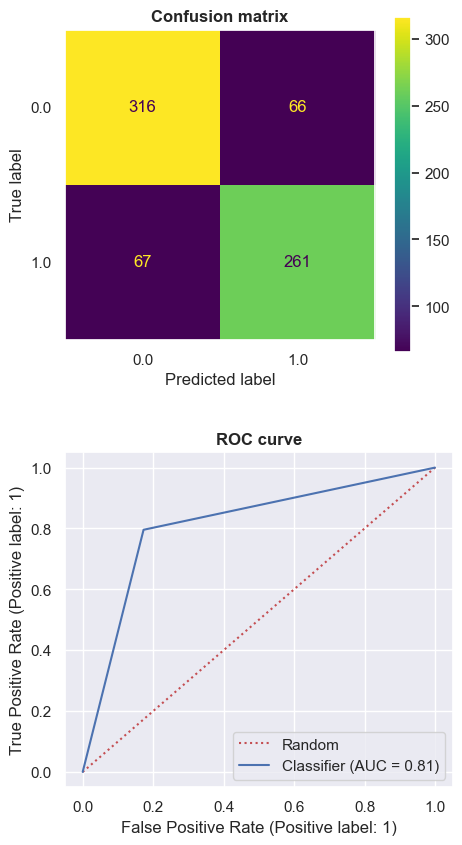

In [260]:
# Generate predictions using RF model trained on ClinicalBERT sentence embeddings

evaluate(model_rf_C, X_test_C, y_test)

In [263]:
# Calculate scoring for optimised model over a further 4 runs:

seed = [1, 3, 9, 27]

for i in range(len(seed)): 
    rf = RandomForestClassifier(max_depth=50, n_estimators=150, criterion='entropy',
                                max_features='log2', random_state=seed[i])
    model = rf.fit(list(X_train_C), y_train)
    preds = model.predict(list(X_test_C))

    print(f"Run {i}:")
    print('-'*20)
    print(f"Classification report:\n\n{classification_report(y_test, preds, digits=4)}\n")
    print("-" * 55,"\n")
    print(f"ROC AUC:\n{roc_auc_score(y_test, preds):.4f}\n\n")
    print("-" * 55,"\n")


Run 0:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8286    0.8482    0.8383       382
         1.0     0.8182    0.7957    0.8068       328

    accuracy                         0.8239       710
   macro avg     0.8234    0.8219    0.8225       710
weighted avg     0.8238    0.8239    0.8237       710


------------------------------------------------------- 

ROC AUC:
0.8219


------------------------------------------------------- 

Run 1:
--------------------
Classification report:

              precision    recall  f1-score   support

         0.0     0.8210    0.8403    0.8305       382
         1.0     0.8088    0.7866    0.7975       328

    accuracy                         0.8155       710
   macro avg     0.8149    0.8134    0.8140       710
weighted avg     0.8153    0.8155    0.8153       710


------------------------------------------------------- 

ROC AUC:
0.8134


------------------------------

In [276]:
# Create dataframe containing with random forest model predictions and probabilities

df_rf_preds = pd.DataFrame()

df_rf_preds['pred'] = model_rf_C.predict(list(X_test_C))
df_rf_preds['prob'] = [item[0] for item in model_rf_C.predict_proba(list(X_test_C))]
df_rf_preds['label'] = list(y_test)

# Add columns to indicate correct predictions
df_rf_preds['correct'] = np.where(df_rf_preds['pred'] == df_rf_preds['label'], 1, 0)

df_rf_preds.head()

pred      prob  label  correct
0   1.0  0.463667    1.0        1
1   0.0  0.993333    0.0        1
2   0.0  0.899048    0.0        1
3   0.0  0.816667    0.0        1
4   1.0  0.213333    1.0        1

In [280]:
df_rf_preds.describe().T

count      mean       std       min       25%       50%      75%  max
pred     710.0  0.460563  0.498794  0.000000  0.000000  0.000000  1.00000  1.0
prob     710.0  0.538676  0.259276  0.026667  0.324556  0.534389  0.74625  1.0
label    710.0  0.461972  0.498903  0.000000  0.000000  0.000000  1.00000  1.0
correct  710.0  0.812676  0.390446  0.000000  1.000000  1.000000  1.00000  1.0

In [285]:
# Examine correct predictions assigned with 90-99% probability 

print('Overall results:')
print('-'*20)
print(f"Percentage correct: {round(df_rf_preds.correct.sum() / len(df_rf_preds),2)}")
print(f"Number predictions: {len(df_rf_preds)}")
print(f"Number correct: {df_rf_preds.correct.sum()}\n\n")

print('Results - Predictions made with probability >0.53:')
print('-'*20)
print(f"Percentage correct: {round(df_rf_preds[df_rf_preds.prob > 0.53].correct.sum() / len(df_rf_preds[df_rf_preds.prob > 0.53]),2)}")
print(f"Number predictions: {len(df_rf_preds[df_rf_preds.prob > 0.53])}")
print(f"Number correct: {df_rf_preds[df_rf_preds.prob > 0.53].correct.sum()}\n\n")

print('Results - Predictions made with probability >0.75:')
print('-'*20)
print(f"Percentage correct: {round(df_rf_preds[df_rf_preds.prob > 0.75].correct.sum() / len(df_rf_preds[df_rf_preds.prob> 0.75]),2)}")
print(f"Number predictions: {len(df_rf_preds[df_rf_preds.prob > 0.75])}")
print(f"Number correct: {df_rf_preds[df_rf_preds.prob > 0.75].correct.sum()}")

Overall results:
--------------------
Percentage correct: 0.81
Number predictions: 710
Number correct: 577


Results - Predictions made with probability >0.53:
--------------------
Percentage correct: 0.84
Number predictions: 360
Number correct: 304


Results - Predictions made with probability >0.75:
--------------------
Percentage correct: 0.97
Number predictions: 174
Number correct: 168


- - -

## Analysis of BERT predictions by document type, and numbers of predictions made incorrectly by both models<a id="15"></a>

In [385]:
# Convert token ids back to tokens for each sentence in test dataset. Sort by tokenized sentences, examine results

def convert_ids(row):
    tokens = clin_tokenizer.tokenize(clin_tokenizer.decode(row))
    tokens.remove('[CLS]')
    tokens.remove('[SEP]')
    return tokens

df_results['sentence'] = df_results['ids'].apply(lambda row: convert_ids(row))

df_results.sort_values(by='sentence', inplace=True)
df_results.head()

ids  labels  predictions  \
284  [101, 170, 1830, 1665, 131, 170, 1830, 1665, 1...       0            0   
321  [101, 170, 1830, 1665, 131, 12398, 7953, 131, ...       0            0   
551  [101, 170, 1830, 1665, 131, 182, 1197, 119, 17...       0            0   
396  [101, 170, 1830, 1665, 131, 1103, 5351, 1110, ...       0            0   
234  [101, 170, 20695, 6370, 131, 170, 1231, 17885,...       0            1   

     probabilities  correct                                           sentence  
284       0.507218        1  [a, ##b, ##c, :, a, ##b, ##c, is, the, patient...  
321       0.955111        1  [a, ##b, ##c, :, discharge, instructions, :, t...  
551       0.835345        1  [a, ##b, ##c, :, m, ##r, ., a, ##b, ##c, also,...  
396       0.836260        1  [a, ##b, ##c, :, the, patient, is, to, follow,...  
234       0.960763        0  [a, ##pha, ##sia, :, a, re, ##eval, ##uation, ...

In [386]:
# Tokenize enclosing sentences in test dataset, X_test and append as new column

def tokenize(row):
    tokens = clin_tokenizer.tokenize(row)
    return tokens

X_test['tokenized'] = X_test['mention_sent'].apply(lambda row : tokenize(row))
X_test.head()

file  start   end                 text       class  \
5107  3515_Gastroenterology.txt   2321  2329             aneurysm  Phenotypes   
2251  3224_General Medicine.txt    678   686             weakness  Phenotypes   
3544  3521_Gastroenterology.txt   1267  1273               angina  Phenotypes   
1848  3206_General Medicine.txt   3830  3849  shortness of breath  Phenotypes   
1273  3455_Gastroenterology.txt   3012  3020             numbness  Phenotypes   

                                     enclosing_sentence  \
5107  The aneurysm was opened on the right anterior ...   
2251  She is not having weakness, dizziness, lighthe...   
3544  REVIEW OF SYSTEMS:  Cardiovascular: Denies ang...   
1848  RESPIRATIONS:  Clear to auscultation bilateral...   
1273  This is all primarily gone away except for a l...   

                                              prev_sent  \
5107  The inferior left renal artery was controlled ...   
2251   She is not reporting any untoward side effect.     
3544               Date of last pap smear: 1/15/1998.     
1848  CARDIOVASCULAR:  Heart is regular rate and rhy...   
1273  The patient then brought up some right hand an...   

                                              next_sent  \
5107  There was a high-grade stenosis at the origin ...   
2251                            She has no orthopnea.     
3544  Pulmonary: Denies cough, hemoptysis, wheezing,...   
1848  GASTROINTESTINAL:  Abdomen is normal and nonte...   
1273  I told her that I felt that this would continu...   

                                           mention_sent  \
5107  aneurysm: The aneurysm was opened on the right...   
2251  weakness: She is not having weakness, dizzines...   
3544  angina: REVIEW OF SYSTEMS:  Cardiovascular: De...   
1848  shortness of breath: RESPIRATIONS:  Clear to a...   
1273  numbness: This is all primarily gone away exce...   

                                                   bert  \
5107  [-0.438401460647583, -0.38185274600982666, 0.1...   
2251  [-0.47600501775741577, -0.14013491570949554, 0...   
3544  [-0.2940635085105896, -0.03718562424182892, 0....   
1848  [-0.5546330213546753, -0.46771687269210815, 0....   
1273  [-0.1985795497894287, -0.3750556707382202, 0.1...   

                                                   clin  sent_len  \
5107  [-0.20888260006904602, 0.5266367197036743, -0....        19   
2251  [-0.685004711151123, 0.49479377269744873, -0.4...        21   
3544  [-0.16301102936267853, 0.24495616555213928, -0...        19   
1848  [-0.5127139091491699, -0.05988190323114395, -0...         9   
1273  [-0.06217440217733383, 0.49423810839653015, -0...        28   

                                              tokenized  
5107  [an, ##eur, ##ys, ##m, :, the, an, ##eur, ##ys...  
2251  [weakness, :, she, is, not, having, weakness, ...  
3544  [an, ##gin, ##a, :, review, of, systems, :, ca...  
1848  [short, ##ness, of, breath, :, re, ##spiration...  
1273  [numb, ##ness, :, this, is, all, primarily, go...

In [387]:
# Combine X_test with RF results 

df_combin_rf = pd.concat([X_test.reset_index(drop=True), df_rf_preds], axis=1)
df_combin_rf.sort_values(by='tokenized', inplace=True)
df_combin_rf.head()

file  start   end     text       class  \
138   3233_General Medicine.txt   7302  7305      ABC  Phenotypes   
521  3915_Discharge Summary.txt   1157  1160      ABC  Phenotypes   
632   3233_General Medicine.txt   7618  7621      ABC  Phenotypes   
322  3912_Discharge Summary.txt   1767  1770      ABC  Phenotypes   
443  3885_Discharge Summary.txt   2298  2305  aphasia  Phenotypes   

                                    enclosing_sentence  \
138  ABC is the patient's son and although he lives...   
521  DISCHARGE INSTRUCTIONS:    Transfer to ABC for...   
632  Mr. ABC also spoke to the patient while she wa...   
322  The patient is to follow up with Dr. ABC in tw...   
443  A reevaluation completed on 12/01/08, revealed...   

                                             prev_sent  \
138  The neighbor is XYZ and he says that he checks...   
521               CONDITION ON DISCHARGE:    Stable.     
632               She sounded her usual self to him.     
322  Call the office or return to the emergency roo...   
443  She has made great strides; however, with her ...   

                                             next_sent  \
138        He states that he spoke to her yesterday.     
521                                   Diabetic diet.     
632  He states that he will be able to check on her...   
322                                                  -   
443  Once again, she made significant improvement a...   

                                          mention_sent  \
138  ABC: ABC is the patient's son and although he ...   
521  ABC: DISCHARGE INSTRUCTIONS:    Transfer to AB...   
632  ABC: Mr. ABC also spoke to the patient while s...   
322  ABC: The patient is to follow up with Dr. ABC ...   
443  aphasia: A reevaluation completed on 12/01/08,...   

                                                  bert  \
138  [-0.336409330368042, -0.26830437779426575, 0.4...   
521  [0.5701959133148193, -0.3789995312690735, 0.34...   
632  [0.030152998864650726, -0.744368314743042, 0.4...   
322  [0.35809847712516785, -0.5173671245574951, 0.7...   
443  [-0.4946049153804779, -0.586959958076477, 0.35...   

                                                  clin  sent_len  \
138  [-0.1460040956735611, 0.1347850263118744, -0.2...        22   
521  [0.1264575868844986, 0.05502726137638092, 0.03...        10   
632  [-0.31653350591659546, 0.2039543241262436, -0....        32   
322  [-0.20330020785331726, 0.31762146949768066, -0...        12   
443  [-0.7006493806838989, 0.40691742300987244, -0....        11   

                                             tokenized  pred      prob  label  \
138  [a, ##b, ##c, :, a, ##b, ##c, is, the, patient...   0.0  0.657778    0.0   
521  [a, ##b, ##c, :, discharge, instructions, :, t...   0.0  0.756667    0.0   
632  [a, ##b, ##c, :, m, ##r, ., a, ##b, ##c, also,...   0.0  0.573333    0.0   
322  [a, ##b, ##c, :, the, patient, is, to, follow,...   0.0  0.588333    0.0   
443  [a, ##pha, ##sia, :, a, re, ##eval, ##uation, ...   1.0  0.309333    0.0   

     correct  
138        1  
521        1  
632        1  
322        1  
443        0

In [389]:
# Combine with BERT results dataframe

df_combin_all = pd.concat([df_combin_rf.reset_index(drop=True), df_results.reset_index(drop=True)], axis=1)
df_combin_all.head()

file  start   end     text       class  \
0   3233_General Medicine.txt   7302  7305      ABC  Phenotypes   
1  3915_Discharge Summary.txt   1157  1160      ABC  Phenotypes   
2   3233_General Medicine.txt   7618  7621      ABC  Phenotypes   
3  3912_Discharge Summary.txt   1767  1770      ABC  Phenotypes   
4  3885_Discharge Summary.txt   2298  2305  aphasia  Phenotypes   

                                  enclosing_sentence  \
0  ABC is the patient's son and although he lives...   
1  DISCHARGE INSTRUCTIONS:    Transfer to ABC for...   
2  Mr. ABC also spoke to the patient while she wa...   
3  The patient is to follow up with Dr. ABC in tw...   
4  A reevaluation completed on 12/01/08, revealed...   

                                           prev_sent  \
0  The neighbor is XYZ and he says that he checks...   
1               CONDITION ON DISCHARGE:    Stable.     
2               She sounded her usual self to him.     
3  Call the office or return to the emergency roo...   
4  She has made great strides; however, with her ...   

                                           next_sent  \
0        He states that he spoke to her yesterday.     
1                                   Diabetic diet.     
2  He states that he will be able to check on her...   
3                                                  -   
4  Once again, she made significant improvement a...   

                                        mention_sent  \
0  ABC: ABC is the patient's son and although he ...   
1  ABC: DISCHARGE INSTRUCTIONS:    Transfer to AB...   
2  ABC: Mr. ABC also spoke to the patient while s...   
3  ABC: The patient is to follow up with Dr. ABC ...   
4  aphasia: A reevaluation completed on 12/01/08,...   

                                                bert  \
0  [-0.336409330368042, -0.26830437779426575, 0.4...   
1  [0.5701959133148193, -0.3789995312690735, 0.34...   
2  [0.030152998864650726, -0.744368314743042, 0.4...   
3  [0.35809847712516785, -0.5173671245574951, 0.7...   
4  [-0.4946049153804779, -0.586959958076477, 0.35...   

                                                clin  sent_len  \
0  [-0.1460040956735611, 0.1347850263118744, -0.2...        22   
1  [0.1264575868844986, 0.05502726137638092, 0.03...        10   
2  [-0.31653350591659546, 0.2039543241262436, -0....        32   
3  [-0.20330020785331726, 0.31762146949768066, -0...        12   
4  [-0.7006493806838989, 0.40691742300987244, -0....        11   

                                           tokenized  pred      prob  label  \
0  [a, ##b, ##c, :, a, ##b, ##c, is, the, patient...   0.0  0.657778    0.0   
1  [a, ##b, ##c, :, discharge, instructions, :, t...   0.0  0.756667    0.0   
2  [a, ##b, ##c, :, m, ##r, ., a, ##b, ##c, also,...   0.0  0.573333    0.0   
3  [a, ##b, ##c, :, the, patient, is, to, follow,...   0.0  0.588333    0.0   
4  [a, ##pha, ##sia, :, a, re, ##eval, ##uation, ...   1.0  0.309333    0.0   

   correct                                                ids  labels  \
0        1  [101, 170, 1830, 1665, 131, 170, 1830, 1665, 1...       0   
1        1  [101, 170, 1830, 1665, 131, 12398, 7953, 131, ...       0   
2        1  [101, 170, 1830, 1665, 131, 182, 1197, 119, 17...       0   
3        1  [101, 170, 1830, 1665, 131, 1103, 5351, 1110, ...       0   
4        0  [101, 170, 20695, 6370, 131, 170, 1231, 17885,...       0   

   predictions  probabilities  correct  \
0            0       0.507218        1   
1            0       0.955111        1   
2            0       0.835345        1   
3            0       0.836260        1   
4            1       0.960763        0   

                                            sentence  
0  [a, ##b, ##c, :, a, ##b, ##c, is, the, patient...  
1  [a, ##b, ##c, :, discharge, instructions, :, t...  
2  [a, ##b, ##c, :, m, ##r, ., a, ##b, ##c, also,...  
3  [a, ##b, ##c, :, the, patient, is, to, follow,...  
4  [a, ##pha, ##sia, :, a, re, ##eval, ##uation, ...

In [398]:
# Examine the number of instances predicted incorrectly by both models

df_combin_all['both incorrect'] = np.where((df_combin_all['pred'] != df_combin_all['label']) &
                                            (df_combin_all['predictions'] != df_combin_all['labels']), 1, 0)

print('Percentage of mentions predicted incorrectly by both models:')
print(f"{round((len(df_combin_all[df_combin_all['both incorrect'] == 1]) *100) / len(df_combin_all),2)}%")

Percentage of mentions predicted incorrectly by both models:
7.32%


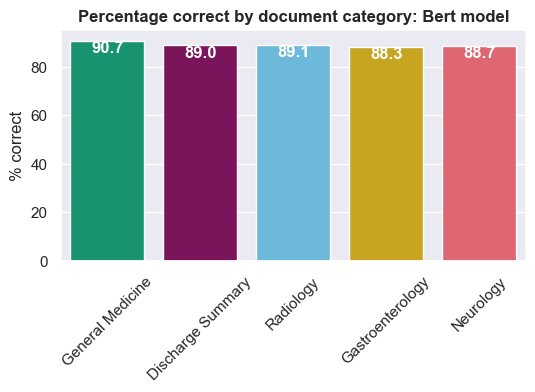

In [395]:
# Create column containing document types
with warnings.catch_warnings(record=True):
    df_combin['Type'] = df_combin['file'].str.replace('\d+', '').str.replace('_', '').str.replace('.txt', '')  

# Plot percentage correct by document type
perc_dict = {}

# Append to dictionary document types (keys) and percentages correct (values)
doc_types = df_combin.Type.unique()
for doc_type in doc_types:
    perc_correct = (df_combin[df_combin.Type==doc_type].correct.sum() / len(
    df_combin[df_combin.Type==doc_type]))*100
    perc_dict[doc_type] = perc_correct
  
    # Generate barplot
fig, axes = plt.subplots(figsize=(6,3))
colours = ['#04A777', '#8B0462', '#5BC0EB', '#E3B505', '#F35361']
plt.title("Percentage correct by document category: Bert model", fontsize=12, fontweight='bold')
plt.xticks(rotation = 45)
plt.ylabel('% correct')
sns.barplot(x=list(perc_dict.keys()), y=list(perc_dict.values()), palette=colours);

# Label barplot with percentage values
for p, perc in zip(axes.patches, list(perc_dict.values())):
    axes.annotate(np.round(perc,1), xy=(p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='top', 
                  color='w', weight='bold')

- - -

## Out-of-vocabulary (OOV) analysis <a id="16"></a>

In [301]:
# Extract unique words appearing in enclosing sentence from all textfiles in corpus

sentence_words = []

for sent in df_sent['enclosing_sentence'].to_list():
    sentence_words.extend(sent.split())

sentence_words = list(set([s.lower() for s in sentence_words]))
sentence_words[:11]

['where',
 'pounds',
 'hepatitis',
 'report.',
 '0',
 'agitated',
 'postnasal',
 'lidex',
 'restrictive',
 'glenoid',
 'each']

In [302]:
#

bert_oov = []
clin_oov = []

for word in sentence_words:
    if word not in bert_tokenizer.vocab.keys():
        bert_oov.append(word)
        
for word in sentence_words:
    if word not in clin_tokenizer.vocab.keys():
        clin_oov.append(word)

In [309]:
#

print(len(sentence_words))

print(len(bert_oov))
print(len(bert_tokenizer.vocab.keys()))

print(len(clin_oov))
print(len(clin_tokenizer.vocab.keys()))

6593
4108
30522
4320
28996
